## TRAINING AUGMENTED INTERPOLATION 

In [117]:
import os


import torch
import torch.nn as nn
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch loaded; device is cpu


# PINNs Advection Equation

This notebook solves the advection-diffusion equation using a physics-informed neural network (PINN). The equation is given by:

\begin{cases}
\partial_t u + a \partial_x u = 0 \\
u(t=0, x) = u_0(x, \mu)
\end{cases}

where $u$ is the dependent variable, $t$ is time, $x$ is space, and $a$ is the diffusion coefficient (velocity) The initial condition is given by:

\begin{equation}
u_0(x) = \exp(-(x-\mu)^2/\sigma)
\end{equation}

Where $\mu$ is the mean and $\sigma$ is the variance. The solution is given by:

\begin{equation}
u(x,t) = u_0(x-a*t)
\end{equation}

## Analysis:

### Neural Network
A neural network is a function that maps an input $X$ to an output $Y$ by performing successive linear and nonlinear transformations. The linear transformations are represented by a set of weights $W$ and biases $b$ and the nonlinear transformations are represented by activation functions $\sigma$. The output of a neural network is given by:

$$\overline{u_\theta}(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

We will train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset. 

### Physics Informed Neural Network = NN + PDE

We can use a neural network to approximate any function (Universal Approximation Theorem). In our case, we want to approximate the solution of a PDE. We can do this by minimizing the error of the PDE in a certain number of points inside our domain.

$$\overline{u_\theta}\approx u(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial \overline{u_\theta}}{\partial t},\frac{\partial \overline{u_\theta}}{\partial x}$.

We assume then: $$\overline{u_\theta}(x,t)\approx u(x,t,\theta)$$ 

Then:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a \frac{\partial \overline{u_\theta}}{\partial x}\right) \approx \left(\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x}\right) =0$$

And:

$$\left(\frac{\partial\overline{u_\theta}}{\partial t} + a\frac{\partial \overline{u_\theta} }{\partial x}\right) \approx 0$$

We should also define the boundary conditions both in space and time as it follows:

boundary conditions in space:

$$bc_{space}(x)=x*(x-1)$$

boundary conditions in time:
$$bc_{time}(t)=t$$

Now we can define this function as $u_\theta$:

$${u_\theta}(x,t)= u_{0}(x)+ bc_{time}(t) * bc_{space}(x) * \overline{u_\theta}(x,t)$$ 

If $u_\theta \rightarrow 0$ then our $\overline{u_\theta}$ would be respecting the physical law.

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_{coll}$) inside our domain $(x,t)$, and we try also to guess the values of $\mu$ and $\sigma$ of our initial condition adding also collocation points to these parameters ($N_{\mu}$ and $N_{\sigma}$). 

Then we iteratively minimize a loss function related to $u_\theta$:

$$MSE_{u_\theta}=\frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u_{exact}}=\frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u_{exact}}+MSE_{u_\theta}$$

We are looking to minimize:
$$
\Theta* = argmin_\Theta \left\{ \frac{1}{N_{coll}}\sum^{N_{coll}}_{i=1}|u_\theta(t_{coll}^i,x_{coll}^i,\mu_{coll}^i,\sigma_{coll}^i)|^2 + \frac{1}{N_{u_{exact}}}\sum^{N_{u_{exact}}}_{i=1}|u(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i
)-\overline{u_\theta}(t_{u_{exact}}^i,x_{u_{exact}}^i, \mu_{u_{exact}}^i,\sigma_{u_{exact}}^i)|^2 \right\} $$

where $u_\theta$ is the PDE and $u$ is the exact solution.

## Neural Network 

In [118]:
class Net(nn.DataParallel): 
    
    """Defines the neural network model"""
    def __init__(self):
        
        super(Net, self).__init__(nn.Module)
        self.hidden_layer1 = nn.Linear(4, 30).double() 
        self.hidden_layer2 = nn.Linear(30, 30).double()
        self.hidden_layer3 = nn.Linear(30, 30).double()
        self.hidden_layer4 = nn.Linear(30, 10).double()
        self.output_layer = nn.Linear(10, 1).double()

    """Defines the sequence of operations that are applied to the input tensors to produce the output of the neural network"""
    def forward(self, x, t, mean, variance):
    
        inputs = torch.cat([x,t,mean,variance], axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output


def network_BC(t): #t to define u_theta
    return t 

### Parameters

In [119]:
class Parameters:
   def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.a = 1.
        self.learning_rate = 1e-3
        self.file_name = file_name
        self.min_mean = 0.4
        self.max_mean = 0.6
        self.min_variance = 0.01
        self.max_variance = 0.2
     
   def u0(self,x,mean,variance):
        return torch.exp(-(x-mean)**2/variance)

## PINN

In [120]:
class Network:

    def __init__(self,param: Parameters):
        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.u0 = param.u0
        self.tf = param.tmax
        self.a = param.a
        self.file_name = param.file_name
        self.min_mean, self.max_mean = param.min_mean, param.max_mean
        self.min_variance, self.max_variance = param.min_variance, param.max_variance
   
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)

    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = nn.DataParallel(Net()).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate) #optimization algorithm
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t, mean, variance):

        u = self.u0(x, mean, variance) + network_BC(t) * self(x, t, mean, variance)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]  # it enables the creation of a computational graph for the gradients. A computational graph is a data structure that represents the operations performed on tensors and their dependencies, which allows for automatic differentiation and backpropagation.
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] #(automatic)
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t, mean, variance): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor 
        ones = torch.ones(x.shape, dtype=torch.double, device=device)
        pt_mean = mean * ones
        pt_variance = variance * ones
        pt_t = t * ones
        pred = self.u0(x, pt_mean, pt_variance) + network_BC(pt_t) * self(x, pt_t, pt_mean, pt_variance)

        return pred

    #Pour l'instant c'est pas utilisé
    """This method predicts the value of u for a given input x and a mesh object"""
    def predict_u(self, x, t, mesh): # x float t float mesh object

        #We need to reshape the input x to be a column vector
        reshaped_x = x.reshape((x.size, 1))
        pt_x = Variable(torch.from_numpy(reshaped_x).double(), requires_grad=True).to(device)
        reshaped_t = t.reshape((x.size, 1))
        pt_t = Variable(torch.from_numpy(reshaped_t).double(), requires_grad=False).to(device)

        u_pred = self.u0(pt_x) + network_BC(pt_t) * self(pt_x, pt_t)

        return u_pred.detach().cpu().numpy().reshape(x.shape)
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
        self.mean_data = Network.random(self.min_mean, self.max_mean, shape)
        self.variance_data = Network.random(self.min_variance, self.max_variance, shape)
        
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0, self.mean_data, self.variance_data) # la solution exacte evaluée dans (xi,ti)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)
        self.mean_collocation = Network.random(self.min_mean, self.max_mean, shape, requires_grad=True)
        self.variance_collocation = Network.random(self.min_variance, self.max_variance, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints
        
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation, self.mean_collocation, self.variance_collocation)
                mse_f = mse_cost_function(f_out, self.zeros)
                self.loss += mse_f
            

            if n_data > 0:
                # Loss based on data fitting (on apprend que avec des donées)
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data, self.mean_data, self.variance_data) #reseau evaluée dans (xi,ti)
                #on essaie de minimizer la différence entre la solution exacte et la solution du réseau calculées en (xi,ti)
                mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                
                self.loss += mse_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
          
            """To enforce the boundary conditions, we evaluate the neural network solution at the boundary points and compare it to the boundary values."""
            #boundary (periodicity) in x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data, self.mean_data, self.variance_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mse_f_boundaryx = mse_cost_function(f_boundaryx, self.zeros1)

            #boundary (periodicity) in t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor, self.mean_data, self.variance_data)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor, self.mean_data, self.variance_data)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mse_f_boundaryt = mse_cost_function(f_boundaryt, self.zeros1)

            #Initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min, self.mean_data, self.variance_data)
            f_initial_real= self.u0(self.x_data, self.mean_data, self.variance_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mse_f_initial = mse_cost_function(f_initiale, self.zeros1)

            self.loss += mse_f_initial + mse_f_boundaryx + mse_f_boundaryt  

            #on fait la backpropagation et on met à jour les poids
            self.loss.backward() # This is for computing gradients using backward propagation
            self.optimizer.step() #This is equivalent to the update step in the gradient descent algorithm
          

            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, mean, variance, device=device):
        return u0((x - a * t) % xmax, mean, variance)
    
    
    def plot(self, t, mean, variance):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
            # mean = (self.x_min + self.x_max) / 2
            # variance = (self.x_max - self.x_min) / 2
        
            u_pred = self.predict_u_from_torch(x, t, mean, variance)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0, mean, variance)


            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")

            print("Error ", torch.abs(u_pred - u_exact).mean().detach().cpu().item())


    #To save the solution in the form of a .gif file
    def animate(self, mean, variance):
        nb_points = 1000
        x = torch.linspace(self.x_min, self.x_max, nb_points, dtype=torch.double, device=device)[:, None]
        t = torch.linspace(self.t_min, self.t_max, nb_points, dtype=torch.double, device=device)[:, None]
                
        """u exact"""
        u_exact = np.zeros((nb_points, nb_points))
        for i in range(nb_points):
            for j in range(nb_points):
                u_exact[i,j] = Network.u_exact(x[i], t[j], self.a, self.x_max, self.u0, mean, variance)

        """prediction"""

        u = np.zeros((nb_points, nb_points))
        for i in range(nb_points):
            u[i, :] = self.predict_u_from_torch(x, t[i], mean, variance).detach().cpu().numpy().flatten()

        fig, ax = plt.subplots()
        line, = ax.plot([], color='red', label='numerical solution')
        line_exact1, = ax.plot([], color='blue', label='exact solution')
        ax.grid()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('x')
        ax.set_ylabel('u')
        ax.set_title('Solution of the advection equation')
        ax.legend()

        def animate(frame_num):
            line.set_data(x, u[frame_num, :])
            line_exact1.set_data(x, u_exact[frame_num, :])
            return line, line_exact1

        anim = FuncAnimation(fig, animate, frames=nb_points, interval=120, blit=True)
        anim.save("animation" + str(mean) + ".gif", writer='pillow')

   

## Semi Lagrangian solver class

In [121]:
"""A function that will create the mesh"""

def mesh (xmin, xmax, tmin, tmax, nx, nt, order):
    x = np.linspace(xmin, xmax, nx, endpoint=True)
    t = np.linspace(tmin, tmax, nt, endpoint=True)
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    return x, t, dx, dt

class SemiLagrangianSolver:

    def __init__(self, xmin, xmax, tmin, tmax, nx, nt, a, order):
        
        self.xmesh, self.tmesh, self.delta_x, self.delta_t = mesh(xmin, xmax, tmin, tmax, nx, nt, order)
        
        # self.xmesh, self.tmesh = mesh(xmin, xmax, tmin, tmax, nx, nt, order)

        self.xmax = xmax
        self.xmin = xmin
        self.tmax = tmax
        self.a = a #velocity
        self.nt=nt
        self.nx=nx
        self.u = np.zeros((nt, nx))
        self.u_deep = np.zeros((nt, nx))
        self.order=order
        self.mean = 0.5
        self.variance = 0.09
    
    """Function that defines the u(t=0, x) initial condition"""

    def u_0(self, x):
        return np.exp(-(x-self.mean)**2/self.variance)
    

    """Function that calculates the explicit solution of the transport equation"""
    def explicit_solution(self, x, t): 
        return self.u_0((x - self.a * t) % self.xmax)


    """Function that calculates the closest points to the point x_star (phantom point) 
       based on the x_i point and returns the indexes and the x_star point"""

    def find_closest(self, index):
        # We first calculate the x_star point
        x_i = self.xmesh[index]
        # We take into account the periodicity of the domain
        x_star = (x_i - self.a * self.delta_t) % self.xmax
    
        # We calculate the k index so that x_star is in between x_k and x_{k+1}
        k = int(x_star / self.delta_x)
        #We calculate the other indexes based on k and the order
        indexes = np.zeros(self.order+1, dtype=int)
        indexes = np.arange(k - (self.order//2), k + (self.order//2) + 2)
        indexes = np.mod(indexes, self.nx)
        return indexes, x_star


    """Function that calculates the Lagrange basis polynomial Li at x_star"""
    def Li(self, x_star, x_closest, i):
        result = 1.0
        for j in range(len(x_closest)):
            if j != i:
                result *= (x_star - x_closest[j]) / (x_closest[i] - x_closest[j])
        return result

    """Function that calculates the numerical solution of the Transport equation 
       using de Lagrange interpolation operator"""
 
    def solver(self): #We calculate for t+1 at index index i the mesh at that time 

        self.u[0,:] = self.u_0(self.xmesh)
        
        #We calculate the solution for each time step and each x_i point
        for t in range(self.nt-1):
            for i in range(self.nx):
                # We calculate the closest points to x_star
                closest_indexes, x_star = self.find_closest(i)
                # We retrieve the closest points in our mesh
                x_closest = self.xmesh[closest_indexes]
                # We retrieve the solution at the closest pointsat the time t
                u_closest = self.u[t, closest_indexes]
        
                li = np.zeros(self.order+1)
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)
                u_sol = np.sum(u_closest*li)
                self.u[t+1,i] = u_sol   
        #print(self.u)
        return self.u
       
    def train_PINNs(self, filename, epocs, n_collocation, n_data):

        self.params= Parameters(tf=self.tmax, file_name=filename)
        self.network = Network(self.params)
        self.network.train(epocs, n_collocation, n_data)

    """u_thetai function""" #changer ce solution pour la solution trouvee par le reseau de neurones
    def u_theta(self, x, t):
        pred= self.network.predict_u_from_torch(x, t, self.mean, self.variance)
        return pred.detach().cpu().numpy() #.flatten()

    """Function that calculates using the Deep Lagrange interpolation the numerical solution of the transport equation"""

    def solver_deep(self):
        self.u_deep[0,:] = self.u_0(self.xmesh)

        for t in range(self.nt-1):
            for i in range(self.nx):
                #print("t=", t, "i=", i)
                closest_indexes, x_star = self.find_closest(i)
                x_closest = self.xmesh[closest_indexes]
                x_closest = x_closest.reshape(-1, 1)
                # print("x_closest",x_closest)
                x_closest = torch.tensor(x_closest, dtype=torch.float32)
                
                u_closest = self.u_deep[t, closest_indexes]
                u_theta_i = self.u_theta(x_closest, self.tmesh[t])
                # print("sol exacte", self.explicit_solution(x_closest, self.tmesh[t]))
                # print("sol approchee", u_theta_i)
                u_closest_theta = u_closest / u_theta_i

                li = np.zeros(self.order+1)
                for j in range(self.order+1):
                    li[j] = self.Li(x_star, x_closest, j)
                    x_star_tensor = torch.tensor(x_star.reshape(-1, 1), dtype=torch.float32).clone().detach()
                    u_theta = self.u_theta(x_star_tensor, self.tmesh[t])
                    #print("u_theta", u_theta)
                    li[j] *= u_theta

                u_sol = np.sum(u_closest_theta * li)
                self.u_deep[t+1, i] = u_sol
        
        return self.u_deep



    """Function that will show the plot of the solution at a given time t"""
  
    def plot_solution(self,t):
        plt.plot(self.xmesh, self.u[t,:], label = 'numerical solution')
        plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution")
        plt.legend()
        plt.show()
    

    """Function that will show the plot of the solution using deep interpolation at a given time t"""
    def plot_solution_deep(self,t):
        plt.plot(self.xmesh, self.u_deep[t,:], label = 'u deep with PINNs')
        print("deep",self.u_deep[t,:])
        xmesh_tensor = torch.tensor(self.xmesh.reshape(-1, 1), dtype=torch.float32).clone().detach()
        plt.plot(self.xmesh, self.u_theta(xmesh_tensor, self.tmesh[t]), label = 'sol donné par le reseau')
        #plt.plot(self.xmesh, self.explicit_solution(self.xmesh, self.tmesh[t]), label = 'exact solution')
        #print("exact",self.explicit_solution(self.xmesh, self.tmesh[t]))
        #plt.plot(self.xmesh, self.u[t,:], label = 'u')
        #print("u",self.u[t,:])
        plt.title("Solution at time t = " + str(self.tmesh[t]))
        plt.grid()
        plt.xlabel("x")
        plt.ylabel("numerical solution deep")
        plt.legend()
        plt.show()

        
    """ Function that will calculate the error of the numeral solution compared to the analytical solution at a given time t"""
    def error_solution(self, t):
        return np.sum(np.linalg.norm(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]), ord=2))
     
    """Function that will calculate the error in infinity norm for both solutions"""
    def error_inf_norm(self, deep):
        diff = 0
        if deep==True:
            for t in range(self.nt):
                diff = np.abs(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
                norm = np.max(diff)
        else:
            for t in range(self.nt):
                diff = np.abs(self.u[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t]))
                norm = np.max(diff)

        return norm
    
    """Function that will calculate the error in L2 norm for both solutions"""
    def error_L2_norm(self, deep):
        norm = 0
        if deep==True:
            for t in range(self.nt):
                diff = self.explicit_solution(self.xmesh, self.tmesh[t])-self.u_deep[t,:]
            for j in range(self.nx):
                norm += (diff[j-1]**2 + diff[j]**2 )* self.delta_x / 2
        else:
            for t in range(self.nt):
                diff = self.explicit_solution(self.xmesh, self.tmesh[t])-self.u[t,:]
            for j in range(self.nx):
                norm += (diff[j-1]**2 + diff[j]**2 )* self.delta_x / 2

        return norm

    """ Function that will calculate the error of the numeral deep solution compared to the analytical solution at a given time t"""
    def error_solution_deep(self, t):
        return np.sum(np.linalg.norm(self.u_deep[t,:] - self.explicit_solution(self.xmesh, self.tmesh[t])))

### Deep solution using PINNs

In [122]:
"""We first define the values of the parameters of the 3 solvers """

xmin = 0
xmax = 1
tmin = 0    
tmax = 1
nx = 100
nt = 200 #10
a=1

solver = SemiLagrangianSolver(xmin, xmax, tmin, tmax, nx, nt, a, 3)
X_2 = solver.xmesh
T_2 = solver.tmesh

"""We verify the CFL condition"""

print("cfl solver" , a*solver.delta_t/solver.delta_x)

u = solver.solver()
solver.train_PINNs("sol9", 1000, 10000, 1000)
#solver.train_PINNs("sol9", 100, 1000, 100)

cfl solver 0.49748743718592964
network loaded successfully
epoch     0: current loss = 5.44e-03
epoch    39: best loss = 4.13e-03
epoch   149: best loss = 4.03e-03
epoch   210: best loss = 3.93e-03
epoch   280: best loss = 3.78e-03
epoch   500: current loss = 5.01e-03
epoch   700: best loss = 3.73e-03
epoch   926: best loss = 3.68e-03
epoch   999: current loss = 6.19e-03
network loaded successfully


In [123]:
u_deep = solver.solver_deep()

#### Vérification de la solution prédite par le réseau de neurones

Error  0.0


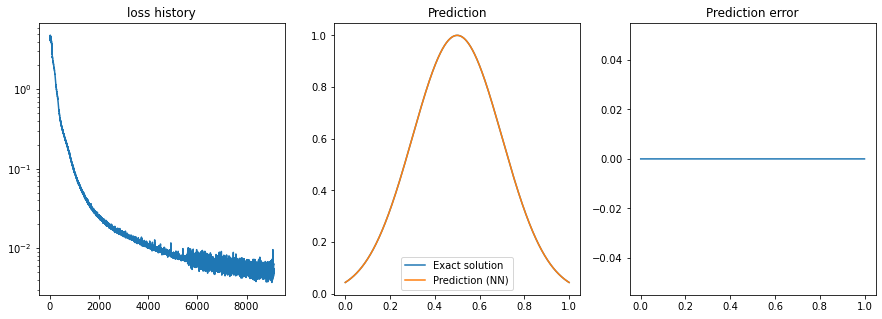

In [124]:
solver.network.plot(0., 0.5, 0.08)

Error  0.0056825885968851035


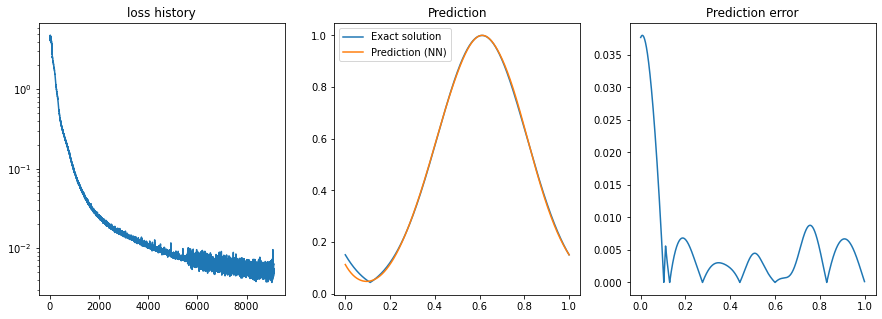

In [125]:
solver.network.plot(0.1111111111, 0.5, 0.08)

Error  0.0051256550108637715


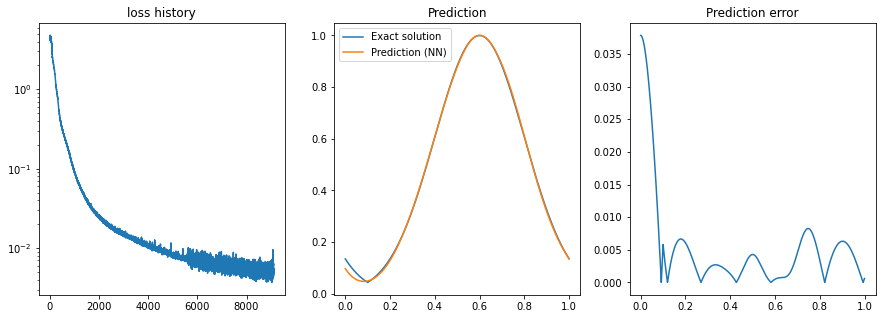

In [126]:
solver.network.plot(0.1, 0.5, 0.08)

Error  0.007911799288869871


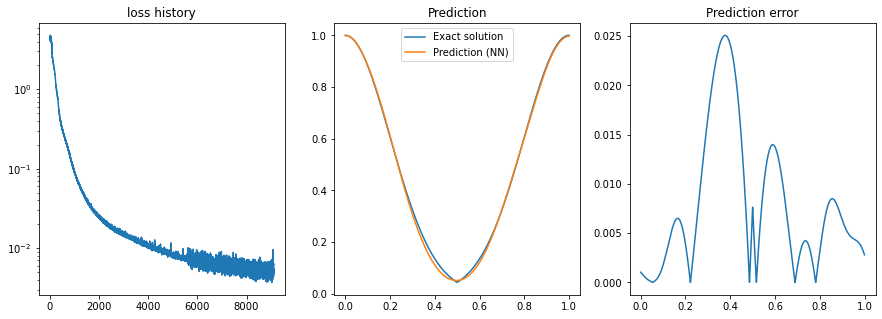

In [127]:
solver.network.plot(0.5, 0.5, 0.08)

Error  0.007472634390016779


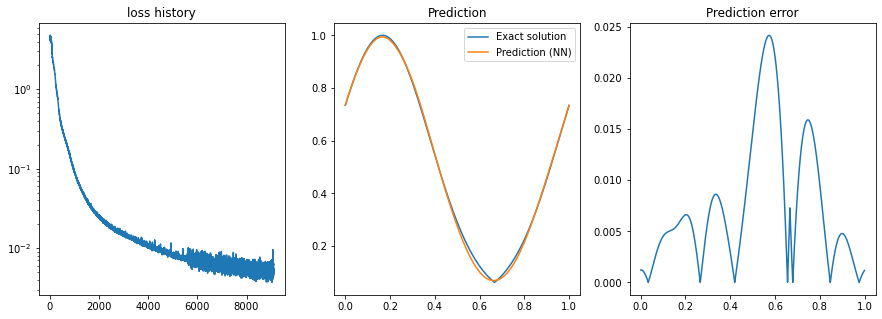

In [128]:
solver.network.plot(0.6666666, 0.5, 0.09)

### Graphique Deep solution vs Exact solution vs Solution numérique

deep [0.06217652 0.06948266 0.07747147 0.08618316 0.09565735 0.10593259
 0.11704588 0.12903217 0.14192377 0.15574984 0.17053573 0.18630241
 0.20306583 0.22083634 0.23961805 0.25940828 0.28019697 0.30196621
 0.32468973 0.34833257 0.37285065 0.39819064 0.42428969 0.45107549
 0.47846622 0.50637078 0.53468906 0.56331234 0.59212383 0.62099931
 0.64980792 0.67841305 0.70667331 0.73444367 0.76157662 0.78792343
 0.81333551 0.83766575 0.86076994 0.88250816 0.9027462  0.92135696
 0.9382217  0.95323139 0.96628781 0.97730466 0.98620851 0.9929396
 0.99745249 0.99971662 0.99971662 0.99745249 0.9929396  0.98620851
 0.97730466 0.96628781 0.95323139 0.9382217  0.92135696 0.9027462
 0.88250816 0.86076994 0.83766575 0.81333551 0.78792343 0.76157662
 0.73444367 0.70667331 0.67841305 0.64980792 0.62099931 0.59212383
 0.56331234 0.53468906 0.50637078 0.47846622 0.45107549 0.42428969
 0.39819064 0.37285065 0.34833257 0.32468973 0.30196621 0.28019697
 0.25940828 0.23961805 0.22083634 0.20306583 0.18630241 0.1

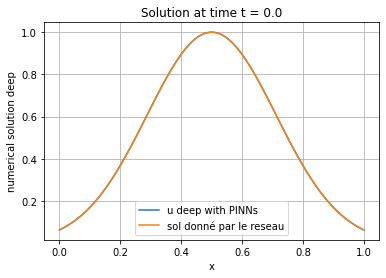

deep [0.25689285 0.25717985 0.29631798 0.32990874 0.36647782 0.40618105
 0.44916892 0.49558457 0.54556181 0.59922269 0.65667506 0.71801073
 0.78330239 0.85260139 0.92593534 1.00330589 1.08468645 1.17001936
 1.25921532 1.35215035 1.44866574 1.54856486 1.65161435 1.75754361
 1.86604262 1.9767653  2.08932914 2.20331443 2.31827196 2.43371884
 2.54914369 2.66401395 2.77777325 2.88984801 2.99965604 3.106605
 3.21009992 3.30955263 3.40438098 3.49401671 3.57791489 3.65555362
 3.72644136 3.79012567 3.84619283 3.89427396 3.93405215 3.96526164
 3.98769203 4.00119301 4.00567337 4.001102   3.98751039 3.96499035
 3.93369371 3.89383038 3.8456664  3.78952071 3.72576251 3.65480386
 3.57709999 3.49314135 3.40344946 3.30857168 3.20907664 3.10554327
 2.99856279 2.88872871 2.77663287 2.66285993 2.54798293 2.43255453
 2.31711031 2.20215995 2.08818561 1.97563866 1.86493771 1.75646279
 1.65056115 1.54754142 1.44767485 1.35119593 1.25829766 1.16914003
 1.08384631 1.0025057  0.9251754  0.85188297 0.78262459 0.7

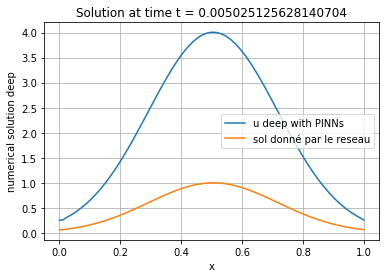

deep [ 1.1068494   0.96687822  1.10503152  1.26129657  1.40110605  1.55511522
  1.72185243  1.90192429  2.09590378  2.30431858  2.52764021  2.76627781
  3.02056608  3.29075592  3.57700574  3.87937328  4.19780745  4.53213489
  4.88205926  5.2471491   5.62683754  6.02040737  6.42699473  6.84559178
  7.27503092  7.71399925  8.16104079  8.61454293  9.07277608  9.53387442
  9.99584379 10.4566074  10.91398753 11.36571986 11.80950481 12.24299362
 12.66380674 13.06958878 13.45799901 13.82673223 14.17357428 14.49639568
 14.79317188 15.06203404 15.3012624  15.50930015 15.68479304 15.82657963
 15.93369883 16.00542171 16.04125192 16.04092992 16.0044543  15.93207494
 15.82428539 15.68181502 15.5056205  15.29687438 15.05695877 14.78743164
 14.49003218 14.16665408 13.81932227 13.45017367 13.06144144 12.65539998
 12.23437898 11.80073412 11.35682429 10.90499406 10.44755699  9.98674962
  9.52475148  9.06365444  8.60544557  8.15199653  7.70505505  7.26621037
  6.83692436  6.41851231  6.01213751  5.618820

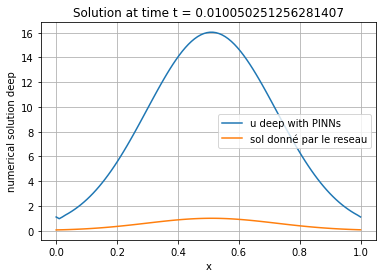

deep [ 4.83717135  3.77951945  4.07775871  4.75045261  5.35284694  5.94173182
  6.59117566  7.29148043  8.0456529   8.85601431  9.72466477 10.65345244
 11.64392742 12.69730291 13.8144226  14.99573292 16.24125548 17.5505314
 18.92261816 20.35604593 21.84881635 23.39833921 25.00143898 26.65437567
 28.35277725 30.09168123 31.86555919 33.66824466 35.49308707 37.33289618
 39.17993175 41.02609684 42.86289047 44.68141099 46.47257552 48.22708985
 49.93546905 51.5882743  53.17610469 54.68963614 56.11986644 57.45812532
 58.69611863 59.82615327 60.84113716 61.73458845 62.5007894  63.1347453
 63.63216193 63.98958041 64.20442908 64.2750718  64.20094017 63.98254868
 63.62143617 63.12010489 62.48197264 61.71132405 60.8133037  59.79379001
 58.65941372 57.41747709 56.07585084 54.64287613 53.12730824 51.53807233
 49.88430311 48.17527822 46.42034063 44.62882868 42.8100311  40.97297863
 39.12651122 37.27918467 35.43918223 33.61425111 31.81167677 30.03811273
 28.29969704 26.60200634 24.95001625 23.34813503

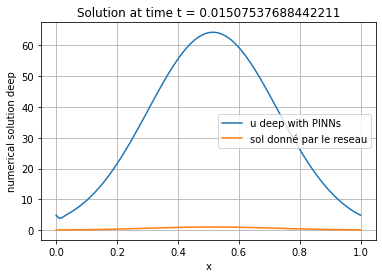

deep [ 21.17777641  15.41191938  15.25191818  17.59761065  20.28922821
  22.68109837  25.18016567  27.91583696  30.85431066  34.01002442
  37.39224716  41.0093795   44.8686094   48.97574996  53.33510776
  57.94939008  62.81962116  67.94493012  73.32253243  78.94757083
  84.81312215  90.90994103  97.22645598 103.74886013 110.46086314
 117.34380124 124.37674158 131.53619511 138.79666873 146.13050021
 153.50776747 160.89697834 168.26498773 175.57693767 182.79702985
 189.88851727 196.81371434 203.53485004 210.01416543 216.2140328
 222.09788426 227.63041301 232.77775302 237.50834701 241.79307428
 245.60523255 248.92100749 251.71925486 253.98122706 255.69096693
 256.83566137 257.40610005 257.3974672  256.80968311 255.64715663
 253.91834258 251.63538421 248.8138521  245.47276671 241.63420324
 237.32337459 232.56838309 227.39983765 221.85035375 215.95426969
 209.74661812 203.26315422 196.54019104 189.61446449 182.52290381
 175.30253268 167.98964681 160.61998211 153.22838409 145.84847117
 138.5

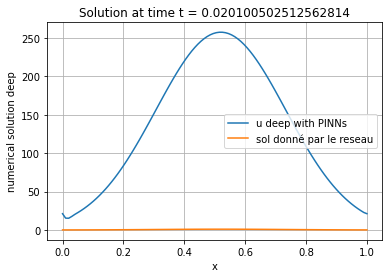

deep [  92.44935542   64.90532402   58.95584677   64.85313747   75.82078953
   86.23751029   96.06492051  106.6736734   118.17245854  130.48477652
  143.67263613  157.77270594  172.81822212  188.83676086  205.84969363
  223.87184294  242.91125337  262.96843608  284.0362987   306.0995424
  329.13475134  353.10940721  377.98179109  403.70129276  430.20751982
  457.43064759  485.29172315  513.7015719   542.56283334  571.7693184
  601.20569665  630.74990713  660.2729184   689.63859844  718.7063313
  747.33102487  775.36327652  802.65234446  829.04664386  854.39449255
  878.5475955   901.36213897  922.69996957  942.43200409  960.43899143
  976.61166346  990.85207959 1003.07214366 1013.19179649 1021.13960522
 1026.8540733  1030.28667379 1031.40657861 1030.20364904 1026.68799702
 1020.88748074 1012.84508935 1002.61719647  990.27364627  975.89675451
  959.58195115  941.43707838  921.58110099  900.14182616  877.25425218
  853.05615126  827.68760513  801.29028361  774.00762974  745.98455479
  71

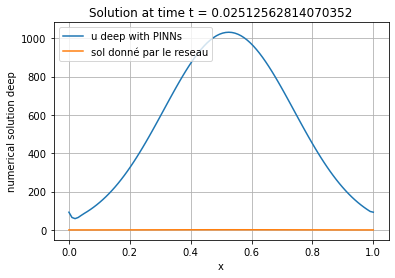

deep [ 401.8079306   278.53297249  237.13704912  242.13525982  279.75270952
  324.73290603  365.68103751  406.92471176  451.80163397  500.02505072
  551.53358018  606.56956817  665.27664846  727.78448191  794.19681107
  864.59034259  939.01408114 1017.48676762 1099.99677922 1186.49981811
 1276.91946378 1371.14353628 1469.02358895 1570.37581196 1674.9776741
 1782.56935071 1892.85446257 2005.49567118 2120.12251522 2236.32854434
 2353.67033987 2471.67642976 2589.84575016 2707.64774754 2824.53192711
 2939.92680837 3053.24113608 3163.87497227 3271.22079636 3374.66756332
 3473.61475862 3567.47684078 3655.68999497 3737.72685211 3813.09994408
 3881.36371417 3942.11921347 3995.00498825 4039.68625019 4075.85243871
 4103.21903847 4121.54277606 4130.64825583 4130.44900052 4120.95088206
 4102.24094471 4074.4708969  4037.84476623 3992.61760766 3939.09375818
 3877.63182494 3808.64377701 3732.59107152 3649.97520677 3561.32876984
 3467.19560345 3368.12628829 3264.67361139 3157.39493096 3046.85443532
 2

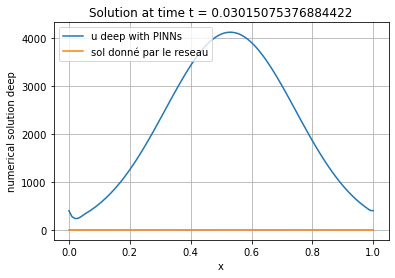

deep [ 1738.19141761  1205.24470777   987.03419371   931.1144062
  1029.41037161  1206.91910725  1383.84869512  1549.55444556
  1724.03150983  1913.02340354  2114.85655953  2330.00563176
  2559.35679019  2803.47062394  3062.84388838  3337.85895353
  3628.78415415  3935.76491348  4258.82457698  4597.85579206
  4952.62318353  5322.75016832  5707.71731734  6106.86485701
  6519.37918064  6944.29914438  7380.51805511  7826.76511771
  8281.63595453  8743.58005396  9210.89702435  9681.77134548
 10154.26322507 10626.30940593 11095.76087198 11560.37371905
 12017.81300603 12465.69684325 12901.59640226 13323.05289116
 13727.63705652 14112.96693194 14476.74033064 14816.80192321
 15131.160353   15418.00144899 15675.7097028  15902.82153544
 16097.96448684 16259.82503356 16387.13230606 16478.71810898
 16533.65295188 16551.37672473 16531.74761722 16475.00502815
 16381.67994478 16252.51360804 16088.4352073  15890.56011371
 15660.22280857 15398.98599574 15108.63285255 14791.13083183
 14448.58800849 1408

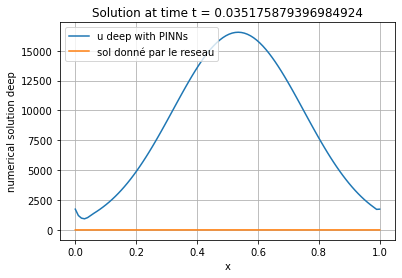

deep [ 7484.65575485  5226.24131323  4203.39018037  3716.07505512
  3836.22381441  4438.81257725  5183.30907719  5879.80127465
  6566.77859128  7304.70658059  8097.47710128  8940.77955379
  9838.07031448 10792.48753917 11806.20857295 12881.10239698
 14018.55218922 15219.43933022 16484.1505428  17812.54737581
 19203.97818198 20657.23004555 22170.52599054 23741.53310844
 25367.30654091 27044.31580739 28768.45253136 30534.95257251
 32338.51361546 34173.24222949 36032.63711575 37909.72714425
 39797.02670081 41686.53303152 43569.87803921 45438.27910912
 47282.54028609 49093.22712367 50860.65525292 52574.94941627
 54226.29275329 55805.00454851 57301.68332288 58707.51026164
 60014.34465778 61214.79904676 62302.34839559 63271.12386257
 64115.60004527 64830.36349456 65409.92215241 65848.88257593
 66142.57298848 66287.77410284 66283.1190513  66129.04307887
 65827.36031683 65380.78130201 64792.70058733 64067.17672277
 63209.11778391 62224.39198508 61119.84693578 59903.18425804
 58582.76506612 571

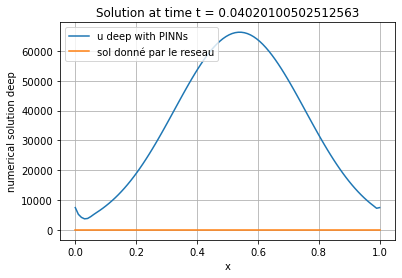

deep [ 32085.48560533  22644.36329121  18121.34133982  15347.06881993
  14692.58123748  16304.21342756  19180.09305224  22153.93137544
  24951.10607659  27837.01174561  30946.35848828  34261.83288436
  37779.95557954  41516.51872015  45482.59929267  49686.59552148
  54135.43056713  58833.90127954  63784.79472747  68988.7771
  74444.44786226  80148.16134207  86094.03292729  92273.97531282
  98677.46742283 105291.65586313 112101.39104541 119088.91014033
 126234.2855983  133515.20427151 140906.89105938 148382.65643013
 155913.7033459  163469.08377052 171016.29709851 178521.07070868
 185947.29984951 193257.71330561 200413.79985644 207375.99482133
 214104.68631351 220560.56817027 226705.25812978 232502.6311458
 237919.34844491 242925.28148834 247494.07248819 251602.32187303
 255228.12204659 258349.69815981 260944.04371718 262987.14959053
 264456.55655843 265335.06871559 265613.39264011 265290.65907094
 264372.70188388 262869.47739844 260793.49800411 258159.48604899
 254985.26847069 251292.5

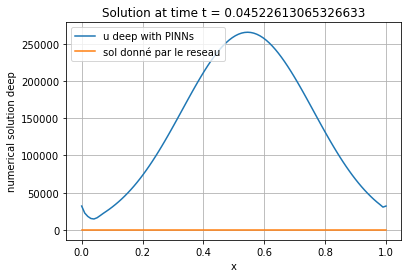

deep [ 136957.85562726   97931.19290989   78526.48391304   64980.80500493
   58290.95566076   60633.81670637   70335.74386995   82599.74326063
   94366.70953105  105854.1217708   118023.36608412  131068.44191279
  144903.80093359  159559.54376362  175096.40319735  191554.18237267
  208965.00187306  227353.70745644  246736.67340777  267121.70848124
  288508.26423544  310886.76453349  334238.68862053  358536.76147989
  383744.03044415  409814.23459398  436691.96269779  464311.40042804
  492598.04651298  521467.78727852  550826.55411156  580572.48357683
  610595.1311251   640775.18915742  670986.78576946  701096.55795978
  730963.20688487  760439.93216788  789374.00988284  817607.3596673
  844980.47717773  871333.96549898  896511.2150574   920364.13269385
  942755.88330998  963563.25113574  982679.51470234 1000011.54038001
 1015473.45376144 1028979.59885712 1040436.40534211 1049740.5846578
 1056788.36347251 1061492.75997759 1063798.79323351 1063689.8688392
 1061182.13531727 1056311.966024

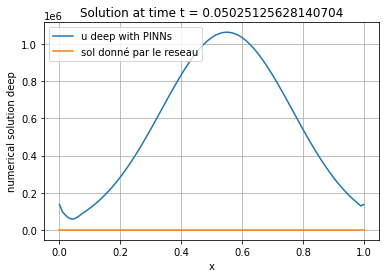

deep [ 582239.52542112  422611.42081442  340749.36750834  279272.51854206
  239258.46402563  231397.96249503  257835.27157481  304477.10069422
  354108.70737614  401232.75000607  449144.74872278  500375.09348251
  554904.68605891  612541.93247109  673505.97728119  738013.17768005
  806210.44489423  878217.62728569  954123.18563261 1033979.96214314
 1117807.05990847 1205587.12896338 1297266.86410224 1392757.97962776
 1491933.65738886 1594629.88863557 1700646.07894769 1809740.17150699
 1921635.30894393 2036015.9657638  2152526.41898342 2270779.2344501
 2390352.14126029 2510786.64657429 2631596.75069731 2752264.99652702
 2872240.13354092 2990945.84403011 3107778.27724362 3222107.64657963
 3333293.32927111 3440690.0372582  3543659.32903556 3641593.946188
 3733931.12138583 3820165.15554743 3899862.13341763 3972650.66710822
 4038196.44699345 4096169.04520842 4146198.46696215 4187854.51047113
 4220674.80805516 4244238.81607094 4258246.89084348 4262567.97418558
 4257228.72590241 4242358.542710

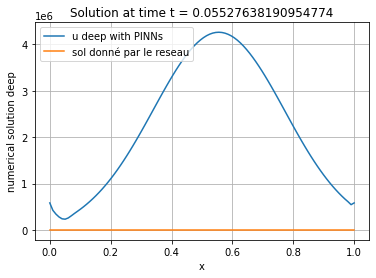

deep [ 2465871.04062235  1819625.26700809  1478160.2959179   1209308.40649666
  1008233.1390914    913501.62450911   956733.19684683  1113450.13787417
  1314831.7109059   1512489.90747109  1704801.8186512   1906013.28390709
  2120881.74951728  2348195.17395572  2587958.37614771  2841176.72119782
  3108605.96795592  3390793.8897321   3688184.95477483  4001084.17006871
  4329657.4021442   4673923.5406915   5033756.16807069  5408888.19893689
  5798898.61110404  6203217.60321243  6621128.69085211  7051749.69377713
  7494059.00211833  7946879.68743278  8408872.71136758  8878570.13516379
  9354362.77706544  9834494.25828308 10317094.11993225 10800160.65340433
 11281549.87707324 11759006.83617618 12230151.73802763 12692483.19462189
 13143435.69310826 13580402.80216501 14000785.29239964 14402093.71540498
 14782010.09532222 15138451.33241212 15469643.50300061 15774098.08726757
 16050516.11203457 16297643.00301374 16514054.34275004 16698013.13629116
 16847528.02624696 16960644.91511095 17035824.

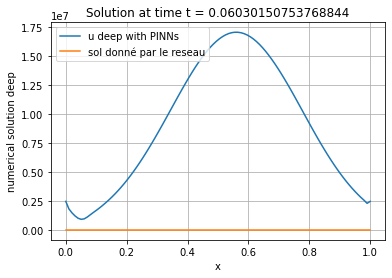

deep [10407203.30633512  7816364.81132174  6405933.95080548  5253141.27265416
  4321770.50207693  3730254.31309818  3639107.68420872  4072879.39780005
  4829588.95858459  5653713.30982547  6445419.07852859  7242671.18105335
  8088154.72300703  8985889.66247858  9931554.13751999 10927525.39396913
 11977694.24629244 13084720.20629898 14250680.36719275 15477183.87309277
 16765277.51949403 18115408.31114298 19527436.07152195 21000651.3070522
 22533726.47507939 24124737.37782526 25771170.40027057 27469847.65824026
 29217031.40689304 31008360.3887122  32838820.36533276 34702873.58267584
 36594409.91139835 38506723.00801176 40432637.742643   42364435.44702784
 44293803.38873288 46211948.12108719 48109523.04108337 49976625.55916186
 51803013.62286878 53578188.02768726 55291586.62575237 56933012.12473901
 58492909.38470196 59962669.88202617 61334997.41076999 62603880.2579136
 63764255.22197771 64811412.15817545 65740002.97084613 66543222.80276192
 67212766.7416161  67739876.45334512 68117012.29

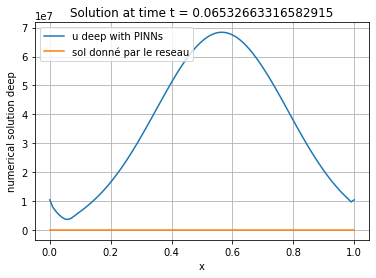

deep [4.37876878e+07 3.34933792e+07 2.77244169e+07 2.28417481e+07
 1.87035073e+07 1.56559674e+07 1.43040047e+07 1.50775874e+07
 1.76129448e+07 2.09119764e+07 2.42169175e+07 2.74360857e+07
 3.07701913e+07 3.43133295e+07 3.80521995e+07 4.19799573e+07
 4.61111815e+07 5.04597779e+07 5.50354639e+07 5.98460549e+07
 6.48973714e+07 7.01927817e+07 7.57332655e+07 8.15174942e+07
 8.75416423e+07 9.37994821e+07 1.00282411e+08 1.06979157e+08
 1.13876189e+08 1.20957472e+08 1.28204344e+08 1.35596016e+08
 1.43109382e+08 1.50718923e+08 1.58397209e+08 1.66114575e+08
 1.73838892e+08 1.81535985e+08 1.89169273e+08 1.96699690e+08
 2.04086484e+08 2.11287492e+08 2.18259897e+08 2.24961988e+08
 2.31354376e+08 2.37401397e+08 2.43072868e+08 2.48344279e+08
 2.53195738e+08 2.57609656e+08 2.61566408e+08 2.65040111e+08
 2.67997186e+08 2.70399670e+08 2.72212112e+08 2.73409422e+08
 2.73980979e+08 2.73928907e+08 2.73262571e+08 2.71993147e+08
 2.70131478e+08 2.67689390e+08 2.64682706e+08 2.61133621e+08
 2.57071505e+08 2.5

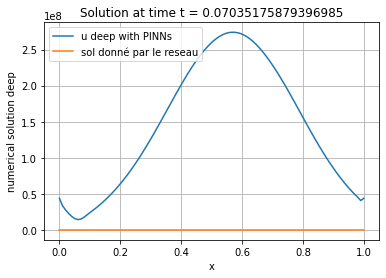

deep [1.83735461e+08 1.43152014e+08 1.19788878e+08 9.93161970e+07
 8.13342355e+07 6.69602180e+07 5.81501593e+07 5.71691885e+07
 6.42788416e+07 7.65546008e+07 9.01880492e+07 1.03453124e+08
 1.16737000e+08 1.30713480e+08 1.45507041e+08 1.61040695e+08
 1.77330471e+08 1.94440256e+08 2.12419155e+08 2.31303551e+08
 2.51122980e+08 2.71897704e+08 2.93638172e+08 3.16345440e+08
 3.40010441e+08 3.64614380e+08 3.90128865e+08 4.16514732e+08
 4.43723684e+08 4.71697332e+08 5.00366703e+08 5.29654211e+08
 5.59472875e+08 5.89725964e+08 6.20308971e+08 6.51108279e+08
 6.82000132e+08 7.12852141e+08 7.43521651e+08 7.73855095e+08
 8.03690896e+08 8.32860303e+08 8.61190252e+08 8.88510472e+08
 9.14658695e+08 9.39486980e+08 9.62869807e+08 9.84706284e+08
 1.00491728e+09 1.02343702e+09 1.04019491e+09 1.05509533e+09
 1.06800656e+09 1.07876914e+09 1.08722237e+09 1.09324045e+09
 1.09675731e+09 1.09776644e+09 1.09629967e+09 1.09240099e+09
 1.08611172e+09 1.07747245e+09 1.06653585e+09 1.05337946e+09
 1.03811216e+09 1.0

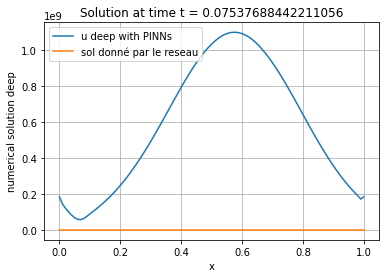

deep [7.69175696e+08 6.10233119e+08 5.16517296e+08 4.31546565e+08
 3.54468352e+08 2.89682222e+08 2.43207859e+08 2.23831232e+08
 2.37376286e+08 2.78415223e+08 3.32363928e+08 3.87425429e+08
 4.41276688e+08 4.96617183e+08 5.55112344e+08 6.16666126e+08
 6.81080512e+08 7.48539841e+08 8.19289711e+08 8.93506315e+08
 9.71329748e+08 1.05286859e+09 1.13819271e+09 1.22733330e+09
 1.32028042e+09 1.41698456e+09 1.51735720e+09 1.62126625e+09
 1.72854253e+09 1.83897601e+09 1.95231400e+09 2.06826886e+09
 2.18651491e+09 2.30668703e+09 2.42838857e+09 2.55118590e+09
 2.67460395e+09 2.79813165e+09 2.92121463e+09 3.04325144e+09
 3.16360384e+09 3.28159882e+09 3.39653914e+09 3.50773155e+09
 3.61450858e+09 3.71625625e+09 3.81245065e+09 3.90267252e+09
 3.98660230e+09 4.06399184e+09 4.13459091e+09 4.19805644e+09
 4.25388692e+09 4.30143249e+09 4.33998853e+09 4.36895205e+09
 4.38795351e+09 4.39689002e+09 4.39585413e+09 4.38501626e+09
 4.36453882e+09 4.33456390e+09 4.29526166e+09 4.24689291e+09
 4.18985074e+09 4.1

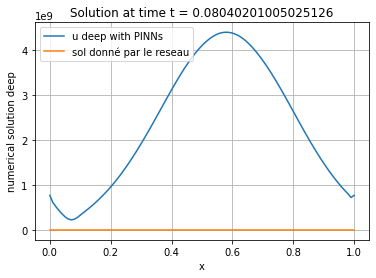

deep [3.21373508e+09 2.59455007e+09 2.22183354e+09 1.87292177e+09
 1.54609927e+09 1.26121407e+09 1.03824826e+09 9.06359349e+08
 8.97299884e+08 1.01363497e+09 1.21272817e+09 1.43764176e+09
 1.65936738e+09 1.88086390e+09 2.11225216e+09 2.35625544e+09
 2.61164840e+09 2.87832360e+09 3.15725844e+09 3.44934534e+09
 3.75524455e+09 4.07549084e+09 4.41048155e+09 4.76045708e+09
 5.12548924e+09 5.50548824e+09 5.90020513e+09 6.30921400e+09
 6.73193746e+09 7.16763231e+09 7.61538269e+09 8.07413089e+09
 8.54266499e+09 9.01961360e+09 9.50347739e+09 9.99260755e+09
 1.04851869e+10 1.09792495e+10 1.14726485e+10 1.19630371e+10
 1.24479037e+10 1.29245744e+10 1.33902501e+10 1.38421171e+10
 1.42774360e+10 1.46936600e+10 1.50885974e+10 1.54604920e+10
 1.58080326e+10 1.61302663e+10 1.64263141e+10 1.66949800e+10
 1.69344111e+10 1.71420353e+10 1.73148574e+10 1.74500967e+10
 1.75458285e+10 1.76012695e+10 1.76165878e+10 1.75924165e+10
 1.75294064e+10 1.74280742e+10 1.72889560e+10 1.71128895e+10
 1.69012466e+10 1.6

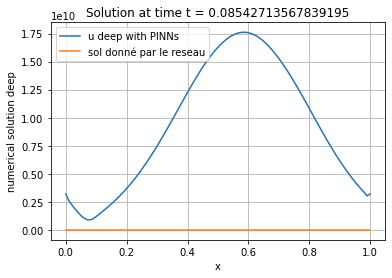

deep [1.34058020e+10 1.10036840e+10 9.53171104e+09 8.11435107e+09
 6.74340684e+09 5.50951920e+09 4.49093409e+09 3.77921273e+09
 3.50047231e+09 3.73381930e+09 4.39812722e+09 5.27916174e+09
 6.19393198e+09 7.09398789e+09 8.01372147e+09 8.98055616e+09
 9.99473290e+09 1.10520042e+10 1.21543362e+10 1.33058592e+10
 1.45098296e+10 1.57687707e+10 1.70847281e+10 1.84591578e+10
 1.98928237e+10 2.13858257e+10 2.29376117e+10 2.45469075e+10
 2.62118178e+10 2.79297710e+10 2.96974937e+10 3.15111354e+10
 3.33662197e+10 3.52576248e+10 3.71797098e+10 3.91262303e+10
 4.10902610e+10 4.30642668e+10 4.50399642e+10 4.70082294e+10
 4.89592173e+10 5.08823456e+10 5.27664197e+10 5.46000597e+10
 5.63720540e+10 5.80718565e+10 5.96902892e+10 6.12199534e+10
 6.26553845e+10 6.39928358e+10 6.52292167e+10 6.63604725e+10
 6.73799666e+10 6.82778072e+10 6.90416290e+10 6.96590441e+10
 7.01205532e+10 7.04213178e+10 7.05609219e+10 7.05415273e+10
 7.03657425e+10 7.00355391e+10 6.95525876e+10 6.89194255e+10
 6.81406383e+10 6.7

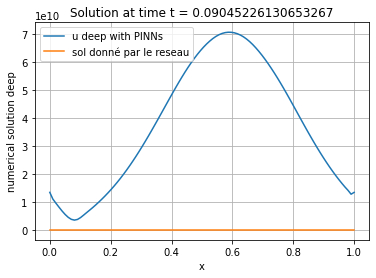

deep [5.58473441e+10 4.65579364e+10 4.07742379e+10 3.50746147e+10
 2.93889922e+10 2.41075028e+10 1.95781988e+10 1.61080141e+10
 1.41242812e+10 1.40719622e+10 1.59720651e+10 1.92000917e+10
 2.29028082e+10 2.66013685e+10 3.02957667e+10 3.41314269e+10
 3.81594785e+10 4.23614372e+10 4.67302096e+10 5.12797338e+10
 5.60259801e+10 6.09810420e+10 6.61547797e+10 7.15550293e+10
 7.71868961e+10 8.30527395e+10 8.91522326e+10 9.54820906e+10
 1.02036470e+11 1.08806755e+11 1.15781466e+11 1.22946762e+11
 1.30286259e+11 1.37780958e+11 1.45409750e+11 1.53149090e+11
 1.60972689e+11 1.68851774e+11 1.76754501e+11 1.84645531e+11
 1.92486419e+11 2.00235452e+11 2.07848037e+11 2.15278323e+11
 2.22480582e+11 2.29411244e+11 2.36031899e+11 2.42311257e+11
 2.48226250e+11 2.53761731e+11 2.58906678e+11 2.63647707e+11
 2.67961800e+11 2.71811996e+11 2.75148650e+11 2.77918282e+11
 2.80076029e+11 2.81595106e+11 2.82468364e+11 2.82702034e+11
 2.82306303e+11 2.81289025e+11 2.79655494e+11 2.77412816e+11
 2.74575465e+11 2.7

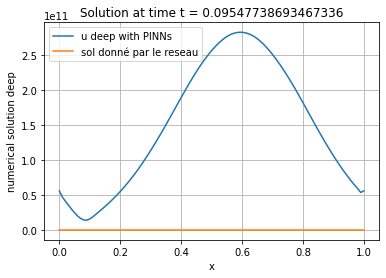

deep [2.32407059e+11 1.96570188e+11 1.73913593e+11 1.51193996e+11
 1.27889557e+11 1.05540089e+11 8.57339947e+10 6.96771388e+10
 5.87352831e+10 5.47114555e+10 5.86817644e+10 6.94330719e+10
 8.38065392e+10 9.89706158e+10 1.13999697e+11 1.29299164e+11
 1.45296129e+11 1.62017063e+11 1.79381635e+11 1.97403949e+11
 2.16151188e+11 2.35682919e+11 2.56045774e+11 2.77278715e+11
 2.99410791e+11 3.22459873e+11 3.46432676e+11 3.71323751e+11
 3.97117057e+11 4.23785133e+11 4.51288779e+11 4.79579075e+11
 5.08596737e+11 5.38271857e+11 5.68525948e+11 5.99270680e+11
 6.30406674e+11 6.61824493e+11 6.93402177e+11 7.25003349e+11
 7.56478475e+11 7.87663785e+11 8.18382370e+11 8.48450242e+11
 8.77681587e+11 9.05896986e+11 9.32935952e+11 9.58665955e+11
 9.82988659e+11 1.00584114e+12 1.02718287e+12 1.04697067e+12
 1.06512741e+12 1.08151898e+12 1.09595138e+12 1.10820031e+12
 1.11806177e+12 1.12539782e+12 1.13015385e+12 1.13234074e+12
 1.13199607e+12 1.12915180e+12 1.12382565e+12 1.11603537e+12
 1.10582304e+12 1.0

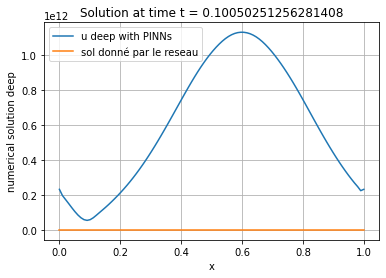

deep [9.66328531e+11 8.28338892e+11 7.39674253e+11 6.49732283e+11
 5.55292339e+11 4.61851300e+11 3.76349107e+11 3.04192849e+11
 2.50019652e+11 2.20049022e+11 2.20510049e+11 2.51489666e+11
 3.03812894e+11 3.64672939e+11 4.26260060e+11 4.87881010e+11
 5.51529282e+11 6.18075619e+11 6.87247734e+11 7.58854917e+11
 8.33084388e+11 9.10213838e+11 9.90468470e+11 1.07403356e+12
 1.16105954e+12 1.25165403e+12 1.34587838e+12 1.44374359e+12
 1.54521662e+12 1.65021717e+12 1.75861657e+12 1.87024592e+12
 1.98489386e+12 2.10230577e+12 2.22219203e+12 2.34422321e+12
 2.46802540e+12 2.59318408e+12 2.71923397e+12 2.84565076e+12
 2.97185504e+12 3.09720642e+12 3.22100598e+12 3.34251853e+12
 3.46099214e+12 3.57569067e+12 3.68594543e+12 3.79119527e+12
 3.89101843e+12 3.98514712e+12 4.07342568e+12 4.15571664e+12
 4.23177098e+12 4.30111685e+12 4.36301591e+12 4.41655282e+12
 4.46083004e+12 4.49517495e+12 4.51925238e+12 4.53303101e+12
 4.53663577e+12 4.53019550e+12 4.51377476e+12 4.48740976e+12
 4.45120721e+12 4.4

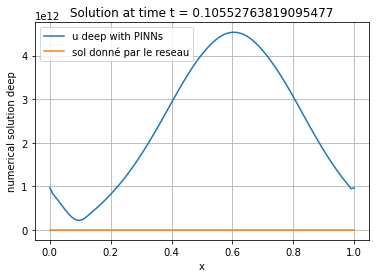

deep [4.01516564e+12 3.48468881e+12 3.13741725e+12 2.78302092e+12
 2.40422659e+12 2.01842965e+12 1.65380354e+12 1.33543291e+12
 1.08172199e+12 9.12893303e+11 8.54614807e+11 9.21517633e+11
 1.09546905e+12 1.32977754e+12 1.58070577e+12 1.83141855e+12
 2.08607127e+12 2.35098211e+12 2.62681451e+12 2.91213448e+12
 3.20689486e+12 3.51214903e+12 3.82898327e+12 4.15827608e+12
 4.50075958e+12 4.85701356e+12 5.22743239e+12 5.61220076e+12
 6.01131934e+12 6.42459241e+12 6.85162378e+12 7.29184993e+12
 7.74453225e+12 8.20875533e+12 8.68346054e+12 9.16742779e+12
 9.65925775e+12 1.01573874e+13 1.06600489e+13 1.11652343e+13
 1.16707070e+13 1.21739730e+13 1.26722824e+13 1.31627103e+13
 1.36422268e+13 1.41078243e+13 1.45567266e+13 1.49865622e+13
 1.53955171e+13 1.57824312e+13 1.61466747e+13 1.64878072e+13
 1.68050580e+13 1.70968202e+13 1.73603571e+13 1.75920280e+13
 1.77880012e+13 1.79451369e+13 1.80615972e+13 1.81368872e+13
 1.81713412e+13 1.81654566e+13 1.81194875e+13 1.80334752e+13
 1.79076187e+13 1.7

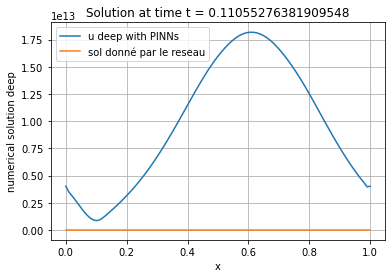

deep [1.66741779e+13 1.46379079e+13 1.32745657e+13 1.18814680e+13
 1.03751307e+13 8.80189953e+12 7.26664529e+12 5.88144436e+12
 4.72990893e+12 3.88184196e+12 3.42714114e+12 3.45278543e+12
 3.95706214e+12 4.80495118e+12 5.80402859e+12 6.82800366e+12
 7.85561322e+12 8.91258308e+12 1.00126782e+13 1.11518262e+13
 1.23259201e+13 1.35372710e+13 1.47906415e+13 1.60902537e+13
 1.74395740e+13 1.88415068e+13 2.02982622e+13 2.18111877e+13
 2.33808557e+13 2.50070190e+13 2.66885957e+13 2.84238035e+13
 3.02101341e+13 3.20443523e+13 3.39226345e+13 3.58405004e+13
 3.77927459e+13 3.97735072e+13 4.17760961e+13 4.37928525e+13
 4.58151775e+13 4.78333956e+13 4.98367323e+13 5.18136009e+13
 5.37518493e+13 5.56392421e+13 5.74643021e+13 5.92170402e+13
 6.08896548e+13 6.24770618e+13 6.39765842e+13 6.53867573e+13
 6.67053026e+13 6.79269444e+13 6.90418041e+13 7.00357555e+13
 7.08928835e+13 7.15990637e+13 7.21449339e+13 7.25267978e+13
 7.27450467e+13 7.28014456e+13 7.26970251e+13 7.24316778e+13
 7.20053990e+13 7.1

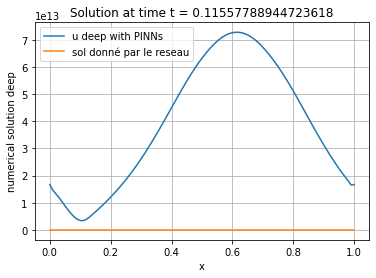

deep [6.92139222e+13 6.14096671e+13 5.60388950e+13 5.05637870e+13
 4.46121642e+13 3.82702759e+13 3.18914303e+13 2.59427308e+13
 2.08189652e+13 1.68016512e+13 1.41879803e+13 1.33413254e+13
 1.44600840e+13 1.72736186e+13 2.10907902e+13 2.52369725e+13
 2.94153064e+13 3.36551702e+13 3.80451048e+13 4.25972111e+13
 4.72867143e+13 5.21086067e+13 5.70791151e+13 6.22179366e+13
 6.75415367e+13 7.30638264e+13 7.87962216e+13 8.47467380e+13
 9.09201284e+13 9.73177005e+13 1.03937275e+14 1.10773723e+14
 1.17818886e+14 1.25061599e+14 1.32488265e+14 1.40082607e+14
 1.47825418e+14 1.55694826e+14 1.63665646e+14 1.71708775e+14
 1.79791283e+14 1.87875782e+14 1.95920229e+14 2.03878924e+14
 2.11703347e+14 2.19343958e+14 2.26753529e+14 2.33890160e+14
 2.40720374e+14 2.47221777e+14 2.53382540e+14 2.59197388e+14
 2.64659913e+14 2.69753499e+14 2.74443455e+14 2.78676263e+14
 2.82387481e+14 2.85515594e+14 2.88015432e+14 2.89864678e+14
 2.91059981e+14 2.91606655e+14 2.91508761e+14 2.90765245e+14
 2.89373444e+14 2.8

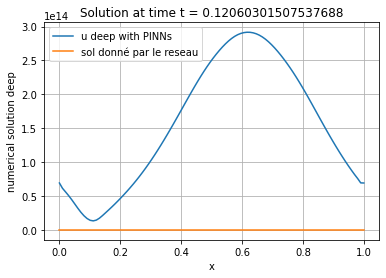

deep [2.87200345e+14 2.57340858e+14 2.36095641e+14 2.14540449e+14
 1.91122018e+14 1.65811609e+14 1.39657818e+14 1.14452665e+14
 9.19969960e+13 7.35911580e+13 6.02812497e+13 5.33559327e+13
 5.40243610e+13 6.22208030e+13 7.59573651e+13 9.23414864e+13
 1.09343864e+14 1.26474116e+14 1.44035553e+14 1.62230442e+14
 1.80995393e+14 2.00249673e+14 2.20019219e+14 2.40385018e+14
 2.61425234e+14 2.83205505e+14 3.05781629e+14 3.29196701e+14
 3.53480427e+14 3.78647961e+14 4.04699801e+14 4.31623965e+14
 4.59395758e+14 4.87977971e+14 5.17323267e+14 5.47373311e+14
 5.78057873e+14 6.09295936e+14 6.40993158e+14 6.73039454e+14
 7.05309210e+14 7.37658526e+14 7.69924004e+14 8.01926180e+14
 8.33472199e+14 8.64362451e+14 8.94403554e+14 9.23420622e+14
 9.51270579e+14 9.77854734e+14 1.00311954e+15 1.02704380e+15
 1.04961032e+15 1.07076927e+15 1.09040229e+15 1.10831133e+15
 1.12424162e+15 1.13793282e+15 1.14917630e+15 1.15785140e+15
 1.16392100e+15 1.16739537e+15 1.16828900e+15 1.16659642e+15
 1.16229877e+15 1.1

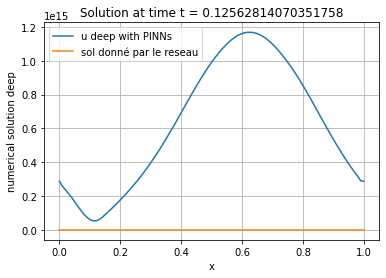

deep [1.19136219e+15 1.07734245e+15 9.92930398e+14 9.07795099e+14
 8.15812780e+14 7.15603231e+14 6.09710977e+14 5.04397650e+14
 4.07342492e+14 3.24794648e+14 2.61064120e+14 2.20478643e+14
 2.08143914e+14 2.26736880e+14 2.72228050e+14 3.34381933e+14
 4.02806321e+14 4.72374144e+14 5.42970682e+14 6.15752956e+14
 6.90900395e+14 7.67988023e+14 8.46874309e+14 9.27807222e+14
 1.01113808e+15 1.09717734e+15 1.18618943e+15 1.27839135e+15
 1.37394784e+15 1.47296268e+15 1.57547762e+15 1.68148139e+15
 1.79090903e+15 1.90364318e+15 2.01952397e+15 2.13834614e+15
 2.25985592e+15 2.38375568e+15 2.50969419e+15 2.63725697e+15
 2.76596686e+15 2.89527221e+15 3.02454051e+15 3.15306997e+15
 3.28009756e+15 3.40482285e+15 3.52645813e+15 3.64427733e+15
 3.75767215e+15 3.86620902e+15 3.96964285e+15 4.06787923e+15
 4.16087242e+15 4.24848213e+15 4.33031686e+15 4.40566033e+15
 4.47352779e+15 4.53284607e+15 4.58268563e+15 4.62243985e+15
 4.65185261e+15 4.67090430e+15 4.67963605e+15 4.67802265e+15
 4.66596456e+15 4.6

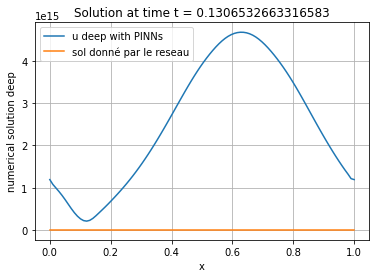

deep [4.94068410e+15 4.50628136e+15 4.16942014e+15 3.83173701e+15
 3.47032122e+15 3.07581666e+15 2.65185650e+15 2.21797748e+15
 1.80439402e+15 1.44014984e+15 1.14555789e+15 9.36195333e+14
 8.30343057e+14 8.44698887e+14 9.77747654e+14 1.20024005e+15
 1.46869811e+15 1.75066755e+15 2.03608189e+15 2.32794287e+15
 2.62898195e+15 2.93813787e+15 3.25391248e+15 3.57655528e+15
 3.90742416e+15 4.24796438e+15 4.59941921e+15 4.96283494e+15
 5.33906203e+15 5.72870310e+15 6.13209807e+15 6.54935994e+15
 6.98037409e+15 7.42480490e+15 7.88213710e+15 8.35166675e+15
 8.83249084e+15 9.32352747e+15 9.82347824e+15 1.03307909e+16
 1.08436609e+16 1.13599818e+16 1.18773149e+16 1.23929274e+16
 1.29038137e+16 1.34067798e+16 1.38986337e+16 1.43763784e+16
 1.48374428e+16 1.52799329e+16 1.57027254e+16 1.61053700e+16
 1.64877329e+16 1.68494503e+16 1.71892705e+16 1.75046623e+16
 1.77919001e+16 1.80466648e+16 1.82649432e+16 1.84438438e+16
 1.85818805e+16 1.86786681e+16 1.87342535e+16 1.87485145e+16
 1.87209856e+16 1.8

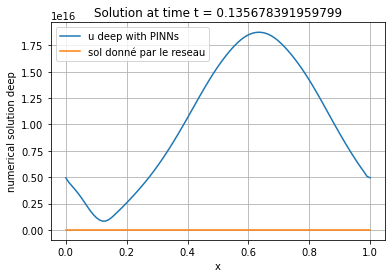

deep [2.04845059e+16 1.88337913e+16 1.74839601e+16 1.61381398e+16
 1.47149989e+16 1.31669922e+16 1.14853150e+16 9.72173146e+15
 7.98494842e+15 6.40129183e+15 5.07017394e+15 4.05749964e+15
 3.42556910e+15 3.24540085e+15 3.55284846e+15 4.28812360e+15
 5.29970268e+15 6.42768056e+15 7.58483693e+15 8.76014473e+15
 9.96719478e+15 1.12079749e+16 1.24752152e+16 1.37657924e+16
 1.50834454e+16 1.64344228e+16 1.78245548e+16 1.92587784e+16
 2.07412709e+16 2.22752438e+16 2.38628120e+16 2.55051144e+16
 2.72023187e+16 2.89536561e+16 3.07575926e+16 3.26118039e+16
 3.45131437e+16 3.64577315e+16 3.84408098e+16 4.04566005e+16
 4.24983110e+16 4.45579316e+16 4.66260966e+16 4.86922075e+16
 5.07444783e+16 5.27702234e+16 5.47565774e+16 5.66912401e+16
 5.85634158e+16 6.03648877e+16 6.20905353e+16 6.37381463e+16
 6.53072129e+16 6.67968948e+16 6.82033405e+16 6.95178101e+16
 7.07264949e+16 7.18123927e+16 7.27586540e+16 7.35520661e+16
 7.41848058e+16 7.46538915e+16 7.49588133e+16 7.50989075e+16
 7.50721204e+16 7.4

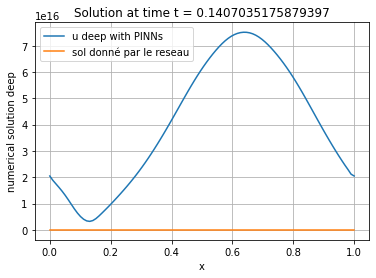

deep [8.49111395e+16 7.86571220e+16 7.32283808e+16 6.78383032e+16
 6.22147049e+16 5.61463195e+16 4.95226419e+16 4.24415196e+16
 3.52551307e+16 2.84712729e+16 2.25600442e+16 1.78395719e+16
 1.45398155e+16 1.29166068e+16 1.31984122e+16 1.53555807e+16
 1.89584967e+16 2.33539389e+16 2.80248991e+16 3.27773045e+16
 3.76282334e+16 4.26100018e+16 4.77036407e+16 5.28822999e+16
 5.81474210e+16 6.35218216e+16 6.90320368e+16 7.47012299e+16
 8.05492783e+16 8.65923539e+16 9.28421938e+16 9.93063572e+16
 1.05988234e+17 1.12887222e+17 1.19999439e+17 1.27317667e+17
 1.34831266e+17 1.42526567e+17 1.50386329e+17 1.58389197e+17
 1.66509740e+17 1.74717631e+17 1.82977045e+17 1.91247044e+17
 1.99481609e+17 2.07630595e+17 2.15642416e+17 2.23466888e+17
 2.31058983e+17 2.38383338e+17 2.45416815e+17 2.52148521e+17
 2.58575898e+17 2.64697310e+17 2.70501406e+17 2.75958707e+17
 2.81019030e+17 2.85616814e+17 2.89683057e+17 2.93159485e+17
 2.96007541e+17 2.98208923e+17 2.99757892e+17 3.00650556e+17
 3.00878049e+17 3.0

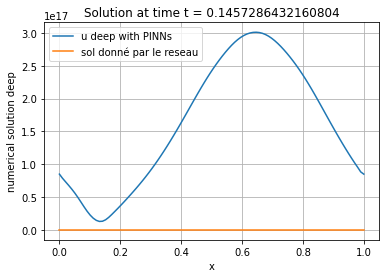

deep [3.51889482e+17 3.28274640e+17 3.06372731e+17 2.84683689e+17
 2.62364238e+17 2.38549979e+17 2.12581174e+17 1.84444995e+17
 1.55131473e+17 1.26512599e+17 1.00669038e+17 7.91880247e+16
 6.30741537e+16 5.32109565e+16 5.05731223e+16 5.56358124e+16
 6.75160349e+16 8.39730553e+16 1.02549572e+17 1.21778293e+17
 1.41339062e+17 1.61359613e+17 1.81848035e+17 2.02679439e+17
 2.23791277e+17 2.45240529e+17 2.67137773e+17 2.89590599e+17
 3.12692242e+17 3.36520974e+17 3.61137684e+17 3.86585761e+17
 4.12890650e+17 4.40060661e+17 4.68089974e+17 4.96958572e+17
 5.26632112e+17 5.57063610e+17 5.88191482e+17 6.19937501e+17
 6.52207032e+17 6.84885779e+17 7.17837260e+17 7.50903986e+17
 7.83907021e+17 8.16649056e+17 8.48924316e+17 8.80529243e+17
 9.11277293e+17 9.41017547e+17 9.69646580e+17 9.97111386e+17
 1.02339731e+18 1.04850177e+18 1.07239290e+18 1.09497357e+18
 1.11606480e+18 1.13541863e+18 1.15275879e+18 1.16783598e+18
 1.18046939e+18 1.19055908e+18 1.19806405e+18 1.20296112e+18
 1.20521191e+18 1.2

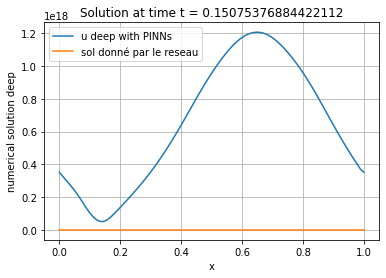

deep [1.45797128e+18 1.36913898e+18 1.28054845e+18 1.19290302e+18
 1.10389432e+18 1.01018656e+18 9.08596709e+17 7.97719936e+17
 6.79713576e+17 5.60829001e+17 4.49585614e+17 3.53614412e+17
 2.77902529e+17 2.25805639e+17 2.00840771e+17 2.06094089e+17
 2.41032483e+17 2.99362332e+17 3.71279564e+17 4.48573980e+17
 5.27649357e+17 6.08265660e+17 6.90712651e+17 7.74633380e+17
 8.59553477e+17 9.45462000e+17 1.03274316e+18 1.12187604e+18
 1.21329537e+18 1.30737108e+18 1.40440459e+18 1.50462646e+18
 1.60819068e+18 1.71517730e+18 1.82560508e+18 1.93943201e+18
 2.05655556e+18 2.17682009e+18 2.30000985e+18 2.42584143e+18
 2.55396522e+18 2.68395268e+18 2.81528601e+18 2.94736179e+18
 3.07948713e+18 3.21088913e+18 3.34075107e+18 3.46825200e+18
 3.59262431e+18 3.71322935e+18 3.82961013e+18 3.94151328e+18
 4.04885456e+18 4.15162808e+18 4.24974878e+18 4.34290385e+18
 4.43046626e+18 4.51151481e+18 4.58496620e+18 4.64978209e+18
 4.70514758e+18 4.75055669e+18 4.78576295e+18 4.81063182e+18
 4.82499425e+18 4.8

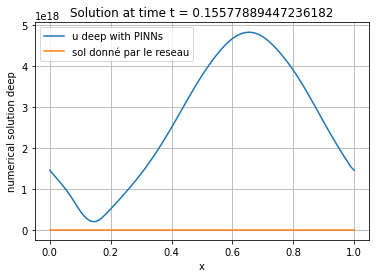

deep [6.03933444e+18 5.70657899e+18 5.34750899e+18 4.99203437e+18
 4.63536294e+18 4.26519753e+18 3.86776987e+18 3.43337331e+18
 2.96374163e+18 2.47725083e+18 2.00596131e+18 1.58418395e+18
 1.23732374e+18 9.80612990e+17 8.26339936e+17 7.87638905e+17
 8.70716871e+17 1.06260618e+18 1.33023512e+18 1.63589115e+18
 1.95510737e+18 2.28050838e+18 2.61256417e+18 2.95087813e+18
 3.29327420e+18 3.63858245e+18 3.98768384e+18 4.34251022e+18
 4.70505424e+18 5.07704543e+18 5.45992919e+18 5.85486953e+18
 6.26271120e+18 6.68398014e+18 7.11893469e+18 7.56757144e+18
 8.02962930e+18 8.50462231e+18 8.99181491e+18 9.49019523e+18
 9.99848304e+18 1.05150810e+19 1.10380334e+19 1.15650375e+19
 1.20934212e+19 1.26201700e+19 1.31420581e+19 1.36557934e+19
 1.41582379e+19 1.46467115e+19 1.51192186e+19 1.55745714e+19
 1.60123043e+19 1.64323694e+19 1.68345474e+19 1.72178515e+19
 1.75801211e+19 1.79179904e+19 1.82272913e+19 1.85038013e+19
 1.87439690e+19 1.89453692e+19 1.91066609e+19 1.92270950e+19
 1.93059088e+19 1.9

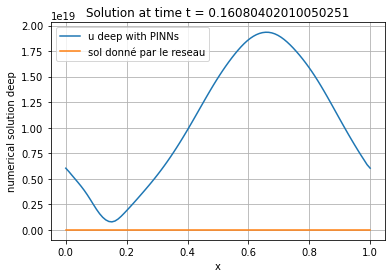

deep [2.50104429e+19 2.37698182e+19 2.23122237e+19 2.08661187e+19
 1.94303977e+19 1.79614786e+19 1.64037573e+19 1.47075325e+19
 1.28559208e+19 1.08927994e+19 8.92794472e+18 7.10413507e+18
 5.54552094e+18 4.33022992e+18 3.50650641e+18 3.12153136e+18
 3.21626388e+18 3.78160879e+18 4.72572154e+18 5.90166654e+18
 7.17943252e+18 8.49411873e+18 9.83349875e+18 1.11979289e+19
 1.25804295e+19 1.39727429e+19 1.53742517e+19 1.67913847e+19
 1.82328182e+19 1.97065723e+19 2.12194513e+19 2.27771203e+19
 2.43839477e+19 2.60429439e+19 2.77559472e+19 2.95236601e+19
 3.13456813e+19 3.32206487e+19 3.51461561e+19 3.71186607e+19
 3.91335269e+19 4.11848417e+19 4.32652546e+19 4.53660141e+19
 4.74768574e+19 4.95860771e+19 5.16809928e+19 5.37484732e+19
 5.57757739e+19 5.77517390e+19 5.96677532e+19 6.15183538e+19
 6.33010823e+19 6.50155005e+19 6.66610231e+19 6.82345836e+19
 6.97288441e+19 7.11316934e+19 7.24273708e+19 7.35990715e+19
 7.46317575e+19 7.55142987e+19 7.62398791e+19 7.68045111e+19
 7.72046835e+19 7.7

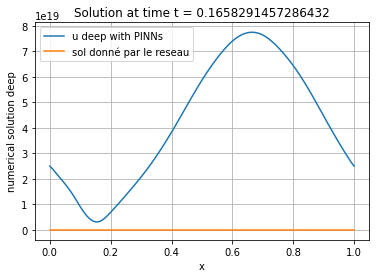

deep [1.03547489e+20 9.89461061e+19 9.30228508e+19 8.71259531e+19
 8.13232314e+19 7.54659704e+19 6.93400977e+19 6.27231549e+19
 5.54732334e+19 4.76490817e+19 3.95849206e+19 3.18276750e+19
 2.49437559e+19 1.93402867e+19 1.52466114e+19 1.28291183e+19
 1.22603211e+19 1.36196521e+19 1.67180238e+19 2.10686342e+19
 2.60935961e+19 3.13876491e+19 3.67976891e+19 4.23042113e+19
 4.78900376e+19 5.35169560e+19 5.91639293e+19 6.48445963e+19
 7.05929501e+19 7.64452904e+19 8.24333554e+19 8.85840454e+19
 9.49190331e+19 1.01454334e+20 1.08200853e+20 1.15164540e+20
 1.22346582e+20 1.29744029e+20 1.37349529e+20 1.45151018e+20
 1.53131955e+20 1.61270636e+20 1.69539585e+20 1.77905689e+20
 1.86329690e+20 1.94766309e+20 2.03165929e+20 2.11476450e+20
 2.19646434e+20 2.27629809e+20 2.35389784e+20 2.42901691e+20
 2.50153080e+20 2.57140700e+20 2.63862647e+20 2.70309420e+20
 2.76456387e+20 2.82260547e+20 2.87663241e+20 2.92598883e+20
 2.97005396e+20 3.00833488e+20 3.04050264e+20 3.06635394e+20
 3.08572513e+20 3.0

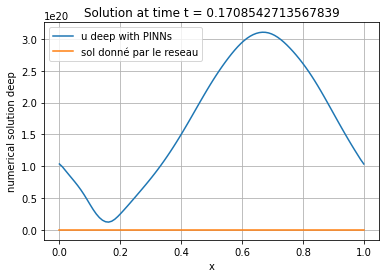

deep [4.28584751e+20 4.11617408e+20 3.87530892e+20 3.63442065e+20
 3.39907792e+20 3.16441329e+20 2.92247350e+20 2.66406340e+20
 2.38144026e+20 2.07280875e+20 1.74668141e+20 1.42218474e+20
 1.12323254e+20 8.70051348e+19 6.74859328e+19 5.44455906e+19
 4.84951613e+19 5.01647674e+19 5.93051086e+19 7.45825515e+19
 9.37993873e+19 1.14901451e+20 1.36740394e+20 1.58984618e+20
 1.81561432e+20 2.04333093e+20 2.27156786e+20 2.50016175e+20
 2.73020692e+20 2.96325291e+20 3.20076287e+20 3.44399660e+20
 3.69399759e+20 3.95157806e+20 4.21733119e+20 4.49163343e+20
 4.77465429e+20 5.06638402e+20 5.36662554e+20 5.67498519e+20
 5.99088426e+20 6.31353452e+20 6.64191556e+20 6.97478046e+20
 7.31063359e+20 7.64773100e+20 7.98413996e+20 8.31780383e+20
 8.64665883e+20 8.96881671e+20 9.28272255e+20 9.58728077e+20
 9.88188338e+20 1.01663235e+21 1.04405158e+21 1.07041604e+21
 1.09564355e+21 1.11958317e+21 1.14201965e+21 1.16270150e+21
 1.18137822e+21 1.19783804e+21 1.21192870e+21 1.22355057e+21
 1.23262717e+21 1.2

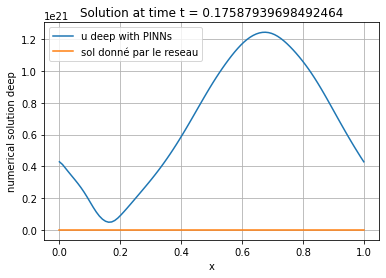

deep [1.77339550e+21 1.71123311e+21 1.61325605e+21 1.51473356e+21
 1.41901249e+21 1.32458251e+21 1.22857097e+21 1.12737469e+21
 1.01741177e+21 8.96632270e+20 7.66473958e+20 6.32928530e+20
 5.05300100e+20 3.92945284e+20 3.02391562e+20 2.37059824e+20
 1.99117380e+20 1.90746368e+20 2.12933673e+20 2.62946157e+20
 3.33644504e+20 4.16186427e+20 5.03898497e+20 5.93785107e+20
 6.85074308e+20 7.77285279e+20 8.69740655e+20 9.62067689e+20
 1.05448743e+21 1.14759238e+21 1.24203681e+21 1.33840562e+21
 1.43719150e+21 1.53879235e+21 1.64351420e+21 1.75156899e+21
 1.86307825e+21 1.97808525e+21 2.09655302e+21 2.21836179e+21
 2.34331480e+21 2.47112970e+21 2.60143045e+21 2.73375000e+21
 2.86752104e+21 3.00207460e+21 3.13666110e+21 3.27047268e+21
 3.40268613e+21 3.53253309e+21 3.65936277e+21 3.78269597e+21
 3.90224469e+21 4.01789033e+21 4.12958572e+21 4.23723084e+21
 4.34055145e+21 4.43902209e+21 4.53186242e+21 4.61812351e+21
 4.69681475e+21 4.76705031e+21 4.82814967e+21 4.87964142e+21
 4.92117043e+21 4.9

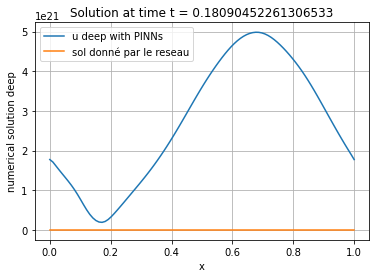

deep [7.33565700e+21 7.10955840e+21 6.71100997e+21 6.30776453e+21
 5.91756576e+21 5.53609086e+21 5.15321151e+21 4.75533962e+21
 4.32736036e+21 3.85724327e+21 3.34358073e+21 2.80239240e+21
 2.26681237e+21 1.77686993e+21 1.36554972e+21 1.05190234e+21
 8.45251256e+20 7.53092510e+20 7.82036219e+20 9.29706299e+20
 1.17686400e+21 1.49071356e+21 1.83887456e+21 2.20133058e+21
 2.57057293e+21 2.94405739e+21 3.31906612e+21 3.69311925e+21
 4.06589632e+21 4.43925432e+21 4.81593758e+21 5.19862122e+21
 5.58960559e+21 5.99079225e+21 6.40370232e+21 6.82945490e+21
 7.26877421e+21 7.72204042e+21 8.18928737e+21 8.67019762e+21
 9.16413052e+21 9.67009335e+21 1.01867138e+22 1.07122533e+22
 1.12445697e+22 1.17811077e+22 1.23189725e+22 1.28550062e+22
 1.33859430e+22 1.39086779e+22 1.44205120e+22 1.49193783e+22
 1.54039473e+22 1.58735870e+22 1.63280246e+22 1.67668950e+22
 1.71892723e+22 1.75933354e+22 1.79762840e+22 1.83345876e+22
 1.86644001e+22 1.89621021e+22 1.92247424e+22 1.94501612e+22
 1.96367283e+22 1.9

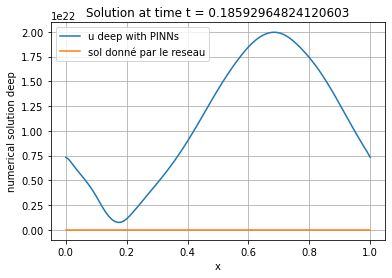

deep [3.03340178e+22 2.95183033e+22 2.78974857e+22 2.62465418e+22
 2.46532852e+22 2.31070851e+22 2.15730403e+22 2.00013742e+22
 1.83320051e+22 1.65073218e+22 1.44981134e+22 1.23354318e+22
 1.01255807e+22 8.02647858e+21 6.19277442e+21 4.72908362e+21
 3.68580988e+21 3.08952681e+21 2.96622879e+21 3.32763546e+21
 4.13468051e+21 5.28311617e+21 6.63790102e+21 8.08968386e+21
 9.58201210e+21 1.10948660e+22 1.26167527e+22 1.41355075e+22
 1.56447227e+22 1.71480103e+22 1.86556540e+22 2.01794664e+22
 2.17300873e+22 2.33164618e+22 2.49459434e+22 2.66241971e+22
 2.83551773e+22 3.01413206e+22 3.19835577e+22 3.38813173e+22
 3.58326596e+22 3.78341858e+22 3.98809503e+22 4.19665283e+22
 4.40828737e+22 4.62202663e+22 4.83675760e+22 5.05125142e+22
 5.26421961e+22 5.47441553e+22 5.68072953e+22 5.88228113e+22
 6.07847027e+22 6.26897764e+22 6.45365012e+22 6.63233949e+22
 6.80472509e+22 6.97017537e+22 7.12769285e+22 7.27598003e+22
 7.41356790e+22 7.53900854e+22 7.65105540e+22 7.74874713e+22
 7.83134715e+22 7.8

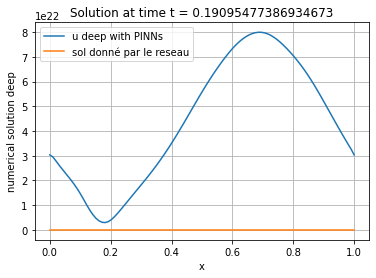

deep [1.25392533e+23 1.22476490e+23 1.15887904e+23 1.09129178e+23
 1.02616205e+23 9.63320168e+22 9.01592776e+22 8.39198442e+22
 7.73847167e+22 7.03057182e+22 6.24961771e+22 5.39573956e+22
 4.49846807e+22 3.61494264e+22 2.81214517e+22 2.14388493e+22
 1.63973892e+22 1.31199766e+22 1.16902566e+22 1.21858874e+22
 1.45701283e+22 1.85676318e+22 2.36904900e+22 2.94293967e+22
 3.54393728e+22 4.15650016e+22 4.77416185e+22 5.39157379e+22
 6.00446319e+22 6.61223592e+22 7.21805046e+22 7.82678427e+22
 8.44326861e+22 9.07167024e+22 9.71547504e+22 1.03774629e+23
 1.10596835e+23 1.17635189e+23 1.24896920e+23 1.32382784e+23
 1.40087699e+23 1.48000483e+23 1.56103610e+23 1.64373555e+23
 1.72780271e+23 1.81286955e+23 1.89850994e+23 1.98424791e+23
 2.06957769e+23 2.15400190e+23 2.23706798e+23 2.31840521e+23
 2.39774789e+23 2.47494121e+23 2.54990318e+23 2.62256796e+23
 2.69282002e+23 2.76043874e+23 2.82507031e+23 2.88624268e+23
 2.94340288e+23 2.99598245e+23 3.04346718e+23 3.08544020e+23
 3.12157447e+23 3.1

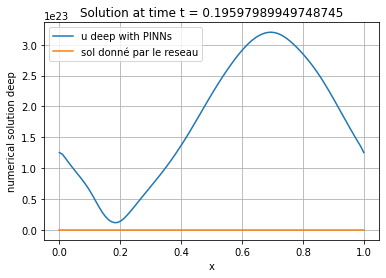

deep [5.18152918e+23 5.07836660e+23 4.81070812e+23 4.53412105e+23
 4.26770289e+23 4.01174830e+23 3.76242928e+23 3.51349902e+23
 3.25649622e+23 2.98141919e+23 2.67899664e+23 2.34514134e+23
 1.98613598e+23 1.62068896e+23 1.27556059e+23 9.76317332e+22
 7.39705368e+22 5.73035662e+22 4.79229887e+22 4.61065850e+22
 5.19835897e+22 6.50031188e+22 8.36515953e+22 1.05870981e+23
 1.29876379e+23 1.54632602e+23 1.79692362e+23 2.04802529e+23
 2.29744844e+23 2.54409347e+23 2.78856058e+23 3.03264926e+23
 3.27846929e+23 3.52794084e+23 3.78269580e+23 4.04406707e+23
 4.31307947e+23 4.59046710e+23 4.87667483e+23 5.17186658e+23
 5.47595488e+23 5.78859534e+23 6.10918130e+23 6.43686151e+23
 6.77052165e+23 7.10877522e+23 7.44999807e+23 7.79235488e+23
 8.13387036e+23 8.47257197e+23 8.80662802e+23 9.13449399e+23
 9.45501299e+23 9.76745873e+23 1.00714116e+24 1.03665628e+24
 1.06524747e+24 1.09283652e+24 1.11929793e+24 1.14446131e+24
 1.16812109e+24 1.19005783e+24 1.21006384e+24 1.22796261e+24
 1.24361159e+24 1.2

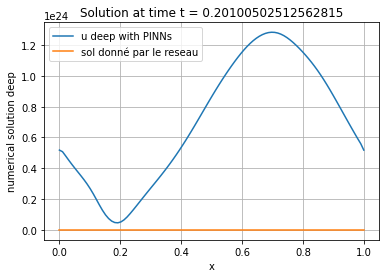

deep [2.14034082e+24 2.10427738e+24 1.99562457e+24 1.88250961e+24
 1.77350091e+24 1.66908433e+24 1.56806121e+24 1.46828455e+24
 1.36670250e+24 1.25946545e+24 1.14249526e+24 1.01290014e+24
 8.71092586e+23 7.22434044e+23 5.76745326e+23 4.45230247e+23
 3.36664897e+23 2.55617106e+23 2.03608551e+23 1.81398796e+23
 1.89807552e+23 2.28281641e+23 2.92920762e+23 3.76492914e+23
 4.71001695e+23 5.70559181e+23 6.72115156e+23 7.74221830e+23
 8.75844262e+23 9.76241061e+23 1.07530774e+24 1.17359089e+24
 1.27195030e+24 1.37125185e+24 1.47225281e+24 1.57558204e+24
 1.68173831e+24 1.79109551e+24 1.90390104e+24 2.02027960e+24
 2.14024684e+24 2.26370924e+24 2.39046400e+24 2.52020788e+24
 2.65253115e+24 2.78691442e+24 2.92274158e+24 3.05930816e+24
 3.19584652e+24 3.33157887e+24 3.46576916e+24 3.59778017e+24
 3.72711561e+24 3.85344371e+24 3.97655790e+24 4.09631045e+24
 4.21252651e+24 4.32492250e+24 4.43305135e+24 4.53630089e+24
 4.63391486e+24 4.72505879e+24 4.80890958e+24 4.88473580e+24
 4.95192759e+24 5.0

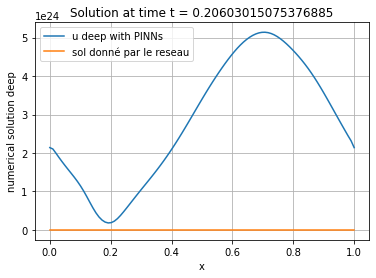

deep [8.83774075e+24 8.71339736e+24 8.27271440e+24 7.81050921e+24
 7.36452795e+24 6.93809395e+24 6.52768145e+24 6.12607525e+24
 5.72248760e+24 5.30258828e+24 4.84971718e+24 4.34894567e+24
 3.79470641e+24 3.19920591e+24 2.59517443e+24 2.02789788e+24
 1.53963637e+24 1.15715079e+24 8.90819548e+23 7.43132304e+23
 7.16390882e+23 8.11825655e+23 1.02180701e+24 1.32451404e+24
 1.68864616e+24 2.08518145e+24 2.49551359e+24 2.91038586e+24
 3.32454887e+24 3.73405753e+24 4.13703194e+24 4.53451646e+24
 4.92964510e+24 5.32616192e+24 5.72753873e+24 6.13671151e+24
 6.55605984e+24 6.98743110e+24 7.43212433e+24 7.89090185e+24
 8.36404937e+24 8.85138480e+24 9.35226704e+24 9.86563893e+24
 1.03900103e+25 1.09234485e+25 1.14636282e+25 1.20078583e+25
 1.25531699e+25 1.30965133e+25 1.36349508e+25 1.41658773e+25
 1.46871916e+25 1.51974119e+25 1.56955539e+25 1.61809113e+25
 1.66527529e+25 1.71100201e+25 1.75511048e+25 1.79738108e+25
 1.83753788e+25 1.87526760e+25 1.91024954e+25 1.94218656e+25
 1.97082240e+25 1.9

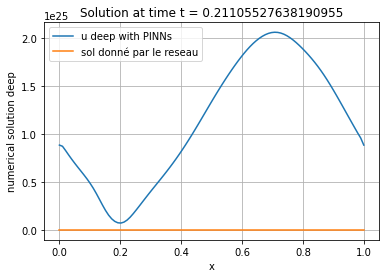

deep [3.64777422e+25 3.60558699e+25 3.42701925e+25 3.23835113e+25
 3.05596294e+25 2.88169598e+25 2.71462145e+25 2.55238233e+25
 2.39123624e+25 2.22598226e+25 2.05014685e+25 1.85702284e+25
 1.64214294e+25 1.40681244e+25 1.16065978e+25 9.20519250e+24
 7.05121150e+24 5.28771787e+24 3.98475506e+24 3.15913912e+24
 2.81378794e+24 2.95543342e+24 3.57599274e+24 4.62094801e+24
 5.98353542e+24 7.53847632e+24 9.18607091e+24 1.08684942e+25
 1.25556833e+25 1.42277860e+25 1.58718890e+25 1.74863445e+25
 1.90806089e+25 2.06697750e+25 2.22693804e+25 2.38930138e+25
 2.55518728e+25 2.72548777e+25 2.90085951e+25 3.08172522e+25
 3.26829826e+25 3.46058994e+25 3.65841699e+25 3.86142244e+25
 4.06907204e+25 4.28065242e+25 4.49529109e+25 4.71196505e+25
 4.92953173e+25 5.14680191e+25 5.36261082e+25 5.57590222e+25
 5.78579710e+25 5.99164604e+25 6.19299298e+25 6.38950407e+25
 6.58086315e+25 6.76666204e+25 6.94631360e+25 7.11902826e+25
 7.28380455e+25 7.43947920e+25 7.58482123e+25 7.71864506e+25
 7.83989260e+25 7.9

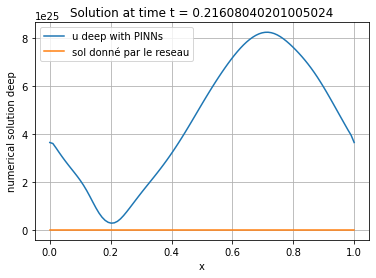

deep [1.50500656e+26 1.49096371e+26 1.41867872e+26 1.34175713e+26
 1.26721749e+26 1.19598372e+26 1.12786589e+26 1.06212376e+26
 9.97484727e+25 9.32099402e+25 8.63541034e+25 7.89032378e+25
 7.06169793e+25 6.14223670e+25 5.15504191e+25 4.15710791e+25
 3.22497691e+25 2.42848646e+25 1.81028422e+25 1.38466594e+25
 1.15202823e+25 1.11272340e+25 1.26751926e+25 1.60610357e+25
 2.09727803e+25 2.69356386e+25 3.34792804e+25 4.02742200e+25
 4.71383943e+25 5.39667895e+25 6.06879621e+25 6.72703202e+25
 7.37321552e+25 8.01279977e+25 8.65244109e+25 9.29834251e+25
 9.95572471e+25 1.06288227e+26 1.13208646e+26 1.20340669e+26
 1.27697258e+26 1.35282583e+26 1.43092496e+26 1.51115528e+26
 1.59332900e+26 1.67718548e+26 1.76239956e+26 1.84858446e+26
 1.93530268e+26 2.02209299e+26 2.10849646e+26 2.19408825e+26
 2.27850458e+26 2.36146546e+26 2.44276449e+26 2.52224640e+26
 2.59977181e+26 2.67517821e+26 2.74824707e+26 2.81869263e+26
 2.88615238e+26 2.95019801e+26 3.01036319e+26 3.06618246e+26
 3.11722608e+26 3.1

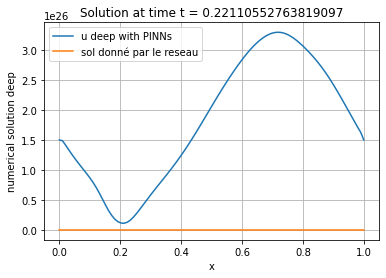

deep [6.20680674e+26 6.16112317e+26 5.86881022e+26 5.55560123e+26
 5.25123862e+26 4.96009207e+26 4.68208089e+26 4.41501678e+26
 4.15467556e+26 3.89459931e+26 3.62593085e+26 3.33777821e+26
 3.01910667e+26 2.66303507e+26 2.27272959e+26 1.86533804e+26
 1.46965184e+26 1.11697090e+26 8.30587095e+25 6.21143899e+25
 4.90059069e+25 4.36325213e+25 4.60053800e+25 5.60107039e+25
 7.28990788e+25 9.51025115e+25 1.20662199e+26 1.47900420e+26
 1.75750195e+26 2.03614332e+26 2.31116548e+26 2.58033203e+26
 2.84338848e+26 3.10197656e+26 3.35875569e+26 3.61648398e+26
 3.87757301e+26 4.14401026e+26 4.41734990e+26 4.69871119e+26
 4.98881107e+26 5.28798190e+26 5.59619742e+26 5.91312008e+26
 6.23810813e+26 6.57022204e+26 6.90825987e+26 7.25076803e+26
 7.59608025e+26 7.94241743e+26 8.28798246e+26 8.63107932e+26
 8.97021727e+26 9.30420666e+26 9.63213170e+26 9.95328298e+26
 1.02670409e+27 1.05727403e+27 1.08695494e+27 1.11564232e+27
 1.14320482e+27 1.16948568e+27 1.19431018e+27 1.21749820e+27
 1.23887786e+27 1.2

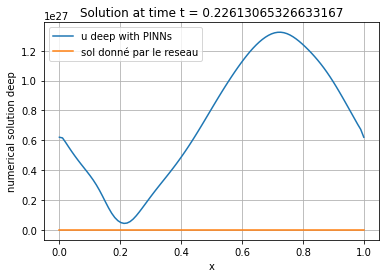

deep [2.55866385e+27 2.54421547e+27 2.42612968e+27 2.29877394e+27
 2.17462952e+27 2.05568120e+27 1.94214770e+27 1.83344715e+27
 1.72822224e+27 1.62425912e+27 1.51839207e+27 1.40651045e+27
 1.28398324e+27 1.14693965e+27 9.94484639e+26 8.30910098e+26
 6.66103039e+26 5.12989258e+26 3.83100474e+26 2.83208789e+26
 2.15197918e+26 1.78543260e+26 1.72782396e+26 1.97867392e+26
 2.52449842e+26 3.32117078e+26 4.29687316e+26 5.37558194e+26
 6.49972711e+26 7.63464114e+26 8.75991433e+26 9.86269473e+26
 1.09376596e+27 1.19880503e+27 1.30234239e+27 1.40555043e+27
 1.50952590e+27 1.61519367e+27 1.72329069e+27 1.83436704e+27
 1.94879807e+27 2.06679091e+27 2.18839692e+27 2.31353382e+27
 2.44199167e+27 2.57343787e+27 2.70743267e+27 2.84343362e+27
 2.98080976e+27 3.11887870e+27 3.25694098e+27 3.39432438e+27
 3.53042359e+27 3.66473955e+27 3.79687301e+27 3.92650529e+27
 4.05336091e+27 4.17716183e+27 4.29758405e+27 4.41423987e+27
 4.52665129e+27 4.63424651e+27 4.73637645e+27 4.83235283e+27
 4.92149790e+27 5.0

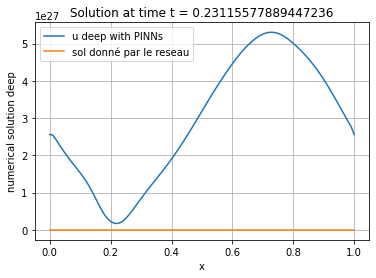

deep [1.05431224e+28 1.04990224e+28 1.00224832e+28 9.50538414e+27
 8.99964382e+27 8.51400954e+27 8.05026924e+27 7.60720319e+27
 7.18065383e+27 6.76319338e+27 6.34370722e+27 5.90711357e+27
 5.43508398e+27 4.90945269e+27 4.31967380e+27 3.67262444e+27
 2.99864439e+27 2.34689660e+27 1.76964239e+27 1.30473328e+27
 9.68158386e+26 7.60040866e+26 6.76411497e+26 7.15991912e+26
 8.77253147e+26 1.15012784e+27 1.51172380e+27 1.93146368e+27
 2.38129830e+27 2.84190643e+27 3.30180417e+27 3.75397624e+27
 4.19453339e+27 4.62309972e+27 5.04256330e+27 5.45757484e+27
 5.87298336e+27 6.29305019e+27 6.72123342e+27 7.16018279e+27
 7.61179241e+27 8.07722343e+27 8.55695766e+27 9.05089788e+27
 9.55840592e+27 1.00783344e+28 1.06090957e+28 1.11486827e+28
 1.16947216e+28 1.22446104e+28 1.27956436e+28 1.33451752e+28
 1.38907685e+28 1.44303538e+28 1.49622171e+28 1.54849494e+28
 1.59973321e+28 1.64981864e+28 1.69862227e+28 1.74599779e+28
 1.79176986e+28 1.83572993e+28 1.87763840e+28 1.91723497e+28
 1.95425578e+28 1.9

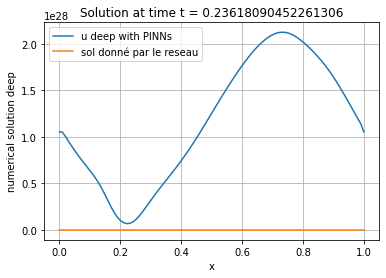

deep [4.34242166e+28 4.32957138e+28 4.13745781e+28 3.92781397e+28
 3.72206493e+28 3.52397422e+28 3.33458218e+28 3.15381523e+28
 2.98049579e+28 2.81220096e+28 2.64509541e+28 2.47376402e+28
 2.29124447e+28 2.08980995e+28 1.86323274e+28 1.61054448e+28
 1.33961026e+28 1.06753538e+28 8.16123156e+27 6.04391802e+27
 4.43046425e+27 3.34398618e+27 2.76643591e+27 2.68235654e+27
 3.08855428e+27 3.96827167e+27 5.25992539e+27 6.85517199e+27
 8.63153916e+27 1.04894185e+28 1.23644068e+28 1.42178637e+28
 1.60266870e+28 1.77819223e+28 1.94894768e+28 2.11660024e+28
 2.28319739e+28 2.45066920e+28 2.62062467e+28 2.79432201e+28
 2.97269206e+28 3.15634787e+28 3.34560615e+28 3.54053096e+28
 3.74095489e+28 3.94649720e+28 4.15659506e+28 4.37051356e+28
 4.58736626e+28 4.80616756e+28 5.02587746e+28 5.24546165e+28
 5.46394709e+28 5.68048454e+28 5.89434799e+28 6.10492368e+28
 6.31167664e+28 6.51410330e+28 6.71168080e+28 6.90384675e+28
 7.08995089e+28 7.26923020e+28 7.44080327e+28 7.60369387e+28
 7.75688595e+28 7.8

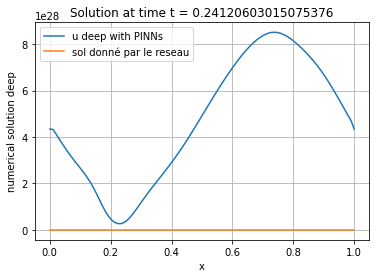

deep [1.78770959e+29 1.78419522e+29 1.70682267e+29 1.62195662e+29
 1.53837414e+29 1.45766238e+29 1.38035001e+29 1.30656054e+29
 1.23600747e+29 1.16793180e+29 1.10103551e+29 1.03340856e+29
 9.62483933e+28 8.85175818e+28 7.98494527e+28 7.00834414e+28
 5.93601904e+28 4.82140332e+28 3.74830498e+28 2.80388975e+28
 2.04952170e+28 1.50887724e+28 1.17853171e+28 1.04837913e+28
 1.11417660e+28 1.37401273e+28 1.81478637e+28 2.40329201e+28
 3.09191856e+28 3.83399481e+28 4.59506882e+28 5.35364440e+28
 6.09677623e+28 6.81769884e+28 7.51593263e+28 8.19653164e+28
 8.86757114e+28 9.53753661e+28 1.02138322e+29 1.09023722e+29
 1.16076437e+29 1.23327587e+29 1.30795404e+29 1.38487053e+29
 1.46399711e+29 1.54521522e+29 1.62833037e+29 1.71307716e+29
 1.79912755e+29 1.88611089e+29 1.97363009e+29 2.06128363e+29
 2.14868599e+29 2.23549206e+29 2.32139806e+29 2.40614020e+29
 2.48948579e+29 2.57121917e+29 2.65112529e+29 2.72898406e+29
 2.80455103e+29 2.87754531e+29 2.94764286e+29 3.01447965e+29
 3.07766798e+29 3.1

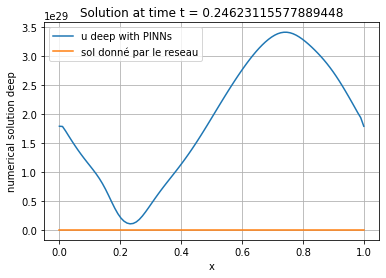

deep [7.35629826e+29 7.34753750e+29 7.03622402e+29 6.69319800e+29
 6.35417576e+29 6.02573616e+29 5.71036860e+29 5.40912133e+29
 5.12154506e+29 4.84540860e+29 4.57642679e+29 4.30797224e+29
 4.03079023e+29 3.73308394e+29 3.40196373e+29 3.02742326e+29
 2.60870785e+29 2.16009630e+29 1.71110692e+29 1.29847236e+29
 9.53506321e+28 6.93040381e+28 5.19547143e+28 4.28562124e+28
 4.16362257e+28 4.82096084e+28 6.23849537e+28 8.33167875e+28
 1.09376991e+29 1.38597119e+29 1.69268696e+29 2.00220127e+29
 2.30732827e+29 2.60393260e+29 2.89052813e+29 3.16817981e+29
 3.43977132e+29 3.70886397e+29 3.97880105e+29 4.25233752e+29
 4.53160716e+29 4.81814648e+29 5.11293330e+29 5.41646118e+29
 5.72878910e+29 6.04959023e+29 6.37821781e+29 6.71373087e+29
 7.05492918e+29 7.40043058e+29 7.74872999e+29 8.09827977e+29
 8.44756411e+29 8.79519340e+29 9.13991041e+29 9.48059529e+29
 9.81624583e+29 1.01459393e+30 1.04687829e+30 1.07839007e+30
 1.10903601e+30 1.13871179e+30 1.16729798e+30 1.19465926e+30
 1.22064873e+30 1.2

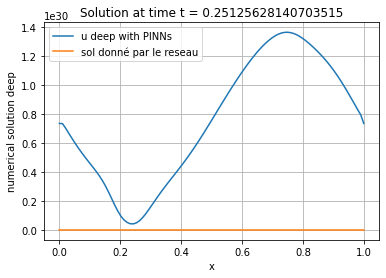

deep [3.02561562e+30 3.02373615e+30 2.89859407e+30 2.76015304e+30
 2.62285796e+30 2.48939478e+30 2.36087742e+30 2.23792119e+30
 2.12060644e+30 2.00834833e+30 1.89978063e+30 1.79264429e+30
 1.68366182e+30 1.56846309e+30 1.44185411e+30 1.29891682e+30
 1.13722752e+30 9.59562704e+29 7.75294415e+29 5.98686610e+29
 4.44257452e+29 3.21926463e+29 2.35130783e+29 1.82715107e+29
 1.62465969e+29 1.73374126e+29 2.15229156e+29 2.86402314e+29
 3.82119174e+29 4.94979406e+29 6.17253161e+29 7.42883152e+29
 8.67921113e+29 9.90005192e+29 1.10796681e+30 1.22174774e+30
 1.33222683e+30 1.44080173e+30 1.54893550e+30 1.65789538e+30
 1.76868595e+30 1.88205107e+30 1.99849234e+30 2.11830004e+30
 2.24157478e+30 2.36825078e+30 2.49812610e+30 2.63087575e+30
 2.76606695e+30 2.90318955e+30 3.04167777e+30 3.18093956e+30
 3.32038353e+30 3.45945493e+30 3.59763875e+30 3.73446489e+30
 3.86950589e+30 4.00236845e+30 4.13267958e+30 4.26008619e+30
 4.38422693e+30 4.50470999e+30 4.62109297e+30 4.73287298e+30
 4.83949594e+30 4.9

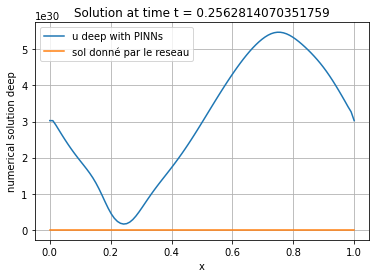

deep [1.24381089e+31 1.24351011e+31 1.19325120e+31 1.13746137e+31
 1.08194987e+31 1.02779864e+31 9.75487528e+30 9.25329725e+30
 8.77452947e+30 8.31740235e+30 7.87778597e+30 7.44814818e+30
 7.01706467e+30 6.56871924e+30 6.08313084e+30 5.53880400e+30
 4.91969018e+30 4.22597939e+30 3.48339317e+30 2.74275728e+30
 2.06586997e+30 1.50418840e+30 1.08398620e+30 8.07098360e+29
 6.63817206e+29 6.46251810e+29 7.52569026e+29 9.80917293e+29
 1.31995390e+30 1.74529502e+30 2.22538147e+30 2.73116549e+30
 3.24165919e+30 3.74371416e+30 4.22999562e+30 4.69801764e+30
 5.14967480e+30 5.58994890e+30 6.02494800e+30 6.46038071e+30
 6.90093005e+30 7.35014768e+30 7.81053000e+30 8.28365305e+30
 8.77026537e+30 9.27039287e+30 9.78347572e+30 1.03084349e+31
 1.08437404e+31 1.13875334e+31 1.19377073e+31 1.24920163e+31
 1.30481708e+31 1.36039751e+31 1.41573392e+31 1.47063102e+31
 1.52490821e+31 1.57839873e+31 1.63094641e+31 1.68240738e+31
 1.73263971e+31 1.78149439e+31 1.82880626e+31 1.87438797e+31
 1.91803097e+31 1.9

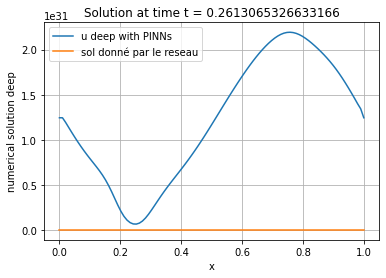

deep [5.11063189e+31 5.11044544e+31 4.90877958e+31 4.68428400e+31
 4.46020179e+31 4.24083980e+31 4.02820292e+31 3.82376347e+31
 3.62837600e+31 3.44201342e+31 3.26353604e+31 3.09050770e+31
 2.91901111e+31 2.74342480e+31 2.55631284e+31 2.34893535e+31
 2.11320788e+31 1.84552445e+31 1.55123122e+31 1.24671094e+31
 9.56201479e+30 7.03845479e+30 5.05612701e+30 3.66365169e+30
 2.83241593e+30 2.51755361e+30 2.69798041e+30 3.37197038e+30
 4.52077650e+30 6.07638936e+30 7.92402063e+30 9.93632602e+30
 1.20079512e+31 1.40675582e+31 1.60726355e+31 1.80029336e+31
 1.98577650e+31 2.16523740e+31 2.34106190e+31 2.51573809e+31
 2.69141836e+31 2.86978047e+31 3.05204099e+31 3.23901500e+31
 3.43115719e+31 3.62860741e+31 3.83125121e+31 4.03875274e+31
 4.25058613e+31 4.46608531e+31 4.68447525e+31 4.90491177e+31
 5.12651600e+31 5.34842610e+31 5.56980155e+31 5.78983874e+31
 6.00778176e+31 6.22292767e+31 6.43462289e+31 6.64227712e+31
 6.84532590e+31 7.04319538e+31 7.23526310e+31 7.42082765e+31
 7.59910336e+31 7.7

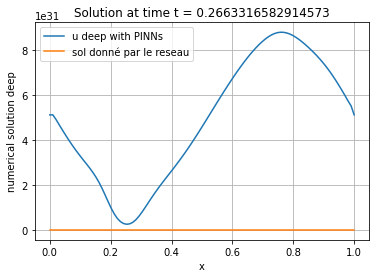

deep [2.09878172e+32 2.09880797e+32 2.01796178e+32 1.92775605e+32
 1.83744731e+32 1.74873236e+32 1.66242768e+32 1.57918951e+32
 1.49947980e+32 1.42345152e+32 1.35084468e+32 1.28090643e+32
 1.21231990e+32 1.14311772e+32 1.07059903e+32 9.91380578e+31
 9.01879296e+31 7.99531977e+31 6.84614102e+31 5.61730880e+31
 4.39615751e+31 3.28649974e+31 2.37264825e+31 1.69527516e+31
 1.25367314e+31 1.02815115e+31 1.00311027e+31 1.17496988e+31
 1.54269039e+31 2.09150246e+31 2.78503091e+31 3.57285466e+31
 4.40593048e+31 5.24716794e+31 6.07289323e+31 6.87013016e+31
 7.63467817e+31 8.36988605e+31 9.08423233e+31 9.78805310e+31
 1.04910188e+32 1.12009660e+32 1.19237361e+32 1.26634110e+32
 1.34225033e+32 1.42021539e+32 1.50023925e+32 1.58222953e+32
 1.66601303e+32 1.75135652e+32 1.83797904e+32 1.92556681e+32
 2.01378551e+32 2.10229977e+32 2.19077446e+32 2.27888192e+32
 2.36630847e+32 2.45275980e+32 2.53796295e+32 2.62167470e+32
 2.70366842e+32 2.78372045e+32 2.86159370e+32 2.93702367e+32
 3.00971348e+32 3.0

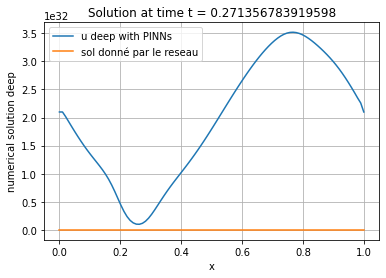

deep [8.61438825e+32 8.61373370e+32 8.28992792e+32 7.92798209e+32
 7.56460590e+32 7.20642663e+32 6.85669639e+32 6.51822607e+32
 6.19326745e+32 5.88302965e+32 5.58721655e+32 5.30366913e+32
 5.02807792e+32 4.75366212e+32 4.47079125e+32 4.16681757e+32
 3.82704009e+32 3.43820125e+32 2.99503392e+32 2.50765290e+32
 2.00461293e+32 1.52703505e+32 1.11496990e+32 7.94010563e+31
 5.70792250e+31 4.39053070e+31 3.90128249e+31 4.19909127e+31
 5.28402352e+31 7.13739824e+31 9.66344298e+31 1.26846881e+32
 1.59922574e+32 1.94047365e+32 2.27952222e+32 2.60878041e+32
 2.92472816e+32 3.22729058e+32 3.51906034e+32 3.80405449e+32
 4.08647013e+32 4.36990912e+32 4.65714292e+32 4.95017105e+32
 5.25030780e+32 5.55827016e+32 5.87428857e+32 6.19817894e+32
 6.52941015e+32 6.86719235e+32 7.21052694e+32 7.55826326e+32
 7.90914273e+32 8.26187205e+32 8.61512659e+32 8.96758163e+32
 9.31794646e+32 9.66499728e+32 1.00075978e+33 1.03447445e+33
 1.06755210e+33 1.09990463e+33 1.13144077e+33 1.16205994e+33
 1.19164933e+33 1.2

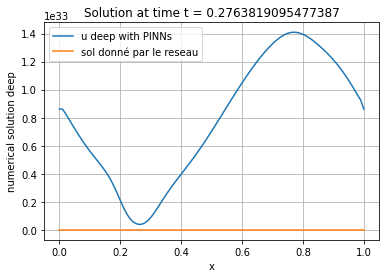

deep [3.53376369e+33 3.53276641e+33 3.40320146e+33 3.25817659e+33
 3.11219551e+33 2.96782895e+33 2.82634746e+33 2.68891712e+33
 2.55656738e+33 2.42999416e+33 2.30935804e+33 2.19412290e+33
 2.08293301e+33 1.97349275e+33 1.86241995e+33 1.74510483e+33
 1.61582070e+33 1.46860623e+33 1.29938587e+33 1.10903360e+33
 9.05754139e+32 7.04526673e+32 5.22751419e+32 3.74198218e+32
 2.65101834e+32 1.94725157e+32 1.59249109e+32 1.55723004e+32
 1.83487649e+32 2.42677593e+32 3.31451103e+32 4.44412654e+32
 5.73530268e+32 7.10581329e+32 8.49096427e+32 9.84859599e+32
 1.11558129e+33 1.24054743e+33 1.36032763e+33 1.47634253e+33
 1.59032666e+33 1.70389484e+33 1.81834489e+33 1.93464104e+33
 2.05344689e+33 2.17516573e+33 2.29998776e+33 2.42792206e+33
 2.55882719e+33 2.69244928e+33 2.82844302e+33 2.96639375e+33
 3.10583343e+33 3.24626827e+33 3.38717921e+33 3.52803518e+33
 3.66830929e+33 3.80749615e+33 3.94512481e+33 4.08078133e+33
 4.21409347e+33 4.34471132e+33 4.47228003e+33 4.59641353e+33
 4.71668019e+33 4.8

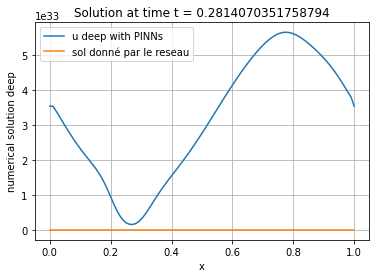

deep [1.44876265e+34 1.44791385e+34 1.39612484e+34 1.33809755e+34
 1.27954309e+34 1.22145377e+34 1.16431778e+34 1.10860600e+34
 1.05476805e+34 1.00315519e+34 9.53934583e+33 9.07016882e+33
 8.62001619e+33 8.18129895e+33 7.74230923e+33 7.28656061e+33
 6.79254793e+33 6.23558515e+33 5.59398182e+33 4.86024910e+33
 4.05327836e+33 3.22271997e+33 2.43818129e+33 1.76592539e+33
 1.24675553e+33 8.89242124e+32 6.80595729e+32 6.04631087e+32
 6.53688663e+32 8.28249489e+32 1.12706646e+33 1.53686608e+33
 2.03029093e+33 2.57324549e+33 3.13480864e+33 3.69265940e+33
 4.23334057e+33 4.75073018e+33 5.24467966e+33 5.71950554e+33
 6.18191036e+33 6.63887480e+33 7.09636537e+33 7.55897099e+33
 8.02996355e+33 8.51147569e+33 9.00470756e+33 9.51006581e+33
 1.00272995e+34 1.05556647e+34 1.10940152e+34 1.16408911e+34
 1.21945784e+34 1.27532126e+34 1.33147785e+34 1.38771646e+34
 1.44382366e+34 1.49959218e+34 1.55482777e+34 1.60935999e+34
 1.66303730e+34 1.71571982e+34 1.76726844e+34 1.81753366e+34
 1.86634898e+34 1.9

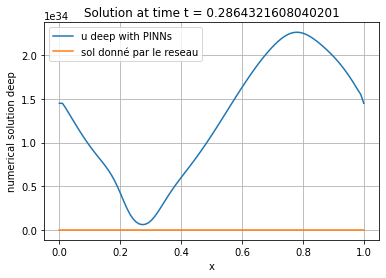

deep [5.93600049e+34 5.93026341e+34 5.72349081e+34 5.49164052e+34
 5.25713372e+34 5.02379027e+34 4.79346067e+34 4.56800233e+34
 4.34931024e+34 4.13902868e+34 3.93819705e+34 3.74693111e+34
 3.56417565e+34 3.38750681e+34 3.21293722e+34 3.03465897e+34
 2.84480715e+34 2.63370426e+34 2.39144866e+34 2.11159980e+34
 1.79632693e+34 1.46019160e+34 1.12882188e+34 8.31311976e+33
 5.90068018e+33 4.14529519e+33 3.02462123e+33 2.46689523e+33
 2.41799147e+33 2.86622494e+33 3.81841220e+33 5.25318547e+33
 7.09097792e+33 9.20431368e+33 1.14563974e+34 1.37355095e+34
 1.59672894e+34 1.81115056e+34 2.01556417e+34 2.21089846e+34
 2.39950771e+34 2.58426101e+34 2.76782782e+34 2.95235983e+34
 3.13944280e+34 3.33016194e+34 3.52519358e+34 3.72486651e+34
 3.92922084e+34 4.13807870e+34 4.35108437e+34 4.56774085e+34
 4.78743240e+34 5.00946460e+34 5.23306273e+34 5.45739431e+34
 5.68160146e+34 5.90483968e+34 6.12631211e+34 6.34531900e+34
 6.56124292e+34 6.77352267e+34 6.98160907e+34 7.18491863e+34
 7.38280404e+34 7.5

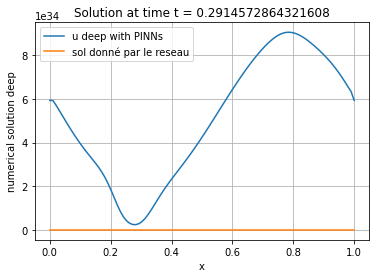

deep [2.43062239e+35 2.42721034e+35 2.34475837e+35 2.25225540e+35
 2.15848009e+35 2.06490220e+35 1.97221605e+35 1.88113956e+35
 1.79244823e+35 1.70687311e+35 1.62495959e+35 1.54693015e+35
 1.47257261e+35 1.40115331e+35 1.33134279e+35 1.26112289e+35
 1.18767272e+35 1.10734170e+35 1.01599029e+35 9.10081187e+34
 7.88592908e+34 6.55020662e+34 5.17971539e+34 3.89200436e+34
 2.79637331e+34 1.95745768e+34 1.38537583e+34 1.05515141e+34
 9.37282903e+33 1.01792395e+34 1.29860502e+34 1.78002491e+34
 2.44414151e+34 3.24895028e+34 4.13913241e+34 5.06241345e+34
 5.97992109e+34 6.86797753e+34 7.71581160e+34 8.52296001e+34
 9.29649259e+34 1.00474177e+35 1.07872272e+35 1.15258050e+35
 1.22707232e+35 1.30273642e+35 1.37993096e+35 1.45886181e+35
 1.53960799e+35 1.62215156e+35 1.70639545e+35 1.79217896e+35
 1.87928678e+35 1.96746450e+35 2.05641763e+35 2.14582085e+35
 2.23533194e+35 2.32460919e+35 2.41332745e+35 2.50120047e+35
 2.58797698e+35 2.67343128e+35 2.75734560e+35 2.83949076e+35
 2.91961321e+35 2.9

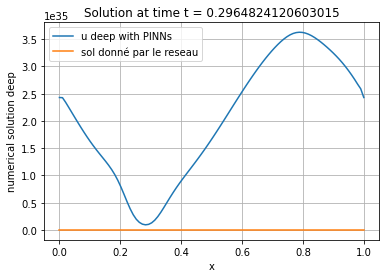

deep [9.94621191e+35 9.92753192e+35 9.59921037e+35 9.23069565e+35
 8.85627507e+35 8.48161384e+35 8.10930181e+35 7.74206616e+35
 7.38300103e+35 7.03523273e+35 6.70137764e+35 6.38296811e+35
 6.07995447e+35 5.79031343e+35 5.50974484e+35 5.23133963e+35
 4.94513174e+35 4.63772579e+35 4.29278777e+35 3.89390959e+35
 3.43099804e+35 2.90890767e+35 2.35336923e+35 1.80812153e+35
 1.32167963e+35 9.30334512e+34 6.48174584e+34 4.69862406e+34
 3.82227171e+34 3.75568546e+34 4.47865800e+34 6.00934445e+34
 8.32602487e+34 1.13122659e+35 1.47668279e+35 1.84636166e+35
 2.22114361e+35 2.58803295e+35 2.93993917e+35 3.27459950e+35
 3.59347302e+35 3.90038635e+35 4.20003388e+35 4.49682477e+35
 4.79431389e+35 5.09512124e+35 5.40107173e+35 5.71332113e+35
 6.03246760e+35 6.35867747e+35 6.69176291e+35 7.03124906e+35
 7.37641173e+35 7.72633883e+35 8.07992582e+35 8.43591343e+35
 8.79294724e+35 9.14965385e+35 9.50471408e+35 9.85696194e+35
 1.02053768e+36 1.05490507e+36 1.08871176e+36 1.12186734e+36
 1.15427187e+36 1.1

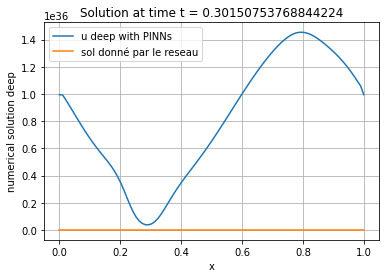

deep [4.06728330e+36 4.05764018e+36 3.92710809e+36 3.78052803e+36
 3.63126127e+36 3.48149978e+36 3.33220892e+36 3.18441021e+36
 3.03931120e+36 2.89820722e+36 2.76228256e+36 2.63237797e+36
 2.50877366e+36 2.39101163e+36 2.27776417e+36 2.16671055e+36
 2.05437580e+36 1.93594258e+36 1.80522086e+36 1.65528248e+36
 1.48038402e+36 1.27922752e+36 1.05822046e+36 8.32241101e+35
 6.21088760e+35 4.42722752e+35 3.07311683e+35 2.15853107e+35
 1.63620268e+35 1.45340383e+35 1.58564556e+35 2.03660597e+35
 2.81152145e+35 3.88653217e+35 5.19754669e+35 6.65530063e+35
 8.17209999e+35 9.68087811e+35 1.11400589e+36 1.25304658e+36
 1.38507179e+36 1.51120629e+36 1.63323563e+36 1.75304857e+36
 1.87227647e+36 1.99217356e+36 2.11364595e+36 2.23730444e+36
 2.36351457e+36 2.49244960e+36 2.62412387e+36 2.75842190e+36
 2.89511481e+36 3.03388525e+36 3.17432565e+36 3.31595382e+36
 3.45823812e+36 3.60063041e+36 3.74259858e+36 3.88366985e+36
 4.02343090e+36 4.16151670e+36 4.29758263e+36 4.43127099e+36
 4.56218629e+36 4.6

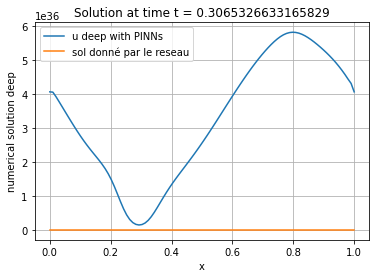

deep [1.66206439e+37 1.65730249e+37 1.60549672e+37 1.54728946e+37
 1.48787597e+37 1.42810888e+37 1.36834996e+37 1.30897804e+37
 1.25045540e+37 1.19330448e+37 1.13803900e+37 1.08507311e+37
 1.03462942e+37 9.86659247e+36 9.40783292e+36 8.96242687e+36
 8.51842282e+36 8.05875819e+36 7.56064254e+36 6.99655358e+36
 6.33938767e+36 5.57351231e+36 4.70914090e+36 3.79156529e+36
 2.89523570e+36 2.10076768e+36 1.46665646e+36 1.01357833e+36
 7.30068977e+35 5.92420874e+35 5.83552656e+35 7.00036198e+35
 9.45883868e+35 1.31954308e+36 1.80417571e+36 2.36817890e+36
 2.97442972e+36 3.59048941e+36 4.19375183e+36 4.77167477e+36
 5.32008558e+36 5.84112166e+36 6.34090120e+36 6.82708590e+36
 7.30692988e+36 7.78632423e+36 8.26968202e+36 8.76011196e+36
 9.25964042e+36 9.76943910e+36 1.02899665e+37 1.08210929e+37
 1.13621735e+37 1.19121522e+37 1.24695565e+37 1.30325635e+37
 1.35991050e+37 1.41670093e+37 1.47341427e+37 1.52985981e+37
 1.58587073e+37 1.64130059e+37 1.69601231e+37 1.74986427e+37
 1.80269957e+37 1.8

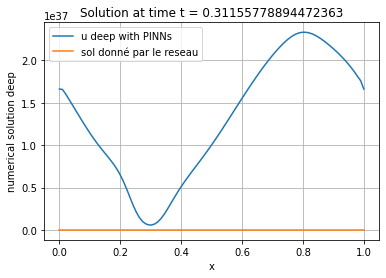

deep [6.78701551e+37 6.76431098e+37 6.55909937e+37 6.32836330e+37
 6.09225890e+37 5.85412361e+37 5.61532852e+37 5.37727181e+37
 5.14169457e+37 4.91065515e+37 4.68630746e+37 4.47056124e+37
 4.26470374e+37 4.06904889e+37 3.88266660e+37 3.70317389e+37
 3.52652984e+37 3.34676762e+37 3.15566943e+37 2.94275547e+37
 2.69646114e+37 2.40751756e+37 2.07447063e+37 1.70897966e+37
 1.33668814e+37 9.90831730e+36 7.00799946e+36 4.82473540e+36
 3.36382776e+36 2.53804141e+36 2.25458513e+36 2.47087260e+36
 3.19470521e+36 4.44074135e+36 6.17879705e+36 8.31174199e+36
 1.06963953e+37 1.31867828e+37 1.56678472e+37 1.80666494e+37
 2.03487894e+37 2.25103034e+37 2.45686013e+37 2.65525295e+37
 2.84929982e+37 3.04169969e+37 3.23456402e+37 3.42943521e+37
 3.62737624e+37 3.82906999e+37 4.03488006e+37 4.24490363e+37
 4.45900385e+37 4.67685406e+37 4.89793771e+37 5.12157603e+37
 5.34697277e+37 5.57327406e+37 5.79962998e+37 6.02527507e+37
 6.24953892e+37 6.47183563e+37 6.69162092e+37 6.90833464e+37
 7.12135378e+37 7.3

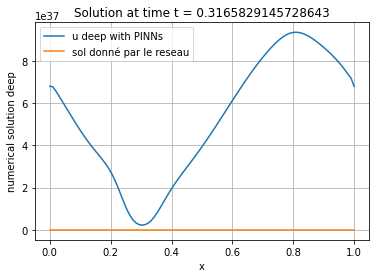

deep [2.76942278e+38 2.75890315e+38 2.67778670e+38 2.58649365e+38
 2.49282587e+38 2.39809796e+38 2.30283832e+38 2.20756370e+38
 2.11292147e+38 2.01970601e+38 1.92879507e+38 1.84102891e+38
 1.75706023e+38 1.67720364e+38 1.60131288e+38 1.52868742e+38
 1.45799307e+38 1.38716967e+38 1.31329951e+38 1.23251075e+38
 1.14017692e+38 1.03184053e+38 9.05111409e+37 7.62057185e+37
 6.10620566e+37 4.63430135e+37 3.33831671e+37 2.31205913e+37
 1.58522748e+37 1.13473454e+37 9.18567343e+36 9.07068698e+36
 1.09449359e+37 1.48893891e+37 2.09092856e+37 2.87646162e+37
 3.79622077e+37 4.78968420e+37 5.80213078e+37 6.79436485e+37
 7.74416087e+37 8.64362265e+37 9.49561724e+37 1.03098560e+38
 1.10987808e+38 1.18743481e+38 1.26464563e+38 1.34226097e+38
 1.42081924e+38 1.50068943e+38 1.58209784e+38 1.66515043e+38
 1.74984690e+38 1.83609974e+38 1.92373532e+38 2.01250593e+38
 2.10210862e+38 2.19221059e+38 2.28247553e+38 2.37259802e+38
 2.46230983e+38 2.55137737e+38 2.63958513e+38 2.72671203e+38
 2.81251099e+38 2.8

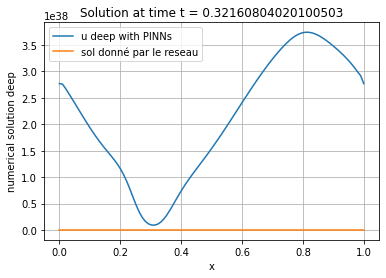

deep [1.12920363e+39 1.12444521e+39 1.09245457e+39 1.05640600e+39
 1.01931178e+39 9.81692548e+38 9.43756045e+38 9.05694868e+38
 8.67747675e+38 8.30215564e+38 7.93447486e+38 7.57799926e+38
 7.23579686e+38 6.90981216e+38 6.60031942e+38 6.30549584e+38
 6.02108987e+38 5.74009712e+38 5.45228695e+38 5.14366100e+38
 4.79651558e+38 4.39161721e+38 3.91409606e+38 3.36278133e+38
 2.75875014e+38 2.14603226e+38 1.58021711e+38 1.10919450e+38
 7.57554778e+37 5.24370571e+37 3.93855873e+37 3.49888618e+37
 3.85158063e+37 5.01202709e+37 7.01336757e+37 9.82003902e+37
 1.32861426e+38 1.71836195e+38 2.12708205e+38 2.53511950e+38
 2.92969654e+38 3.30456811e+38 3.65870418e+38 3.99475344e+38
 4.31734487e+38 4.63154393e+38 4.94186982e+38 5.25190640e+38
 5.56431578e+38 5.88100304e+38 6.20323581e+38 6.53173998e+38
 6.86676012e+38 7.20814118e+38 7.55533905e+38 7.90747361e+38
 8.26340909e+38 8.62186104e+38 8.98150878e+38 9.34114106e+38
 9.69969013e+38 1.00562285e+39 1.04099060e+39 1.07598530e+39
 1.11050920e+39 1.1

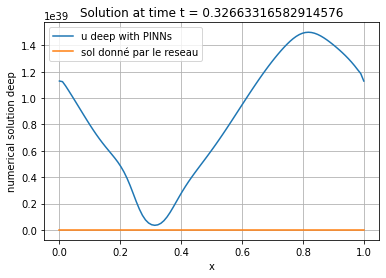

deep [4.60068679e+39 4.57959907e+39 4.45374258e+39 4.31170291e+39
 4.16507775e+39 4.01593674e+39 3.86511330e+39 3.71333636e+39
 3.56148291e+39 3.41067719e+39 3.26227636e+39 3.11774786e+39
 2.97846122e+39 2.84543569e+39 2.71910272e+39 2.59911135e+39
 2.48418110e+39 2.37198052e+39 2.25896489e+39 2.14015250e+39
 2.00897932e+39 1.85769355e+39 1.67899395e+39 1.46929031e+39
 1.23265677e+39 9.82956782e+38 7.41533057e+38 5.30392688e+38
 3.64491215e+38 2.47992984e+38 1.76442330e+38 1.42490585e+38
 1.41047820e+38 1.71157227e+38 2.34370463e+38 3.31240811e+38
 4.58416465e+38 6.08263464e+38 7.70968225e+38 9.37341437e+38
 1.10060822e+39 1.25680876e+39 1.40443078e+39 1.54381973e+39
 1.67650020e+39 1.80449416e+39 1.92979389e+39 2.05407452e+39
 2.17862710e+39 2.30440642e+39 2.43208185e+39 2.56207958e+39
 2.69460858e+39 2.82969528e+39 2.96719059e+39 3.10679377e+39
 3.24808688e+39 3.39057995e+39 3.53375872e+39 3.67714616e+39
 3.82031958e+39 3.96291247e+39 4.10459081e+39 4.24501399e+39
 4.38379695e+39 4.5

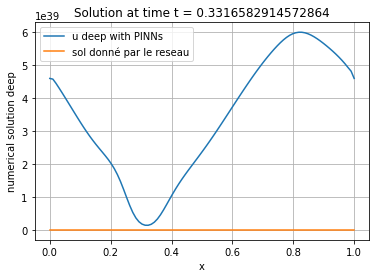

deep [1.87299765e+40 1.86381621e+40 1.81442941e+40 1.75858910e+40
 1.70074627e+40 1.64172489e+40 1.58186508e+40 1.52144854e+40
 1.46079852e+40 1.40032998e+40 1.34056061e+40 1.28207891e+40
 1.22547276e+40 1.17123138e+40 1.11964527e+40 1.07071870e+40
 1.02410260e+40 9.79044885e+39 9.34334403e+39 8.88219999e+39
 8.38322161e+39 7.81659199e+39 7.15042650e+39 6.36105644e+39
 5.44874175e+39 4.45130010e+39 3.44403075e+39 2.51955635e+39
 1.75552453e+39 1.18972075e+39 8.17740599e+38 6.11476463e+38
 5.43223029e+38 6.00545888e+38 7.86347820e+38 1.10741884e+39
 1.56011920e+39 2.12280355e+39 2.75935900e+39 3.42996438e+39
 4.10117092e+39 4.75055364e+39 5.36669982e+39 5.94719451e+39
 6.49596446e+39 7.02043472e+39 7.52899172e+39 8.02925201e+39
 8.52735989e+39 9.02799903e+39 9.53457527e+39 1.00494033e+40
 1.05738212e+40 1.11083369e+40 1.16526672e+40 1.22058460e+40
 1.27663734e+40 1.33324072e+40 1.39019646e+40 1.44731815e+40
 1.50443953e+40 1.56141651e+40 1.61811853e+40 1.67441287e+40
 1.73014856e+40 1.7

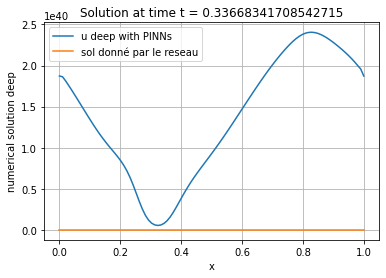

deep [7.61929774e+40 7.57993312e+40 7.38665223e+40 7.16764730e+40
 6.93993844e+40 6.70680172e+40 6.46964193e+40 6.22957300e+40
 5.98779827e+40 5.74583854e+40 5.50563543e+40 5.26949536e+40
 5.03986226e+40 4.81895336e+40 4.60835039e+40 4.40861591e+40
 4.21898548e+40 4.03714902e+40 3.85904600e+40 3.67858969e+40
 3.48729298e+40 3.27405994e+40 3.02593812e+40 2.73103229e+40
 2.38407679e+40 1.99291509e+40 1.58162989e+40 1.18615035e+40
 8.42596847e+39 5.74693792e+39 3.88102414e+39 2.74485874e+39
 2.21138048e+39 2.19400852e+39 2.67687722e+39 3.68868397e+39
 5.24567637e+39 7.30249519e+39 9.74187298e+39 1.24054404e+40
 1.51395034e+40 1.78269749e+40 2.03970940e+40 2.28210204e+40
 2.51019735e+40 2.72637993e+40 2.93396887e+40 3.13630430e+40
 3.33624623e+40 3.53605149e+40 3.73740980e+40 3.94152083e+40
 4.14914639e+40 4.36067251e+40 4.57612922e+40 4.79523938e+40
 5.01748373e+40 5.24218221e+40 5.46857943e+40 5.69595359e+40
 5.92365546e+40 6.15112208e+40 6.37784595e+40 6.60331298e+40
 6.82693464e+40 7.0

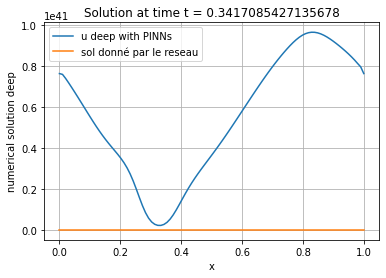

deep [3.09711423e+41 3.08046190e+41 3.00502373e+41 2.91934184e+41
 2.82989767e+41 2.73798821e+41 2.64419673e+41 2.54897327e+41
 2.45277311e+41 2.35615261e+41 2.25982990e+41 2.16469039e+41
 2.07172270e+41 1.98188997e+41 1.89596887e+41 1.81438593e+41
 1.73707823e+41 1.66339309e+41 1.59200646e+41 1.52082938e+41
 1.44687171e+41 1.36610024e+41 1.27350558e+41 1.16382489e+41
 1.03332681e+41 8.82435051e+40 7.17886923e+40 5.52505942e+40
 4.01653341e+40 2.77865362e+40 1.86901834e+40 1.27584988e+40
 9.49814161e+39 8.43717649e+39 9.36562278e+39 1.23364305e+40
 1.74812258e+40 2.47754504e+40 3.39023293e+40 4.42932248e+40
 5.52946655e+40 6.63380383e+40 7.70294522e+40 8.71605904e+40
 9.66780008e+40 1.05638828e+41 1.14163374e+41 1.22391334e+41
 1.30452116e+41 1.38452484e+41 1.46474702e+41 1.54579067e+41
 1.62806255e+41 1.71180006e+41 1.79708087e+41 1.88384457e+41
 1.97192112e+41 2.06106565e+41 2.15099464e+41 2.24143168e+41
 2.33212542e+41 2.42285747e+41 2.51343185e+41 2.60365073e+41
 2.69328624e+41 2.7

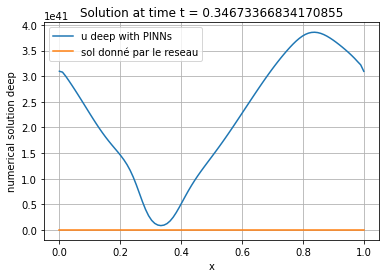

deep [1.25796357e+42 1.25100068e+42 1.22163610e+42 1.18819901e+42
 1.15314615e+42 1.11698725e+42 1.07996410e+42 1.04226152e+42
 1.00405531e+42 9.65549906e+41 9.27008162e+41 8.88763785e+41
 8.51207154e+41 8.14742672e+41 7.79727933e+41 7.46406066e+41
 7.14844004e+41 6.84886058e+41 6.56118580e+41 6.27836690e+41
 5.98998154e+41 5.68161342e+41 5.33454821e+41 4.92722621e+41
 4.44039087e+41 3.86653763e+41 3.22048815e+41 2.54387031e+41
 1.89687719e+41 1.33855431e+41 9.06348530e+40 6.07644599e+40
 4.27231747e+40 3.43347722e+40 3.41368936e+40 4.18666145e+40
 5.80416775e+40 8.30409144e+40 1.16276954e+41 1.55963077e+41
 1.99555310e+41 2.44486997e+41 2.88735155e+41 3.31037080e+41
 3.70844796e+41 4.08168118e+41 4.43383632e+41 4.77039576e+41
 5.09700295e+41 5.41859828e+41 5.73912052e+41 6.06153560e+41
 6.38792992e+41 6.71962901e+41 7.05724374e+41 7.40076532e+41
 7.74968920e+41 8.10316440e+41 8.46014743e+41 8.81959415e+41
 9.18054168e+41 9.54215000e+41 9.90366810e+41 1.02643404e+42
 1.06232912e+42 1.0

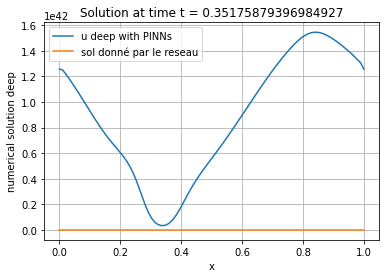

deep [5.10568580e+42 5.07686124e+42 4.96285666e+42 4.83270005e+42
 4.69565577e+42 4.55370623e+42 4.40784584e+42 4.25884049e+42
 4.10738370e+42 3.95423458e+42 3.80034957e+42 3.64696649e+42
 3.49559366e+42 3.34788105e+42 3.20540099e+42 3.06937804e+42
 2.94042278e+42 2.81831907e+42 2.70186321e+42 2.58873456e+42
 2.47534235e+42 2.35659707e+42 2.22567709e+42 2.07419586e+42
 1.89351088e+42 1.67779563e+42 1.42840495e+42 1.15725747e+42
 8.86076261e+41 6.40234110e+41 4.39884446e+41 2.93737580e+41
 1.99164843e+41 1.47608427e+41 1.31086636e+41 1.46071774e+41
 1.93505244e+41 2.75855937e+41 3.93280889e+41 5.41220924e+41
 7.10774557e+41 8.91238074e+41 1.07295289e+42 1.24901252e+42
 1.41561823e+42 1.57165011e+42 1.71794106e+42 1.85645272e+42
 1.98953031e+42 2.11939593e+42 2.24790204e+42 2.37648313e+42
 2.50618085e+42 2.63769531e+42 2.77140779e+42 2.90742214e+42
 3.04561830e+42 3.18571642e+42 3.32734256e+42 3.47010924e+42
 3.61365243e+42 3.75765245e+42 3.90182413e+42 4.04588142e+42
 4.18949048e+42 4.3

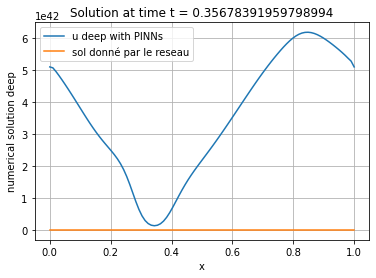

deep [2.07073489e+43 2.05890237e+43 2.01475004e+43 1.96421201e+43
 1.91076237e+43 1.85516174e+43 1.79781358e+43 1.73903559e+43
 1.67910643e+43 1.61831252e+43 1.55700161e+43 1.49562685e+43
 1.43475971e+43 1.37505658e+43 1.31718428e+43 1.26171629e+43
 1.20902136e+43 1.15916807e+43 1.11185037e+43 1.06633246e+43
 1.02139589e+43 9.75262352e+42 9.25488163e+42 8.68927503e+42
 8.02007702e+42 7.21629969e+42 6.26766684e+42 5.20174583e+42
 4.09004095e+42 3.03296533e+42 2.12664173e+42 1.42989900e+42
 9.51866519e+41 6.65328822e+41 5.33303040e+41 5.31228114e+41
 6.54736448e+41 9.13019389e+41 1.31404404e+42 1.85072297e+42
 2.49608777e+42 3.20937195e+42 3.94775475e+42 4.67634851e+42
 5.37264237e+42 6.02634298e+42 6.63694922e+42 7.21044368e+42
 7.75595701e+42 8.28312100e+42 8.80045872e+42 9.31480033e+42
 9.83124580e+42 1.03533631e+43 1.08833001e+43 1.14219658e+43
 1.19692602e+43 1.25243483e+43 1.30859412e+43 1.36526352e+43
 1.42230773e+43 1.47960675e+43 1.53705351e+43 1.59454084e+43
 1.65194269e+43 1.7

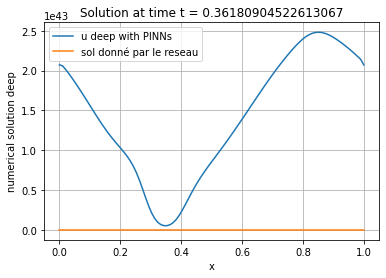

deep [8.39249259e+43 8.34425422e+43 8.17363879e+43 7.97787737e+43
 7.76992051e+43 7.55263825e+43 7.32763719e+43 7.09622646e+43
 6.85953967e+43 6.61867823e+43 6.37491279e+43 6.12988660e+43
 5.88572693e+43 5.64498629e+43 5.41040877e+43 5.18454812e+43
 4.96931731e+43 4.76557169e+43 4.57276621e+43 4.38870585e+43
 4.20934574e+43 4.02853881e+43 3.83764048e+43 3.62515071e+43
 3.37708654e+43 3.07932149e+43 2.72285785e+43 2.31104585e+43
 1.86478856e+43 1.42071259e+43 1.02054974e+43 6.96567685e+42
 4.61863559e+42 3.11073922e+42 2.29497295e+42 2.03714538e+42
 2.27817682e+42 3.03453296e+42 4.35143889e+42 6.24040336e+42
 8.63723307e+42 1.14031166e+43 1.43629302e+43 1.73528956e+43
 2.02520479e+43 2.29915165e+43 2.55490599e+43 2.79367604e+43
 3.01868976e+43 3.23392443e+43 3.44319164e+43 3.64968698e+43
 3.85586814e+43 4.06350940e+43 4.27375236e+43 4.48718684e+43
 4.70394912e+43 4.92383860e+43 5.14643766e+43 5.37125501e+43
 5.59779943e+43 5.82562834e+43 6.05434581e+43 6.28355541e+43
 6.51278626e+43 6.7

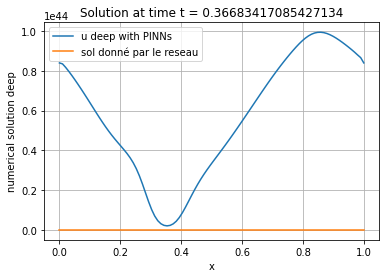

deep [3.39912666e+44 3.37956747e+44 3.31376366e+44 3.23810410e+44
 3.15738685e+44 3.07267333e+44 2.98458835e+44 2.89366414e+44
 2.80036406e+44 2.70511948e+44 2.60839969e+44 2.51079740e+44
 2.41309247e+44 2.31625710e+44 2.22139115e+44 2.12958885e+44
 2.04176302e+44 1.95846858e+44 1.87974773e+44 1.80501391e+44
 1.73296834e+44 1.66151509e+44 1.58762680e+44 1.50717493e+44
 1.41489206e+44 1.30488172e+44 1.17219024e+44 1.01549146e+44
 8.39827250e+43 6.57412287e+43 4.84921476e+43 3.37940242e+43
 2.25684269e+43 1.49190021e+43 1.03662975e+43 8.28602436e+42
 8.26726745e+42 1.02373653e+43 1.43574163e+43 2.07855790e+43
 2.94471457e+43 3.99382690e+43 5.16067326e+43 6.37392455e+43
 7.57347792e+43 8.71936698e+43 9.79260379e+43 1.07913140e+44
 1.17251011e+44 1.26093364e+44 1.34604461e+44 1.42930569e+44
 1.51188319e+44 1.59464347e+44 1.67817128e+44 1.76280581e+44
 1.84868300e+44 1.93578496e+44 2.02399094e+44 2.11313792e+44
 2.20305338e+44 2.29357814e+44 2.38456868e+44 2.47588075e+44
 2.56734074e+44 2.6

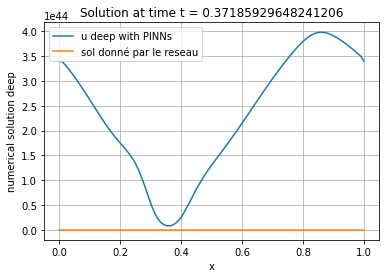

deep [1.37584461e+45 1.36794561e+45 1.34260493e+45 1.31342190e+45
 1.28216329e+45 1.24921235e+45 1.21480518e+45 1.17915393e+45
 1.14244737e+45 1.10485691e+45 1.06655847e+45 1.02776575e+45
 9.88761103e+44 9.49907835e+44 9.11636467e+44 8.74401205e+44
 8.38614103e+44 8.04572770e+44 7.72392190e+44 7.41950908e+44
 7.12853384e+44 6.84398908e+44 6.55537806e+44 6.24806898e+44
 5.90274854e+44 5.49618844e+44 5.00541648e+44 4.41671277e+44
 3.73741579e+44 3.00391587e+44 2.27765592e+44 1.62698410e+44
 1.10343315e+44 7.26600030e+43 4.86119197e+43 3.56947823e+43
 3.16622441e+43 3.55271593e+43 4.75736559e+43 6.86161505e+43
 9.89869134e+43 1.37804296e+44 1.82910230e+44 2.31443771e+44
 2.80630051e+44 3.28357314e+44 3.73390156e+44 4.15301004e+44
 4.54265991e+44 4.90822872e+44 5.25645828e+44 5.59385544e+44
 5.92585798e+44 6.25663204e+44 6.58909743e+44 6.92508105e+44
 7.26550126e+44 7.61057695e+44 7.96004322e+44 8.31340714e+44
 8.67009336e+44 9.02954980e+44 9.39127092e+44 9.75474344e+44
 1.01193376e+45 1.0

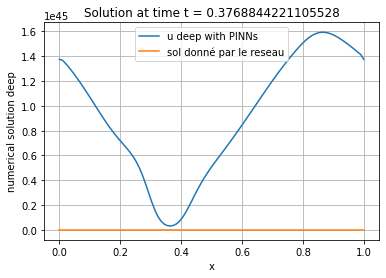

deep [5.56562955e+45 5.53381369e+45 5.43633389e+45 5.32396158e+45
 5.20316429e+45 5.07528705e+45 4.94119088e+45 4.80170022e+45
 4.65757563e+45 4.50950367e+45 4.35815468e+45 4.20430310e+45
 4.04896165e+45 3.89346497e+45 3.73946196e+45 3.58878696e+45
 3.44322448e+45 3.30422352e+45 3.17260607e+45 3.04832167e+45
 2.93027161e+45 2.81618177e+45 2.70245744e+45 2.58396432e+45
 2.45375410e+45 2.30303739e+45 2.12212548e+45 1.90315602e+45
 1.64455573e+45 1.35542371e+45 1.05650058e+45 7.75348953e+44
 5.37171188e+44 3.56374748e+44 2.33957279e+44 1.61583409e+44
 1.28767589e+44 1.28654406e+44 1.60032265e+44 2.25697469e+44
 3.28679688e+44 4.68416158e+44 6.38906029e+44 8.29733748e+44
 1.02902382e+45 1.22644877e+45 1.41496697e+45 1.59112160e+45
 1.75444598e+45 1.90650608e+45 2.04988892e+45 2.18738347e+45
 2.32146918e+45 2.45411879e+45 2.58676272e+45 2.72034566e+45
 2.85540650e+45 2.99216747e+45 3.13062503e+45 3.27065747e+45
 3.41208932e+45 3.55473989e+45 3.69843869e+45 3.84300887e+45
 3.98822675e+45 4.1

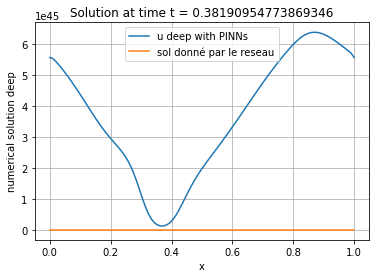

deep [2.25019569e+46 2.23739885e+46 2.19992270e+46 2.15670992e+46
 2.11011564e+46 2.06059586e+46 2.00845096e+46 1.95399133e+46
 1.89751784e+46 1.83930549e+46 1.77961354e+46 1.71872530e+46
 1.65700214e+46 1.59492697e+46 1.53311874e+46 1.47230023e+46
 1.41321880e+46 1.35653787e+46 1.30271616e+46 1.25189854e+46
 1.20383369e+46 1.15781713e+46 1.11263932e+46 1.06651543e+46
 1.01697873e+46 9.60796600e+45 8.94126017e+45 8.13251616e+45
 7.16102503e+45 6.04183282e+45 4.83779025e+45 3.65142720e+45
 2.59434730e+45 1.74869764e+45 1.14368301e+45 7.60022315e+44
 5.55330739e+44 4.92122902e+44 5.53930750e+44 7.45605844e+44
 1.08164164e+45 1.56974888e+45 2.19819885e+45 2.93355230e+45
 3.72908553e+45 4.53787597e+45 5.32327741e+45 6.06331554e+45
 6.74999733e+45 7.38594449e+45 7.98011289e+45 8.54388187e+45
 9.08823458e+45 9.62234519e+45 1.01531081e+46 1.06852744e+46
 1.12217834e+46 1.17641452e+46 1.23128244e+46 1.28676912e+46
 1.34283035e+46 1.39941291e+46 1.45646335e+46 1.51392370e+46
 1.57171684e+46 1.6

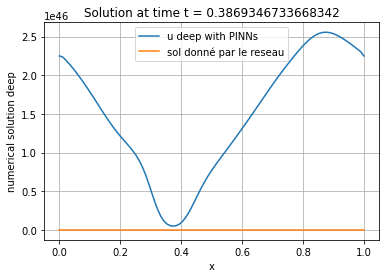

deep [9.09297671e+46 9.04152285e+46 8.89745566e+46 8.73143009e+46
 8.55198578e+46 8.36060362e+46 8.15827179e+46 7.94611339e+46
 7.72528926e+46 7.49689171e+46 7.26193338e+46 7.02146396e+46
 6.77677174e+46 6.52958207e+46 6.28217521e+46 6.03733546e+46
 5.79810430e+46 5.56738644e+46 5.34746653e+46 5.13953738e+46
 4.94332027e+46 4.75679772e+46 4.57600636e+46 4.39481114e+46
 4.20454140e+46 3.99354223e+46 3.74720393e+46 3.44968152e+46
 3.08855579e+46 2.66225455e+46 2.18698123e+46 1.69773020e+46
 1.23990405e+46 8.54169870e+45 5.63025853e+45 3.67069050e+45
 2.51952430e+45 2.00129279e+45 2.00186624e+45 2.50098892e+45
 3.54688930e+45 5.19604007e+45 7.44965155e+45 1.02193609e+46
 1.33389120e+46 1.66108626e+46 1.98586048e+46 2.29588683e+46
 2.58495606e+46 2.85207725e+46 3.09980103e+46 3.33246215e+46
 3.55474547e+46 3.77082111e+46 3.98395758e+46 4.19649503e+46
 4.40996678e+46 4.62526226e+46 4.84278992e+46 5.06266596e+46
 5.28483708e+46 5.50918067e+46 5.73555178e+46 5.96377631e+46
 6.19360002e+46 6.4

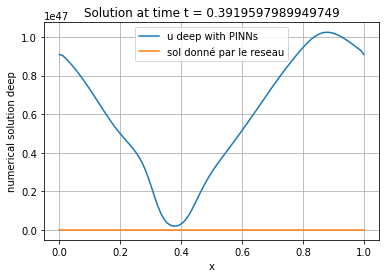

deep [3.67274150e+47 3.65204150e+47 3.59663398e+47 3.53287363e+47
 3.46384811e+47 3.39001211e+47 3.31166418e+47 3.22919052e+47
 3.14302467e+47 3.05359345e+47 2.96129344e+47 2.86651860e+47
 2.76972980e+47 2.67153751e+47 2.57276746e+47 2.47446976e+47
 2.37785094e+47 2.28413853e+47 2.19439472e+47 2.10931866e+47
 2.02907571e+47 1.95317101e+47 1.88035818e+47 1.80856164e+47
 1.73476068e+47 1.65481092e+47 1.56332207e+47 1.45396368e+47
 1.32074743e+47 1.16058709e+47 9.76424987e+46 7.79025450e+46
 5.85428506e+46 4.13811929e+46 2.77255515e+46 1.80107215e+46
 1.18872566e+46 8.64120922e+45 7.64857481e+45 8.63484384e+45
 1.16823900e+46 1.70463723e+46 2.48884801e+46 3.50598165e+46
 4.70431226e+46 6.00760488e+46 7.33681948e+46 8.62869291e+46
 9.84449686e+46 1.09696589e+47 1.20080185e+47 1.29744120e+47
 1.38878425e+47 1.47667127e+47 1.56262228e+47 1.64776946e+47
 1.73288897e+47 1.81846730e+47 1.90477081e+47 1.99192481e+47
 2.07996647e+47 2.16888965e+47 2.25866863e+47 2.34926010e+47
 2.44058628e+47 2.5

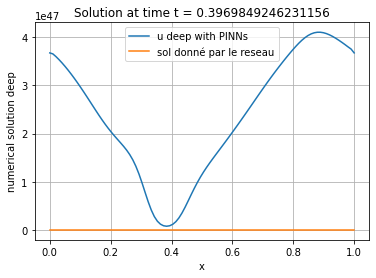

deep [1.48282985e+48 1.47449228e+48 1.45316319e+48 1.42867537e+48
 1.40214417e+48 1.37369860e+48 1.34341668e+48 1.31142224e+48
 1.27787057e+48 1.24292441e+48 1.20673816e+48 1.16946114e+48
 1.13125940e+48 1.09234752e+48 1.05301991e+48 1.01366480e+48
 9.74749684e+47 9.36778031e+47 9.00220325e+47 8.65433960e+47
 8.32588590e+47 8.01607214e+47 7.72123542e+47 7.43451881e+47
 7.14550693e+47 6.83961004e+47 6.49735255e+47 6.09455147e+47
 5.60536981e+47 5.01030254e+47 4.30839450e+47 3.52811542e+47
 2.72821696e+47 1.98326479e+47 1.35878134e+47 8.89933140e+46
 5.76163090e+46 3.92958488e+46 3.11042157e+46 3.11437379e+46
 3.90757092e+46 5.57267691e+46 8.21275501e+46 1.18462039e+47
 1.63439232e+47 2.14407709e+47 2.68094972e+47 3.21493821e+47
 3.72461813e+47 4.19898645e+47 4.63603661e+47 5.03988779e+47
 5.41772035e+47 5.77734786e+47 6.12567084e+47 6.46806887e+47
 6.80838297e+47 7.14915696e+47 7.49193051e+47 7.83757226e+47
 8.18650722e+47 8.53891429e+47 8.89484255e+47 9.25423964e+47
 9.61690085e+47 9.9

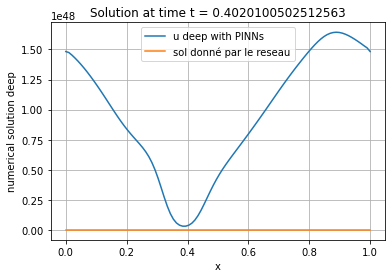

deep [5.98447619e+48 5.95084103e+48 5.86862606e+48 5.77452854e+48
 5.67258235e+48 5.56311017e+48 5.44625652e+48 5.32237760e+48
 5.19199977e+48 5.05572309e+48 4.91413981e+48 4.76781803e+48
 4.61736109e+48 4.46352099e+48 4.30733318e+48 4.15020599e+48
 3.99391131e+48 3.84046015e+48 3.69185956e+48 3.54979935e+48
 3.41533593e+48 3.28862415e+48 3.16871546e+48 3.05342623e+48
 2.93921657e+48 2.82099423e+48 2.69182351e+48 2.54275328e+48
 2.36338355e+48 2.14410229e+48 1.88035892e+48 1.57769565e+48
 1.25442763e+48 9.38771863e+47 6.60277938e+47 4.39783853e+47
 2.83758345e+47 1.85981115e+47 1.34472425e+47 1.18860207e+47
 1.34572941e+47 1.83001437e+47 2.68595447e+47 3.94554576e+47
 5.59112486e+47 7.54284643e+47 9.67664985e+47 1.18598619e+48
 1.39839230e+48 1.59812380e+48 1.78254714e+48 1.95220066e+48
 2.10950797e+48 2.25761940e+48 2.39957242e+48 2.53787056e+48
 2.67437805e+48 2.81038494e+48 2.94672487e+48 3.08391571e+48
 3.22225722e+48 3.36191741e+48 3.50298768e+48 3.64550303e+48
 3.78942928e+48 3.9

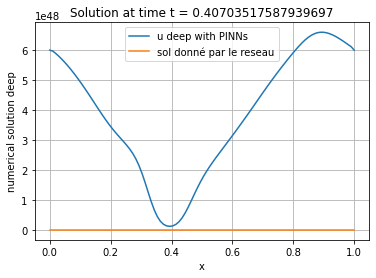

deep [2.41440788e+49 2.40081554e+49 2.36907375e+49 2.33288103e+49
 2.29370169e+49 2.25159807e+49 2.20656378e+49 2.15868194e+49
 2.10811748e+49 2.05508199e+49 1.99979707e+49 1.94247792e+49
 1.88334529e+49 1.82266271e+49 1.76079013e+49 1.69822936e+49
 1.63563796e+49 1.57379992e+49 1.51354505e+49 1.45563112e+49
 1.40061431e+49 1.34873066e+49 1.29980146e+49 1.25317141e+49
 1.20766301e+49 1.16151582e+49 1.11228509e+49 1.05672998e+49
 9.90857763e+48 9.10470388e+48 8.12515347e+48 6.97084912e+48
 5.69130102e+48 4.38469844e+48 3.17319718e+48 2.16237086e+48
 1.40726477e+48 9.04675764e+47 6.12973378e+47 4.83396970e+47
 4.84424571e+47 6.10392289e+47 8.75386867e+47 1.29791806e+48
 1.88352543e+48 2.61352265e+48 3.44573766e+48 4.32608691e+48
 5.20362530e+48 6.04140849e+48 6.82004978e+48 7.53556627e+48
 8.19446331e+48 8.80853777e+48 9.39063397e+48 9.95210856e+48
 1.05018340e+49 1.10462026e+49 1.15895469e+49 1.21347250e+49
 1.26835422e+49 1.32371263e+49 1.37961822e+49 1.43611108e+49
 1.49319913e+49 1.5

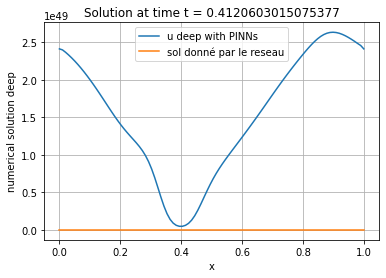

deep [9.73775599e+49 9.68273780e+49 9.55997089e+49 9.42058104e+49
 9.26991597e+49 9.10801117e+49 8.93461033e+49 8.74980690e+49
 8.55405541e+49 8.34805755e+49 8.13261327e+49 7.90852562e+49
 7.67660433e+49 7.43777429e+49 7.19327483e+49 6.94486372e+49
 6.69493194e+49 6.44646690e+49 6.20280648e+49 5.96721519e+49
 5.74237119e+49 5.52985871e+49 5.32973433e+49 5.14022986e+49
 4.95755606e+49 4.77570601e+49 4.58613412e+49 4.37728368e+49
 4.13432743e+49 3.84023643e+49 3.47961789e+49 3.04580217e+49
 2.54896530e+49 2.02008045e+49 1.50572551e+49 1.05391397e+49
 6.97876327e+48 4.47224216e+48 2.91038071e+48 2.09265709e+48
 1.84684588e+48 2.09689352e+48 2.86615577e+48 4.23164040e+48
 6.25413743e+48 8.91514265e+48 1.20919309e+49 1.55831125e+49
 1.91669591e+49 2.26584274e+49 2.59401110e+49 2.89645837e+49
 3.17385608e+49 3.43012110e+49 3.67039905e+49 3.89967740e+49
 4.12208603e+49 4.34072892e+49 4.55779441e+49 4.77478790e+49
 4.99271321e+49 5.21223575e+49 5.43379808e+49 5.65768276e+49
 5.88402016e+49 6.1

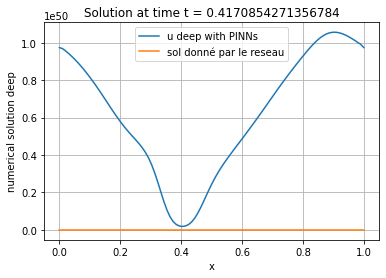

deep [3.92629551e+50 3.90399506e+50 3.85642861e+50 3.80266218e+50
 3.74466410e+50 3.68238736e+50 3.61565279e+50 3.54440718e+50
 3.46874556e+50 3.38888015e+50 3.30508539e+50 3.21765312e+50
 3.12687857e+50 3.03308657e+50 2.93670043e+50 2.83832592e+50
 2.73881524e+50 2.63928197e+50 2.54103562e+50 2.44543701e+50
 2.35370292e+50 2.26669551e+50 2.18472913e+50 2.10742880e+50
 2.03363781e+50 1.96134620e+50 1.88759339e+50 1.80830170e+50
 1.71809170e+50 1.61039251e+50 1.47839654e+50 1.31732729e+50
 1.12771930e+50 9.18102219e+49 7.04819155e+49 5.07862984e+49
 3.44252437e+49 2.22615089e+49 1.42086965e+49 9.56254167e+48
 7.51189443e+48 7.53368214e+48 9.53316850e+48 1.37493101e+49
 2.05097238e+49 2.99437712e+49 4.17848608e+49 5.53639569e+49
 6.97906569e+49 8.42069664e+49 9.79786538e+49 1.10765143e+50
 1.22487252e+50 1.33245710e+50 1.43231125e+50 1.52653521e+50
 1.61700012e+50 1.70518266e+50 1.79216387e+50 1.87871216e+50
 1.96535942e+50 2.05247207e+50 2.14030290e+50 2.22902242e+50
 2.31872831e+50 2.4

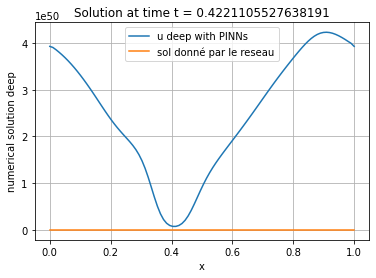

deep [1.58267915e+51 1.57363131e+51 1.55517190e+51 1.53439860e+51
 1.51204232e+51 1.48807005e+51 1.46238743e+51 1.43494119e+51
 1.40573478e+51 1.37482271e+51 1.34229236e+51 1.30824544e+51
 1.27278774e+51 1.23603290e+51 1.19812440e+51 1.15926773e+51
 1.11976061e+51 1.08000931e+51 1.04051559e+51 1.00183081e+51
 9.64484494e+50 9.28900042e+50 8.95311166e+50 8.63696056e+50
 8.33732545e+50 8.04767971e+50 7.75788865e+50 7.45368354e+50
 7.11585725e+50 6.71992870e+50 6.23806673e+50 5.64561415e+50
 4.93287001e+50 4.11813055e+50 3.25348469e+50 2.41570360e+50
 1.68280271e+50 1.10782894e+50 7.05062456e+49 4.55506976e+49
 3.25649706e+49 2.86922167e+49 3.26682529e+49 4.48839594e+49
 6.66615051e+49 9.91229055e+49 1.42129148e+50 1.93802277e+50
 2.50884779e+50 3.09690656e+50 3.67078924e+50 4.21016532e+50
 4.70646655e+50 5.16036753e+50 5.57806103e+50 5.96790236e+50
 6.33808657e+50 6.69547766e+50 7.04531048e+50 7.39141784e+50
 7.73652885e+50 8.08257573e+50 8.43092589e+50 8.78253217e+50
 9.13799673e+50 9.4

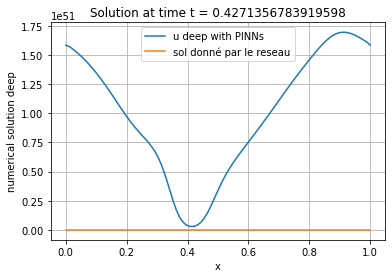

deep [6.37817310e+51 6.34144535e+51 6.26971701e+51 6.18932917e+51
 6.10301937e+51 6.01063951e+51 5.91175817e+51 5.80605924e+51
 5.69342749e+51 5.57395419e+51 5.44788527e+51 5.31555319e+51
 5.17732463e+51 5.03359218e+51 4.88483724e+51 4.73174558e+51
 4.57533632e+51 4.41705990e+51 4.25879580e+51 4.10272087e+51
 3.95106133e+51 3.80576708e+51 3.66816175e+51 3.53864527e+51
 3.41647753e+51 3.29963739e+51 3.18471703e+51 3.06676530e+51
 2.93899946e+51 2.79252010e+51 2.61653327e+51 2.39999729e+51
 2.13544109e+51 1.82431442e+51 1.48118755e+51 1.13320359e+51
 8.13070055e+50 5.48237836e+50 3.52259805e+50 2.23203452e+50
 1.49183753e+50 1.16722027e+50 1.17145621e+50 1.48872076e+50
 2.15933352e+50 3.24057468e+50 4.75960847e+50 6.67907126e+50
 8.89324692e+50 1.12562708e+51 1.36242091e+51 1.58885217e+51
 1.79893174e+51 1.99110088e+51 2.16685590e+51 2.32925357e+51
 2.48172881e+51 2.62738397e+51 2.76870236e+51 2.90755976e+51
 3.04532440e+51 3.18298552e+51 3.32125675e+51 3.46064665e+51
 3.60149484e+51 3.7

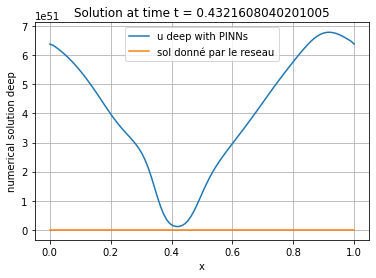

deep [2.56979646e+52 2.55488767e+52 2.52699344e+52 2.49584243e+52
 2.46246721e+52 2.42681729e+52 2.38871407e+52 2.34800249e+52
 2.30459194e+52 2.25846921e+52 2.20968755e+52 2.15834477e+52
 2.10456095e+52 2.04846795e+52 1.99022465e+52 1.93005561e+52
 1.86830221e+52 1.80547085e+52 1.74224989e+52 1.67947821e+52
 1.61806444e+52 1.55886610e+52 1.50254776e+52 1.44945085e+52
 1.39949168e+52 1.35209265e+52 1.30613889e+52 1.25993130e+52
 1.21109445e+52 1.15644744e+52 1.09195566e+52 1.01306999e+52
 9.15840365e+51 7.98861934e+51 6.65366610e+51 5.24086612e+51
 3.87664089e+51 2.68777924e+51 1.75911584e+51 1.11180490e+51
 7.12989537e+50 5.06739629e+50 4.45702856e+50 5.08891766e+50
 7.02816321e+50 1.05001177e+51 1.57077761e+51 2.26540296e+51
 3.10534373e+51 4.03817397e+51 5.00284644e+51 5.94621250e+51
 6.83307584e+51 7.64796499e+51 8.39104270e+51 9.07198365e+51
 9.70434763e+51 1.03016720e+52 1.08754626e+52 1.14347355e+52
 1.19862272e+52 1.25348948e+52 1.30843693e+52 1.36372825e+52
 1.41954558e+52 1.4

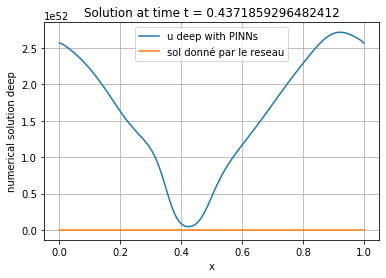

deep [1.03515038e+53 1.02910155e+53 1.01825160e+53 1.00616822e+53
 9.93242550e+52 9.79463168e+52 9.64762398e+52 9.49072503e+52
 9.32343489e+52 9.14551896e+52 8.95700532e+52 8.75812696e+52
 8.54924024e+52 8.33076460e+52 8.10320864e+52 7.86728956e+52
 7.62412259e+52 7.37543449e+52 7.12368910e+52 6.87204438e+52
 6.62411152e+52 6.38352694e+52 6.15339685e+52 5.93574549e+52
 5.73104886e+52 5.53789967e+52 5.35280436e+52 5.17002735e+52
 4.98131581e+52 4.77543075e+52 4.53767729e+52 4.25032324e+52
 3.89545916e+52 3.46137692e+52 2.95128329e+52 2.38994131e+52
 1.82236420e+52 1.30204948e+52 8.73336651e+51 5.57540148e+51
 3.50680188e+51 2.32743628e+51 1.81350939e+51 1.82137106e+51
 2.32460800e+51 3.39089074e+51 5.11944171e+51 7.56392700e+51
 1.06733725e+52 1.42817428e+52 1.81509685e+52 2.20403453e+52
 2.57643002e+52 2.92175922e+52 3.23693912e+52 3.52412118e+52
 3.78819761e+52 4.03481168e+52 4.26914397e+52 4.49544428e+52
 4.71697701e+52 4.93618551e+52 5.15488261e+52 5.37440050e+52
 5.59568427e+52 5.8

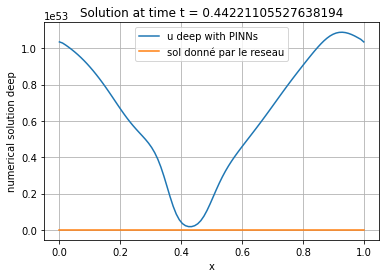

deep [4.16880572e+53 4.14428829e+53 4.10210661e+53 4.05521291e+53
 4.00508980e+53 3.95174334e+53 3.89494089e+53 3.83441283e+53
 3.76992425e+53 3.70132066e+53 3.62854223e+53 3.55161487e+53
 3.47062487e+53 3.38569240e+53 3.29697094e+53 3.20468078e+53
 3.10917502e+53 3.01102686e+53 2.91109721e+53 2.81054746e+53
 2.71077758e+53 2.61328294e+53 2.51944480e+53 2.43030410e+53
 2.34635499e+53 2.26738521e+53 2.19237576e+53 2.11943891e+53
 2.04573667e+53 1.96733131e+53 1.87896542e+53 1.77398959e+53
 1.64496881e+53 1.48556386e+53 1.29373895e+53 1.07514301e+53
 8.44381117e+52 6.22258706e+52 4.29402883e+52 2.79396148e+52
 1.75350378e+52 1.11610338e+52 7.88505065e+51 6.92288784e+51
 7.92659608e+51 1.10039848e+52 1.65369535e+52 2.48869137e+52
 3.60992618e+52 4.97446829e+52 6.49828508e+52 8.08058703e+52
 9.63156397e+52 1.10903573e+53 1.24288746e+53 1.36456233e+53
 1.47556254e+53 1.57809683e+53 1.67441517e+53 1.76647518e+53
 1.85583343e+53 1.94367770e+53 2.03089996e+53 2.11816321e+53
 2.20594679e+53 2.2

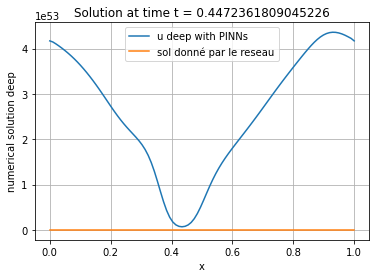

deep [1.67850481e+54 1.66858141e+54 1.65220347e+54 1.63400774e+54
 1.61455399e+54 1.59387007e+54 1.57188611e+54 1.54850429e+54
 1.52362572e+54 1.49717099e+54 1.46909096e+54 1.43936900e+54
 1.40801517e+54 1.37505647e+54 1.34053383e+54 1.30451038e+54
 1.26709295e+54 1.22846575e+54 1.18892172e+54 1.14887785e+54
 1.10886400e+54 1.06947849e+54 1.03131234e+54 9.94859668e+53
 9.60429175e+53 9.28070426e+53 8.97524080e+53 8.68192984e+53
 8.39115933e+53 8.08923917e+53 7.75758648e+53 7.37193692e+53
 6.90316558e+53 6.32218156e+53 5.61055342e+53 4.77479618e+53
 3.85683717e+53 2.93124163e+53 2.08557893e+53 1.39153389e+53
 8.82617777e+52 5.51029196e+52 3.63115463e+52 2.81747591e+52
 2.83161907e+52 3.62949052e+52 5.32419205e+52 8.08617486e+52
 1.20175733e+53 1.70519182e+53 2.29298541e+53 2.92641011e+53
 3.56527677e+53 4.17790614e+53 4.74574430e+53 5.26278130e+53
 5.73201598e+53 6.16129714e+53 6.55994535e+53 6.93672505e+53
 7.29892357e+53 7.65223964e+53 8.00100995e+53 8.34849074e+53
 8.69707190e+53 9.0

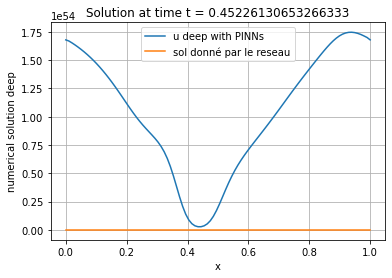

deep [6.75668475e+54 6.71659379e+54 6.65314006e+54 6.58260138e+54
 6.50707270e+54 6.42677778e+54 6.34155477e+54 6.25108769e+54
 6.15499891e+54 6.05293267e+54 5.94461218e+54 5.82987024e+54
 5.70864575e+54 5.58095518e+54 5.44687637e+54 5.30656517e+54
 5.16032141e+54 5.00871155e+54 4.85270209e+54 4.69375228e+54
 4.53381998e+54 4.37523907e+54 4.22045872e+54 4.07170123e+54
 3.93059509e+54 3.79784499e+54 3.67299096e+54 3.55426310e+54
 3.43848127e+54 3.32093134e+54 3.19510142e+54 3.05230240e+54
 2.88157820e+54 2.67076232e+54 2.40964492e+54 2.09529338e+54
 1.73750412e+54 1.36066045e+54 9.99019698e+53 6.86164050e+53
 4.43843940e+53 2.76599162e+53 1.74727216e+53 1.22692239e+53
 1.07522317e+53 1.23455220e+53 1.72269038e+53 2.60399981e+53
 3.94206569e+53 5.75092671e+53 7.96673079e+53 1.04553070e+54
 1.30505494e+54 1.56009601e+54 1.80011097e+54 2.02001122e+54
 2.21924582e+54 2.40014453e+54 2.56632143e+54 2.72156029e+54
 2.86919732e+54 3.01192784e+54 3.15183776e+54 3.29050938e+54
 3.42911843e+54 3.5

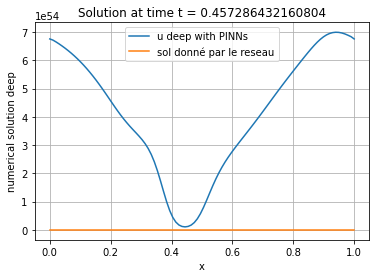

deep [2.71919649e+55 2.70303595e+55 2.67852787e+55 2.65123047e+55
 2.62191658e+55 2.59072174e+55 2.55763526e+55 2.52257273e+55
 2.48540500e+55 2.44598886e+55 2.40419253e+55 2.35991479e+55
 2.31309176e+55 2.26369158e+55 2.21170905e+55 2.15716814e+55
 2.10014086e+55 2.04079004e+55 1.97942224e+55 1.91653364e+55
 1.85282995e+55 1.78919953e+55 1.72662905e+55 1.66607811e+55
 1.60833212e+55 1.55385939e+55 1.50269819e+55 1.45438330e+55
 1.40790044e+55 1.36164913e+55 1.31336458e+55 1.25997459e+55
 1.19747389e+55 1.12107346e+55 1.02603420e+55 9.09448889e+54
 7.72578215e+54 6.22499418e+54 4.71567481e+54 3.34124213e+54
 2.21761367e+54 1.39746625e+54 8.65948519e+53 5.66537184e+53
 4.37705106e+53 4.40185272e+53 5.66622332e+53 8.35837348e+53
 1.27691899e+54 1.90885970e+54 2.72357505e+54 3.68078598e+54
 4.71762398e+54 5.76711349e+54 6.77511855e+54 7.70896317e+54
 8.55714482e+54 9.32371035e+54 1.00212942e+55 1.06654612e+55
 1.12710592e+55 1.18506190e+55 1.24140635e+55 1.29690111e+55
 1.35211847e+55 1.4

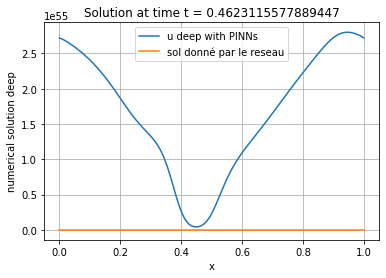

deep [1.09405108e+56 1.08755419e+56 1.07812729e+56 1.06759193e+56
 1.05622735e+56 1.04410553e+56 1.03124530e+56 1.01763334e+56
 1.00323210e+56 9.87989870e+55 9.71850748e+55 9.54764078e+55
 9.36690106e+55 9.17600670e+55 8.97478534e+55 8.76317728e+55
 8.54128749e+55 8.30952851e+55 8.06882025e+55 7.82079251e+55
 7.56792184e+55 7.31350790e+55 7.06142347e+55 6.81567614e+55
 6.57983913e+55 6.35645239e+55 6.14651034e+55 5.94909989e+55
 5.76117335e+55 5.57741444e+55 5.39001728e+55 5.18821541e+55
 4.95765393e+55 4.68026161e+55 4.33607876e+55 3.90863271e+55
 3.39373409e+55 2.80826564e+55 2.19293360e+55 1.60416514e+55
 1.09664029e+55 7.05200618e+54 4.36376588e+54 2.73562533e+54
 1.90910386e+54 1.66986105e+54 1.92259176e+54 2.69647646e+54
 4.09948576e+54 6.24260312e+54 9.15946959e+54 1.27564035e+55
 1.68197859e+55 2.10764346e+55 2.52706560e+55 2.92199554e+55
 3.28326545e+55 3.60946029e+55 3.90419250e+55 4.17343959e+55
 4.42357191e+55 4.66029027e+55 4.88825437e+55 5.11110020e+55
 5.33158893e+55 5.5

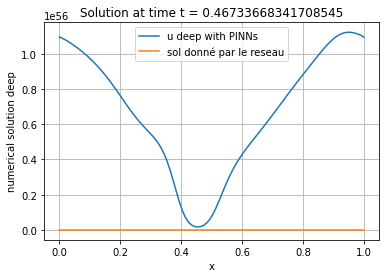

deep [4.40065675e+56 4.37461960e+56 4.33855023e+56 4.29803950e+56
 4.25406728e+56 4.20698645e+56 4.15696586e+56 4.10404380e+56
 4.04814417e+56 3.98910521e+56 3.92671365e+56 3.86074461e+56
 3.79099322e+56 3.71728886e+56 3.63950113e+56 3.55754279e+56
 3.47138450e+56 3.38110145e+56 3.28694549e+56 3.18942830e+56
 3.08939290e+56 2.98803417e+56 2.88683471e+56 2.78742028e+56
 2.69134796e+56 2.59986329e+56 2.51367577e+56 2.43278632e+56
 2.35637230e+56 2.28272734e+56 2.20919625e+56 2.13203384e+56
 2.04616376e+56 1.94496750e+56 1.82055193e+56 1.66518553e+56
 1.47427487e+56 1.25018258e+56 1.00484864e+56 7.58748289e+55
 5.35370033e+55 3.53465203e+55 2.21300249e+55 1.36103073e+55
 8.83965977e+54 6.79964155e+54 6.84218128e+54 8.84459336e+54
 1.31188688e+55 2.01592302e+55 3.03125688e+55 4.34926387e+55
 5.90770224e+55 7.60476727e+55 9.32881991e+55 1.09874189e+56
 1.25231786e+56 1.39144739e+56 1.51665208e+56 1.62998821e+56
 1.73405710e+56 1.83138073e+56 1.92411195e+56 2.01396920e+56
 2.10227431e+56 2.1

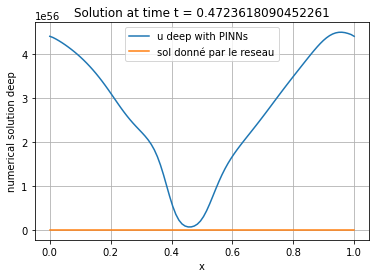

deep [1.76958662e+57 1.75919011e+57 1.74547993e+57 1.72997765e+57
 1.71301316e+57 1.69475026e+57 1.67529266e+57 1.65469408e+57
 1.63295901e+57 1.61004894e+57 1.58589206e+57 1.56039815e+57
 1.53347312e+57 1.50502874e+57 1.47498907e+57 1.44329370e+57
 1.40990273e+57 1.37481208e+57 1.33807869e+57 1.29985284e+57
 1.26041103e+57 1.22017419e+57 1.17969594e+57 1.13961850e+57
 1.10059722e+57 1.06320547e+57 1.02783939e+57 9.94638639e+56
 9.63429292e+56 9.33693191e+56 9.04545493e+56 8.74694408e+56
 8.42361203e+56 8.05171766e+56 7.60138499e+56 7.03982857e+56
 6.34042793e+56 5.49725970e+56 4.53936650e+56 3.53470299e+56
 2.57620053e+56 1.75292155e+56 1.12064167e+56 6.88560466e+55
 4.28350712e+55 2.97060839e+55 2.59314731e+55 2.99367655e+55
 4.21984665e+55 6.45222815e+55 9.88319797e+55 1.45850756e+56
 2.04224670e+56 2.70564329e+56 3.40377139e+56 4.09350800e+56
 4.74332402e+56 5.33680767e+56 5.87078880e+56 6.35093117e+56
 6.78712439e+56 7.19012124e+56 7.56966001e+56 7.93376512e+56
 8.28871469e+56 8.6

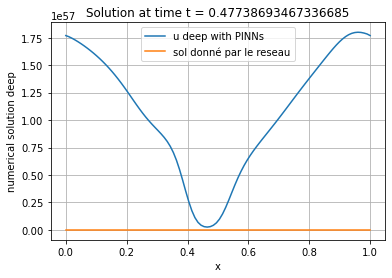

deep [7.11362556e+57 7.07229125e+57 7.02060262e+57 6.96164063e+57
 6.89644857e+57 6.82575712e+57 6.75011559e+57 6.66989164e+57
 6.58525601e+57 6.49618596e+57 6.40248397e+57 6.30382511e+57
 6.19981566e+57 6.09004296e+57 5.97411709e+57 5.85169650e+57
 5.72251030e+57 5.58641071e+57 5.44346007e+57 5.29405120e+57
 5.13904704e+57 4.97988443e+57 4.81857777e+57 4.65760037e+57
 4.49962942e+57 4.34718650e+57 4.20224724e+57 4.06588927e+57
 3.93801829e+57 3.81720776e+57 3.70060231e+57 3.58380069e+57
 3.46061586e+57 3.32265067e+57 3.15894269e+57 2.95646771e+57
 2.70259501e+57 2.39005353e+57 2.02321022e+57 1.62220164e+57
 1.22094978e+57 8.57934154e+56 5.63475090e+56 3.50507538e+56
 2.13948521e+56 1.37934064e+56 1.05625582e+56 1.06340492e+56
 1.38031230e+56 2.05856678e+56 3.18179905e+56 4.81251962e+56
 6.94411261e+56 9.48101254e+56 1.22584351e+57 1.50904330e+57
 1.78193882e+57 2.03448712e+57 2.26268060e+57 2.46716891e+57
 2.65129586e+57 2.81942021e+57 2.97582610e+57 3.12420210e+57
 3.26750285e+57 3.4

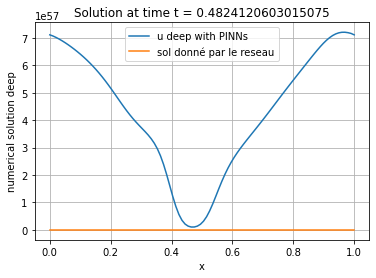

deep [2.85867272e+58 2.84232225e+58 2.82303211e+58 2.80077600e+58
 2.77585038e+58 2.74857162e+58 2.71920777e+58 2.68796409e+58
 2.65497172e+58 2.62028168e+58 2.58386335e+58 2.54561617e+58
 2.50538991e+58 2.46300645e+58 2.41828172e+58 2.37104176e+58
 2.32113469e+58 2.26845052e+58 2.21295140e+58 2.15471524e+58
 2.09399185e+58 2.03125298e+58 1.96721125e+58 1.90279545e+58
 1.83906998e+58 1.77710445e+58 1.71781894e+58 1.66183300e+58
 1.60933866e+58 1.56001863e+58 1.51299811e+58 1.46680595e+58
 1.41930734e+58 1.36756037e+58 1.30762901e+58 1.23456854e+58
 1.14298709e+58 1.02857532e+58 8.90521410e+57 7.33814790e+57
 5.69793508e+57 4.13766201e+57 2.80234023e+57 1.78112692e+57
 1.08667585e+57 6.70805285e+56 4.62234027e+56 4.02649692e+56
 4.66061565e+56 6.60227492e+56 1.01525885e+57 1.56431778e+57
 2.32200788e+57 3.26916930e+57 4.35209453e+57 5.49696262e+57
 6.63113520e+57 7.70026539e+57 8.67514075e+57 9.54925962e+57
 1.03314520e+58 1.10381211e+58 1.16874256e+58 1.22959699e+58
 1.28774975e+58 1.3

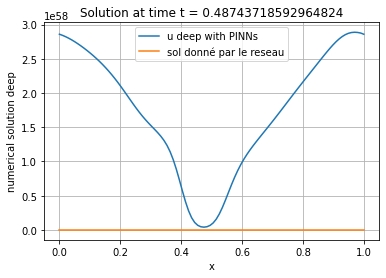

deep [1.14836696e+59 1.14193797e+59 1.13483004e+59 1.12650796e+59
 1.11703832e+59 1.10655508e+59 1.09518237e+59 1.08302355e+59
 1.07015567e+59 1.05662484e+59 1.04244215e+59 1.02758476e+59
 1.01200155e+59 9.95621319e+58 9.78362867e+58 9.60143641e+58
 9.40886371e+58 9.20527378e+58 8.99027568e+58 8.76388057e+58
 8.52671876e+58 8.28025984e+58 8.02694433e+58 7.77016999e+58
 7.51406112e+58 7.26301759e+58 7.02112283e+58 6.79151727e+58
 6.57583000e+58 6.37377685e+58 6.18290965e+58 5.99845720e+58
 5.81313718e+58 5.61671785e+58 5.39527340e+58 5.13062587e+58
 4.80125940e+58 4.38650974e+58 3.87490219e+58 3.27442765e+58
 2.61901308e+58 1.96486824e+58 1.37500774e+58 8.98404130e+57
 5.55258132e+57 3.36376051e+57 2.15246359e+57 1.64066976e+57
 1.65245682e+57 2.15366304e+57 3.22938288e+57 5.02066943e+57
 7.63888656e+57 1.10855506e+58 1.52145500e+58 1.97594650e+58
 2.44109174e+58 2.89006061e+58 3.30533319e+58 3.67961173e+58
 4.01360311e+58 4.31275645e+58 4.58438051e+58 4.83574469e+58
 5.07314286e+58 5.3

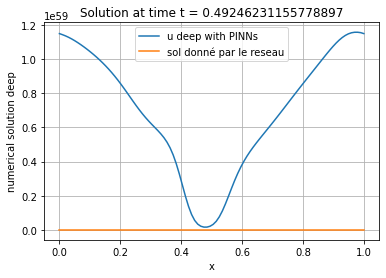

deep [4.61134527e+59 4.58624592e+59 4.56047760e+59 4.52972356e+59
 4.49402945e+59 4.45395335e+59 4.41004988e+59 4.36280730e+59
 4.31262563e+59 4.25979323e+59 4.20445863e+59 4.14661939e+59
 4.08613105e+59 4.02273270e+59 3.95608820e+59 3.88582764e+59
 3.81158219e+59 3.73302211e+59 3.64989942e+59 3.56210455e+59
 3.46974825e+59 3.37325274e+59 3.27342093e+59 3.17146089e+59
 3.06893055e+59 2.96759049e+59 2.86918617e+59 2.77519658e+59
 2.68658817e+59 2.60362511e+59 2.52574091e+59 2.45146153e+59
 2.37834687e+59 2.30286539e+59 2.22013847e+59 2.12363286e+59
 2.00515499e+59 1.85582603e+59 1.66867965e+59 1.44265682e+59
 1.18631118e+59 9.18562437e+58 6.64617954e+58 4.48064353e+58
 2.83141851e+58 1.71532106e+58 1.05062914e+58 7.19237216e+57
 6.25123432e+57 7.25417002e+57 1.03270699e+58 1.59708656e+58
 2.47542877e+58 3.69612971e+58 5.23268316e+58 7.00016626e+58
 8.87741257e+58 1.07422225e+59 1.25011126e+59 1.41025249e+59
 1.55335431e+59 1.68079198e+59 1.79528847e+59 1.89990850e+59
 1.99747476e+59 2.0

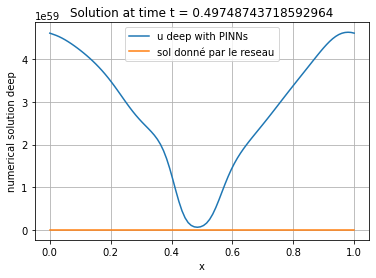

deep [1.85094151e+60 1.84122529e+60 1.83208079e+60 1.82088388e+60
 1.80756023e+60 1.79233959e+60 1.77546360e+60 1.75715313e+60
 1.73760096e+60 1.71696235e+60 1.69534045e+60 1.67277583e+60
 1.64924368e+60 1.62465915e+60 1.59889222e+60 1.57178567e+60
 1.54317210e+60 1.51289183e+60 1.48081083e+60 1.44684198e+60
 1.41097568e+60 1.37331614e+60 1.33411344e+60 1.29378323e+60
 1.25289873e+60 1.21214632e+60 1.17224895e+60 1.13386871e+60
 1.09750380e+60 1.06340221e+60 1.03149827e+60 1.00137313e+60
 9.72232036e+59 9.42868973e+59 9.11587194e+59 8.76074456e+59
 8.33312690e+59 7.79743156e+59 7.11988431e+59 6.28245225e+59
 5.29961059e+59 4.22852332e+59 3.16228523e+59 2.20398209e+59
 1.43266473e+59 8.79803495e+58 5.28955936e+58 3.35911494e+58
 2.54818189e+58 2.56728816e+58 3.35943988e+58 5.06470508e+58
 7.92023449e+58 1.21228186e+59 1.76947201e+59 2.44138323e+59
 3.18500239e+59 3.94890866e+59 4.68749713e+59 5.37036552e+59
 5.98429996e+59 6.52986991e+59 7.01595994e+59 7.45482342e+59
 7.85876862e+59 8.2

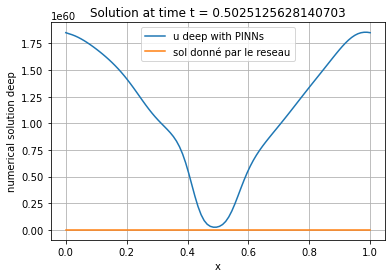

deep [7.42613817e+60 7.38890539e+60 7.35738502e+60 7.31740004e+60
 7.26826730e+60 7.21092476e+60 7.14640682e+60 7.07568212e+60
 6.99963385e+60 6.91902919e+60 6.83445447e+60 6.74625374e+60
 6.65448986e+60 6.55894087e+60 6.45914418e+60 6.35446676e+60
 6.24418227e+60 6.12755460e+60 6.00391733e+60 5.87275771e+60
 5.73383259e+60 5.58730911e+60 5.43390247e+60 5.27498581e+60
 5.11260872e+60 4.94937950e+60 4.78820956e+60 4.63194995e+60
 4.48297336e+60 4.34279556e+60 4.21177353e+60 4.08890336e+60
 3.97171187e+60 3.85614851e+60 3.73635450e+60 3.60422961e+60
 3.44891492e+60 3.25681661e+60 3.01332593e+60 2.70720377e+60
 2.33716868e+60 1.91787982e+60 1.48088855e+60 1.06765437e+60
 7.16518838e+59 4.50200578e+59 2.70822418e+59 1.64572960e+59
 1.11909898e+59 9.70351221e+58 1.12882010e+59 1.61487074e+59
 2.51163934e+59 3.91631737e+59 5.88251240e+59 8.37476510e+59
 1.12591383e+60 1.43369479e+60 1.74028289e+60 2.02965746e+60
 2.29274058e+60 2.52703974e+60 2.73468970e+60 2.92021112e+60
 3.08876886e+60 3.2

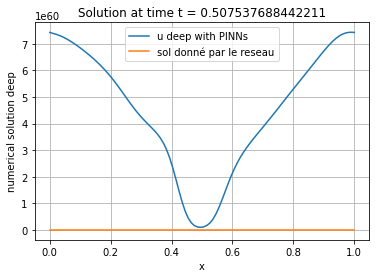

deep [2.97800784e+61 2.96391341e+61 2.95349545e+61 2.93958240e+61
 2.92174082e+61 2.90035111e+61 2.87585078e+61 2.84865524e+61
 2.81915455e+61 2.78770646e+61 2.75461117e+61 2.72008135e+61
 2.68421613e+61 2.64698806e+61 2.60825159e+61 2.56776724e+61
 2.52523356e+61 2.48032496e+61 2.43272765e+61 2.38217482e+61
 2.32849160e+61 2.27164916e+61 2.21182125e+61 2.14943696e+61
 2.08520546e+61 2.02009211e+61 1.95523897e+61 1.89183479e+61
 1.83095094e+61 1.77338094e+61 1.71950211e+61 1.66917530e+61
 1.62168852e+61 1.57571695e+61 1.52925731e+61 1.47949259e+61
 1.42257787e+61 1.35349578e+61 1.26636452e+61 1.15567183e+61
 1.01859411e+61 8.57741393e+60 6.82736939e+60 5.08979027e+60
 3.53320530e+60 2.28510024e+60 1.39436904e+60 8.31947927e+59
 5.24246744e+59 3.95717420e+59 3.98765925e+59 5.23880652e+59
 7.94065963e+59 1.24911182e+60 1.92350516e+60 2.82408648e+60
 3.91733378e+60 5.13388872e+60 6.38835071e+60 7.60341834e+60
 8.72640319e+60 9.73356180e+60 1.06248430e+61 1.14147302e+61
 1.21237476e+61 1.2

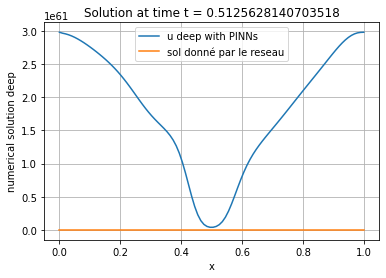

deep [1.19362714e+62 1.18837039e+62 1.18514701e+62 1.18047996e+62
 1.17412938e+62 1.16624859e+62 1.15702108e+62 1.14662227e+62
 1.13521975e+62 1.12297344e+62 1.11002700e+62 1.09649492e+62
 1.08244865e+62 1.06790655e+62 1.05283263e+62 1.03714327e+62
 1.02071928e+62 1.00342212e+62 9.85110131e+61 9.65653818e+61
 9.44953966e+61 9.22962591e+61 8.99705503e+61 8.75305670e+61
 8.49998682e+61 8.24131779e+61 7.98141599e+61 7.72509871e+61
 7.47701304e+61 7.24097728e+61 7.01936904e+61 6.81264551e+61
 6.61904991e+61 6.43443003e+61 6.25204052e+61 6.06215127e+61
 5.85129200e+61 5.60138867e+61 5.28990371e+61 4.89282972e+61
 4.39206240e+61 3.78630085e+61 3.10062775e+61 2.38757642e+61
 1.71528621e+61 1.14602671e+61 7.15995705e+60 4.27685283e+60
 2.57825203e+60 1.74117372e+60 1.50592345e+60 1.75606134e+60
 2.52440438e+60 3.94873074e+60 6.19446015e+60 9.36074750e+60
 1.34025585e+61 1.81091654e+61 2.31549835e+61 2.81956406e+61
 3.29567864e+61 3.72792013e+61 4.11157508e+61 4.44994229e+61
 4.75052234e+61 5.0

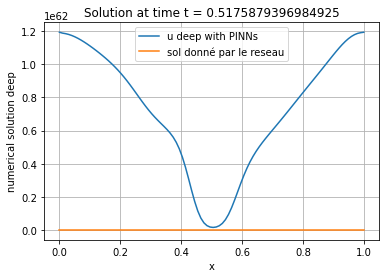

deep [4.78167213e+62 4.76242284e+62 4.75357417e+62 4.73876586e+62
 4.71676202e+62 4.68817570e+62 4.65377201e+62 4.61428354e+62
 4.57041614e+62 4.52286189e+62 4.47227554e+62 4.41922457e+62
 4.36412448e+62 4.30718010e+62 4.24835979e+62 4.18740523e+62
 4.12387143e+62 4.05719200e+62 3.98675031e+62 3.91194729e+62
 3.83227696e+62 3.74740926e+62 3.65727913e+62 3.56218497e+62
 3.46286733e+62 3.36053503e+62 3.25681406e+62 3.15360570e+62
 3.05286021e+62 2.95631553e+62 2.86523538e+62 2.78018803e+62
 2.70089803e+62 2.62615464e+62 2.55374170e+62 2.48032856e+62
 2.40123060e+62 2.31004461e+62 2.19843492e+62 2.05669093e+62
 1.87582618e+62 1.65145327e+62 1.38824786e+62 1.10237623e+62
 8.19285480e+61 5.66499869e+61 3.64556336e+61 2.21044915e+61
 1.30876342e+61 8.18207263e+60 6.14430233e+60 6.19218929e+60
 8.16683694e+60 1.24455988e+61 1.96944088e+61 3.05138091e+61
 4.50677316e+61 6.28542203e+61 8.27558442e+61 1.03356853e+62
 1.23347423e+62 1.41816617e+62 1.58340450e+62 1.72901582e+62
 1.85735944e+62 1.9

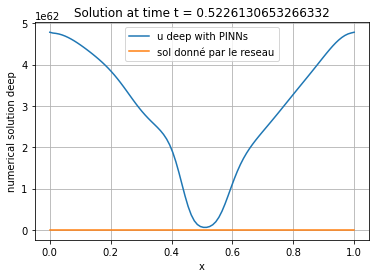

deep [1.91446928e+63 1.90758235e+63 1.90576592e+63 1.90149351e+63
 1.89415533e+63 1.88399389e+63 1.87132648e+63 1.85645693e+63
 1.83967819e+63 1.82128238e+63 1.80155692e+63 1.78076747e+63
 1.75913051e+63 1.73678371e+63 1.71376704e+63 1.69001827e+63
 1.66538340e+63 1.63964094e+63 1.61253178e+63 1.58378906e+63
 1.55317054e+63 1.52049228e+63 1.48566394e+63 1.44872908e+63
 1.40990134e+63 1.36958496e+63 1.32836850e+63 1.28698333e+63
 1.24622466e+63 1.20685145e+63 1.16947786e+63 1.13447469e+63
 1.10189732e+63 1.07143863e+63 1.04239874e+63 1.01365353e+63
 9.83584340e+62 9.49947486e+62 9.09736586e+62 8.59218885e+62
 7.94452923e+62 7.12533448e+62 6.13383567e+62 5.01280707e+62
 3.84962297e+62 2.75614418e+62 1.83338489e+62 1.13901385e+62
 6.75576386e+61 4.03969990e+61 2.70883518e+61 2.33652689e+61
 2.73092288e+61 3.94479377e+61 6.20605328e+61 9.79536746e+61
 1.48934378e+62 2.14477862e+62 2.91275610e+62 3.74001401e+62
 4.56880683e+62 5.35222555e+62 6.06243771e+62 6.69066713e+62
 7.24198221e+62 7.7

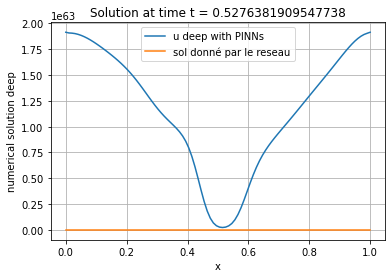

deep [7.66064072e+63 7.63673963e+63 7.63676531e+63 7.62669985e+63
 7.60362048e+63 7.56847139e+63 7.52256052e+63 7.46714188e+63
 7.40341927e+63 7.33260233e+63 7.25591564e+63 7.17455029e+63
 7.08955725e+63 7.00171232e+63 6.91140788e+63 6.81859769e+63
 6.72280776e+63 6.62321714e+63 6.51877643e+63 6.40833611e+63
 6.29078694e+63 6.16520060e+63 6.03097176e+63 5.88798106e+63
 5.73675215e+63 5.57856504e+63 5.41548264e+63 5.25024561e+63
 5.08601142e+63 4.92598491e+63 4.77298301e+63 4.62900918e+63
 4.49491688e+63 4.37017249e+63 4.25270737e+63 4.13881267e+63
 4.02294158e+63 3.89729033e+63 3.75120228e+63 3.57084232e+63
 3.34019310e+63 3.04464536e+63 2.67742970e+63 2.24684470e+63
 1.78000964e+63 1.31892186e+63 9.08476274e+62 5.81750304e+62
 3.50515573e+62 2.05929005e+62 1.27702886e+62 9.53841922e+61
 9.61232118e+61 1.27265309e+62 1.94990117e+62 3.10421732e+62
 4.83967164e+62 7.19151524e+62 1.00852277e+63 1.33411514e+63
 1.67245299e+63 2.00136373e+63 2.30513140e+63 2.57622602e+63
 2.81408697e+63 3.0

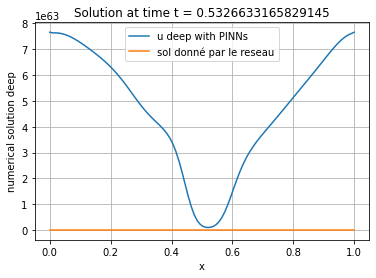

deep [3.06352988e+64 3.05557648e+64 3.05865015e+64 3.05759550e+64
 3.05104027e+64 3.03934368e+64 3.02304073e+64 3.00264694e+64
 2.97865383e+64 2.95155522e+64 2.92186057e+64 2.89008576e+64
 2.85671564e+64 2.82214704e+64 2.78663465e+64 2.75025352e+64
 2.71288853e+64 2.67425643e+64 2.63394945e+64 2.59148836e+64
 2.54638302e+64 2.49819226e+64 2.44658236e+64 2.39139296e+64
 2.33270292e+64 2.27088511e+64 2.20663456e+64 2.14094995e+64
 2.07505322e+64 2.01025889e+64 1.94780513e+64 1.88867584e+64
 1.83344885e+64 1.78218068e+64 1.73433151e+64 1.68872156e+64
 1.64347439e+64 1.59589254e+64 1.54224154e+64 1.47752535e+64
 1.39556703e+64 1.28991132e+64 1.15591076e+64 9.93660040e+63
 8.10437020e+63 6.20750024e+63 4.42935050e+63 2.93372851e+63
 1.81249922e+63 1.06743580e+63 6.33033485e+62 4.21381679e+62
 3.62415843e+62 4.24529433e+62 6.16182044e+62 9.75024002e+62
 1.54856786e+63 2.36935306e+63 3.43223425e+63 4.68546195e+63
 6.04186897e+63 7.40467449e+63 8.69378319e+63 9.86069068e+63
 1.08892613e+64 1.1

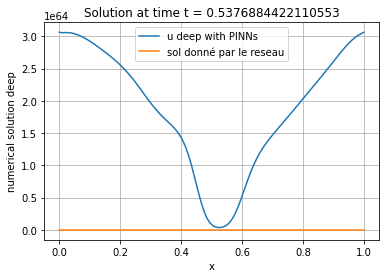

deep [1.22437281e+65 1.22188753e+65 1.22439415e+65 1.22522156e+65
 1.22373548e+65 1.22006809e+65 1.21443593e+65 1.20705000e+65
 1.19811018e+65 1.18781609e+65 1.17637568e+65 1.16400615e+65
 1.15092245e+65 1.13731490e+65 1.12332456e+65 1.10902239e+65
 1.09439846e+65 1.07936523e+65 1.06377203e+65 1.04742585e+65
 1.03011688e+65 1.01164425e+65 9.91840599e+64 9.70599010e+64
 9.47900149e+64 9.23836915e+64 8.98631435e+64 8.72636279e+64
 8.46312211e+64 8.20184245e+64 7.94778355e+64 7.70549347e+64
 7.47814659e+64 7.26700300e+64 7.07103261e+64 6.88670381e+64
 6.70779956e+64 6.52506592e+64 6.32551471e+64 6.09142698e+64
 5.79985954e+64 5.42445219e+64 4.94150956e+64 4.34063054e+64
 3.63645145e+64 2.87436684e+64 2.12356300e+64 1.45722700e+64
 9.28623173e+63 5.55991353e+63 3.24090361e+63 1.99313477e+63
 1.48037619e+63 1.49155652e+63 1.98230466e+63 3.05369322e+63
 4.89131779e+63 7.67475696e+63 1.14752837e+64 1.61836983e+64
 2.15110635e+64 2.70681574e+64 3.24799544e+64 3.74758442e+64
 4.19227647e+64 4.5

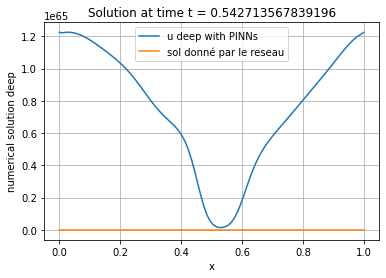

deep [4.89030709e+65 4.88333084e+65 4.89863812e+65 4.90716448e+65
 4.90601478e+65 4.89565179e+65 4.87693966e+65 4.85073668e+65
 4.81785348e+65 4.77909171e+65 4.73528796e+65 4.68733562e+65
 4.63615685e+65 4.58262203e+65 4.52744506e+65 4.47108078e+65
 4.41365437e+65 4.35494833e+65 4.29444205e+65 4.23138768e+65
 4.16491467e+65 4.09413938e+65 4.01827009e+65 3.93671847e+65
 3.84921128e+65 3.75589660e+65 3.65742985e+65 3.55500888e+65
 3.45032384e+65 3.34541875e+65 3.24246334e+65 3.14346986e+65
 3.05001329e+65 2.96298639e+65 2.88241679e+65 2.80735880e+65
 2.73582068e+65 2.66466463e+65 2.58940047e+65 2.50381850e+65
 2.39962334e+65 2.26661602e+65 2.09424562e+65 1.87508773e+65
 1.60966314e+65 1.31031380e+65 1.00107609e+65 7.11982139e+64
 4.69584614e+64 2.88515848e+64 1.68706020e+64 9.92088499e+63
 6.55388912e+63 5.61924753e+63 6.59628065e+63 9.62023085e+63
 1.53126205e+64 2.44761467e+64 3.76909395e+64 5.49297199e+64
 7.53838018e+64 9.76263971e+64 1.20036038e+65 1.41246835e+65
 1.60416021e+65 1.7

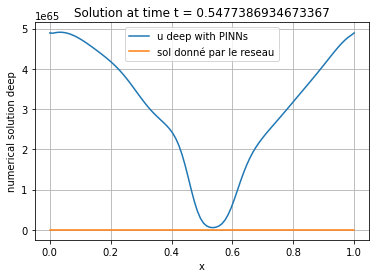

deep [1.95203775e+66 1.95048935e+66 1.95877693e+66 1.96435014e+66
 1.96590151e+66 1.96358080e+66 1.95772654e+66 1.94868476e+66
 1.93678322e+66 1.92234264e+66 1.90569599e+66 1.88720376e+66
 1.86725089e+66 1.84622052e+66 1.82445265e+66 1.80219743e+66
 1.77957663e+66 1.75656682e+66 1.73300557e+66 1.70861645e+66
 1.68304983e+66 1.65592879e+66 1.62689411e+66 1.59565112e+66
 1.56201592e+66 1.52596020e+66 1.48765109e+66 1.44747547e+66
 1.40603439e+66 1.36410348e+66 1.32255425e+66 1.28224658e+66
 1.24391407e+66 1.20805652e+66 1.17485393e+66 1.14411146e+66
 1.11522541e+66 1.08715188e+66 1.05834926e+66 1.02665826e+66
 9.89135302e+65 9.41984113e+65 8.80874777e+65 8.01967894e+65
 7.03676217e+65 5.88561187e+65 4.64198486e+65 3.41973581e+65
 2.33809710e+65 1.48282049e+65 8.82206276e+64 5.10155623e+64
 3.11065838e+64 2.29680278e+64 2.31333299e+64 3.08603750e+64
 4.78014869e+64 7.70499537e+64 1.21692659e+65 1.83119098e+65
 2.59745786e+65 3.46925034e+65 4.38203099e+65 5.27241126e+65
 6.09388857e+65 6.8

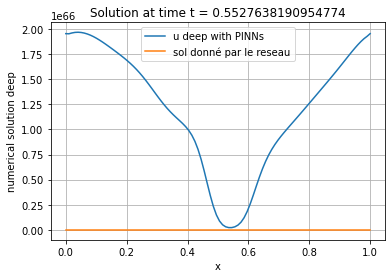

deep [7.78701649e+66 7.78594157e+66 7.82788480e+66 7.85907430e+66
 7.87366112e+66 7.87206461e+66 7.85557942e+66 7.82558360e+66
 7.78339605e+66 7.73029703e+66 7.66760229e+66 7.59674402e+66
 7.51929224e+66 7.43688104e+66 7.35105707e+66 7.26308089e+66
 7.17373768e+66 7.08322193e+66 6.99111683e+66 6.89646201e+66
 6.79790394e+66 6.69388233e+66 6.58282120e+66 6.46332814e+66
 6.33438707e+66 6.19554612e+66 6.04709372e+66 5.89018869e+66
 5.72689060e+66 5.56006396e+66 5.39312175e+66 5.22963101e+66
 5.07285812e+66 4.92531099e+66 4.78834721e+66 4.66190283e+66
 4.54432127e+66 4.43223460e+66 4.32040621e+66 4.20137136e+66
 4.06481446e+66 3.89699339e+66 3.68109984e+66 3.39990504e+66
 3.04157840e+66 2.60755553e+66 2.11867110e+66 1.61468916e+66
 1.14475407e+66 7.51887347e+65 4.59425052e+65 2.66710271e+65
 1.55490924e+65 1.01909986e+65 8.70842306e+64 1.02433884e+65
 1.50118683e+65 2.40393218e+65 3.86793966e+65 5.99594087e+65
 8.79254867e+65 1.21315157e+66 1.57791953e+66 1.94639702e+66
 2.29532180e+66 2.6

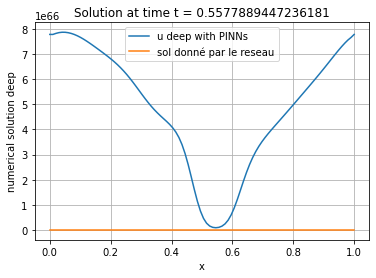

deep [3.10447692e+67 3.10612170e+67 3.12643709e+67 3.14254297e+67
 3.15184575e+67 3.15442578e+67 3.15076308e+67 3.14139728e+67
 3.12685526e+67 3.10764694e+67 3.08428993e+67 3.05734654e+67
 3.02744458e+67 2.99526242e+67 2.96147812e+67 2.92669023e+67
 2.89133146e+67 2.85560438e+67 2.81945297e+67 2.78257316e+67
 2.74446360e+67 2.70449827e+67 2.66200621e+67 2.61635627e+67
 2.56703844e+67 2.51374264e+67 2.45643448e+67 2.39541779e+67
 2.33136492e+67 2.26530237e+67 2.19853324e+67 2.13249830e+67
 2.06860130e+67 2.00801984e+67 1.95153231e+67 1.89938875e+67
 1.85122440e+67 1.80600604e+67 1.76198552e+67 1.71659886e+67
 1.66626005e+67 1.60609093e+67 1.52982185e+67 1.43034748e+67
 1.30145827e+67 1.14074257e+67 9.52640224e+66 7.49768289e+66
 5.50839811e+66 3.75265504e+66 2.36862459e+66 1.40028080e+66
 8.03184443e+65 4.85414579e+65 3.56192420e+65 3.58573610e+65
 4.80149929e+65 7.47927472e+65 1.21341624e+66 1.92955514e+66
 2.92263618e+66 4.16998900e+66 5.59680869e+66 7.09604730e+66
 8.56064296e+66 9.9

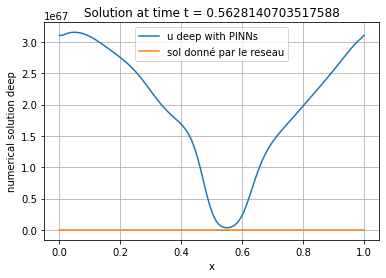

deep [1.23693347e+68 1.23841819e+68 1.24795418e+68 1.25586508e+68
 1.26101042e+68 1.26338150e+68 1.26314912e+68 1.26051999e+68
 1.25570227e+68 1.24889837e+68 1.24031136e+68 1.23016013e+68
 1.21869163e+68 1.20618095e+68 1.19291628e+68 1.17916931e+68
 1.16515832e+68 1.15101607e+68 1.13677015e+68 1.12233924e+68
 1.10754808e+68 1.09215412e+68 1.07587986e+68 1.05844863e+68
 1.03961911e+68 1.01921858e+68 9.97175104e+67 9.73545871e+67
 9.48535415e+67 9.22498680e+67 8.95920152e+67 8.69367257e+67
 8.43425492e+67 8.18622614e+67 7.95354449e+67 7.73825433e+67
 7.54005978e+67 7.35605924e+67 7.18057923e+67 7.00489814e+67
 6.81662242e+67 6.59866074e+67 6.32829203e+67 5.97784390e+67
 5.51923033e+67 4.93361784e+67 4.22423215e+67 3.42613387e+67
 2.60499525e+67 1.84115261e+67 1.20434535e+67 7.31840761e+66
 4.21754910e+66 2.43701290e+66 1.58409631e+66 1.34878084e+66
 1.58967699e+66 2.34125930e+66 3.77266292e+66 6.11198756e+66
 9.53975136e+66 1.40779376e+67 1.95295278e+67 2.55115809e+67
 3.15691956e+67 3.7

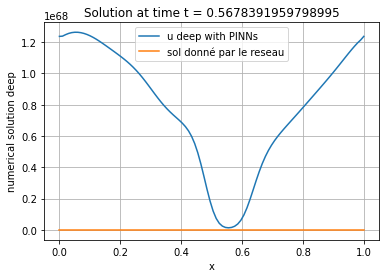

deep [4.92553317e+68 4.93470923e+68 4.97841488e+68 5.01594694e+68
 5.04233062e+68 5.05734723e+68 5.06157044e+68 5.05576974e+68
 5.04075456e+68 5.01732347e+68 4.98627174e+68 4.94844629e+68
 4.90480568e+68 4.85644290e+68 4.80455041e+68 4.75031745e+68
 4.69478107e+68 4.63867819e+68 4.58233487e+68 4.52561681e+68
 4.46796075e+68 4.40846532e+68 4.34601690e+68 4.27943800e+68
 4.20763394e+68 4.12973379e+68 4.04522684e+68 3.95408696e+68
 3.85686548e+68 3.75473464e+68 3.64944380e+68 3.54317231e+68
 3.43829781e+68 3.33710143e+68 3.24145884e+68 3.15257505e+68
 3.07078082e+68 2.99539910e+68 2.92467153e+68 2.85567835e+68
 2.78416204e+68 2.70418477e+68 2.60767873e+68 2.48430059e+68
 2.32240984e+68 2.11197067e+68 1.84931626e+68 1.54209137e+68
 1.21125970e+68 8.87533931e+67 6.02519999e+67 3.78501988e+67
 2.22329063e+67 1.26465911e+67 7.57307548e+66 5.52080183e+66
 5.55419212e+66 7.46591818e+66 1.16974058e+67 1.91064278e+67
 3.05978611e+67 4.66583733e+67 6.69680769e+67 9.03214455e+67
 1.14942250e+68 1.3

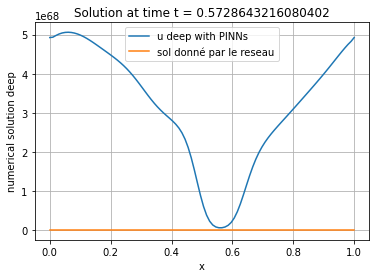

deep [1.96028746e+69 1.96520163e+69 1.98485545e+69 2.00220777e+69
 2.01510541e+69 2.02338079e+69 2.02721014e+69 2.02686924e+69
 2.02266618e+69 2.01491292e+69 2.00391996e+69 1.99001380e+69
 1.97356261e+69 1.95499311e+69 1.93478716e+69 1.91344956e+69
 1.89145131e+69 1.86916564e+69 1.84681238e+69 1.82442374e+69
 1.80184354e+69 1.77875432e+69 1.75472378e+69 1.72926484e+69
 1.70189731e+69 1.67220794e+69 1.63990831e+69 1.60488847e+69
 1.56726073e+69 1.52738775e+69 1.48587984e+69 1.44355252e+69
 1.40134732e+69 1.36022082e+69 1.32101961e+69 1.28436555e+69
 1.25056162e+69 1.21952602e+69 1.19075540e+69 1.16329745e+69
 1.13570257e+69 1.10592001e+69 1.07112419e+69 1.02756277e+69
 9.70687510e+68 8.95923216e+68 8.00266862e+68 6.84381022e+68
 5.54144238e+68 4.20381315e+68 2.96223216e+68 1.92981609e+68
 1.16619342e+68 6.67057814e+67 3.81913390e+67 2.46115998e+67
 2.08755635e+67 2.46531996e+67 3.64950563e+67 5.91923996e+67
 9.65829429e+67 1.51817436e+68 2.25483024e+68 3.14502516e+68
 4.12593574e+68 5.1

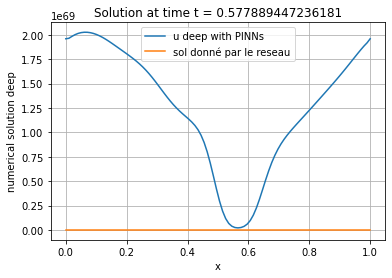

deep [7.79755480e+69 7.82189183e+69 7.90889691e+69 7.98751378e+69
 8.04849272e+69 8.09082524e+69 8.11497004e+69 8.12186500e+69
 8.11264961e+69 8.08852450e+69 8.05069569e+69 8.00041834e+69
 7.93909551e+69 7.86836835e+69 7.79014366e+69 7.70650738e+69
 7.61952235e+69 7.53096675e+69 7.44207581e+69 7.35334907e+69
 7.26448796e+69 7.17445689e+69 7.08164238e+69 6.98408742e+69
 6.87974691e+69 6.76674245e+69 6.64360880e+69 6.50952358e+69
 6.36450473e+69 6.20955920e+69 6.04672583e+69 5.87897050e+69
 5.70993042e+69 5.54351050e+69 5.38339209e+69 5.23255067e+69
 5.09283395e+69 4.96464573e+69 4.84675773e+69 4.73619278e+69
 4.62808739e+69 4.51539977e+69 4.38832163e+69 4.23352654e+69
 4.03398036e+69 3.77062765e+69 3.42723068e+69 2.99822058e+69
 2.49666486e+69 1.95729871e+69 1.43050594e+69 9.67764265e+68
 6.05063712e+68 3.53091342e+68 1.99129469e+68 1.18107582e+68
 8.55117743e+67 8.59679882e+67 1.16016075e+68 1.82880291e+68
 3.00836556e+68 4.85304097e+68 7.45134865e+68 1.07588330e+69
 1.45809084e+69 1.8

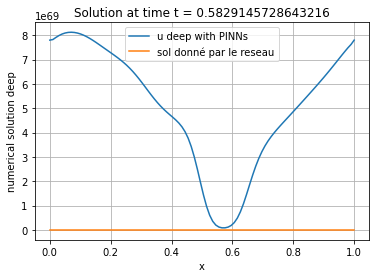

deep [3.10015584e+70 3.11161051e+70 3.14961901e+70 3.18465482e+70
 3.21277267e+70 3.23343073e+70 3.24670323e+70 3.25288505e+70
 3.25238153e+70 3.24564509e+70 3.23313993e+70 3.21534701e+70
 3.19279797e+70 3.16611616e+70 3.13604218e+70 3.10341767e+70
 3.06911866e+70 3.03395460e+70 2.99855550e+70 2.96327484e+70
 2.92813985e+70 2.89285350e+70 2.85684281e+70 2.81934623e+70
 2.77951678e+70 2.73652921e+70 2.68968497e+70 2.63851030e+70
 2.58284329e+70 2.52290550e+70 2.45933805e+70 2.39318453e+70
 2.32581449e+70 2.25878247e+70 2.19364066e+70 2.13174194e+70
 2.07405625e+70 2.02102369e+70 1.97245993e+70 1.92749906e+70
 1.88454826e+70 1.84120954e+70 1.79409887e+70 1.73855140e+70
 1.66838157e+70 1.57612031e+70 1.45430906e+70 1.29815556e+70
 1.10894213e+70 8.96482993e+69 6.78605191e+69 4.76770862e+69
 3.09346696e+69 1.85888284e+69 1.05513990e+69 5.98377116e+68
 3.82154404e+68 3.22844823e+68 3.82056959e+68 5.68615118e+68
 9.28590069e+68 1.52645299e+69 2.41685733e+69 3.61292820e+69
 5.06652576e+69 6.6

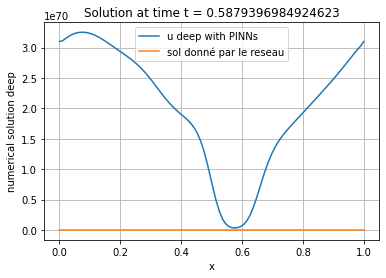

deep [1.23199999e+71 1.23719605e+71 1.25361130e+71 1.26901094e+71
 1.28172341e+71 1.29147695e+71 1.29825462e+71 1.30213718e+71
 1.30326114e+71 1.30179203e+71 1.29790596e+71 1.29178629e+71
 1.28363355e+71 1.27368209e+71 1.26221486e+71 1.24956421e+71
 1.23609229e+71 1.22215427e+71 1.20805181e+71 1.19398755e+71
 1.18003565e+71 1.16613254e+71 1.15208842e+71 1.13761775e+71
 1.12237959e+71 1.10602195e+71 1.08822625e+71 1.06874926e+71
 1.04746092e+71 1.02437724e+71 9.99681255e+70 9.73725332e+70
 9.47011070e+70 9.20142294e+70 8.93755937e+70 8.68443877e+70
 8.44675250e+70 8.22730244e+70 8.02654026e+70 7.84227664e+70
 7.66949604e+70 7.50014367e+70 7.32260984e+70 7.12071848e+70
 6.87250056e+70 6.54992857e+70 6.12179305e+70 5.56180707e+70
 4.86148743e+70 4.04298739e+70 3.16377680e+70 2.30648051e+70
 1.55500626e+70 9.67546987e+69 5.60853980e+69 3.13510521e+69
 1.84109530e+69 1.32347059e+69 1.32956834e+69 1.80179461e+69
 2.85849227e+69 4.73711634e+69 7.69961259e+69 1.19045590e+70
 1.72912222e+70 2.3

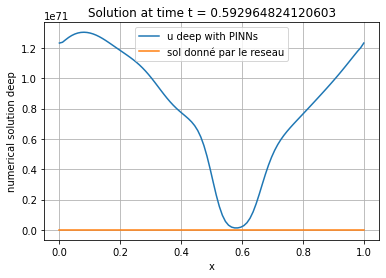

deep [4.89391907e+71 4.91681798e+71 4.98700627e+71 5.05389861e+71
 5.11045651e+71 5.15538031e+71 5.18841002e+71 5.20970382e+71
 5.21968400e+71 5.21893189e+71 5.20810147e+71 5.18788557e+71
 5.15903711e+71 5.12242983e+71 5.07912919e+71 5.03042216e+71
 4.97777005e+71 4.92268398e+71 4.86654222e+71 4.81039009e+71
 4.75478680e+71 4.69972658e+71 4.64464706e+71 4.58852636e+71
 4.53003377e+71 4.46770890e+71 4.40014855e+71 4.32618535e+71
 4.24505137e+71 4.15652449e+71 4.06103489e+71 3.95970738e+71
 3.85432150e+71 3.74716433e+71 3.64078448e+71 3.53769104e+71
 3.44003391e+71 3.34931383e+71 3.26616564e+71 3.19021194e+71
 3.11997462e+71 3.05280871e+71 2.98476237e+71 2.91026178e+71
 2.82162234e+71 2.70865733e+71 2.55909672e+71 2.36077762e+71
 2.10603213e+71 1.79722895e+71 1.45071275e+71 1.09581983e+71
 7.67647205e+70 4.96041776e+70 2.96363570e+70 1.66898454e+70
 9.37207785e+69 5.92971551e+69 4.98869803e+69 5.91683347e+69
 8.85613458e+69 1.45671054e+70 2.41311153e+70 3.84902492e+70
 5.79129098e+70 8.1

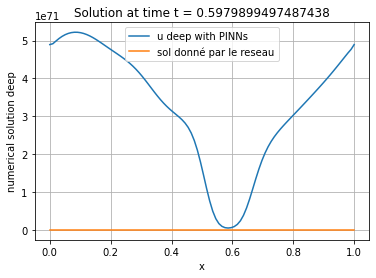

deep [1.94329811e+72 1.95314975e+72 1.98289587e+72 2.01165527e+72
 2.03648053e+72 2.05677206e+72 2.07234930e+72 2.08320508e+72
 2.08945134e+72 2.09128033e+72 2.08892751e+72 2.08265087e+72
 2.07273135e+72 2.05949239e+72 2.04333014e+72 2.02473417e+72
 2.00428128e+72 1.98259713e+72 1.96028852e+72 1.93785964e+72
 1.91563916e+72 1.89373204e+72 1.87200619e+72 1.85011838e+72
 1.82756730e+72 1.80376372e+72 1.77810777e+72 1.75006462e+72
 1.71923490e+72 1.68541888e+72 1.64866694e+72 1.60930817e+72
 1.56794972e+72 1.52543472e+72 1.48275828e+72 1.44095520e+72
 1.40097202e+72 1.36354351e+72 1.32909390e+72 1.29766549e+72
 1.26887385e+72 1.24188198e+72 1.21536198e+72 1.18740400e+72
 1.15534679e+72 1.11557243e+72 1.06346813e+72 9.93921570e+71
 9.02669431e+71 7.88406922e+71 6.54871153e+71 5.11557750e+71
 3.72019829e+71 2.49941937e+71 1.54755698e+71 8.90919739e+70
 4.93483026e+70 2.86828309e+70 2.04664331e+70 2.05470877e+70
 2.79692591e+70 4.46734781e+70 7.46067675e+70 1.22203755e+71
 1.90268282e+71 2.7

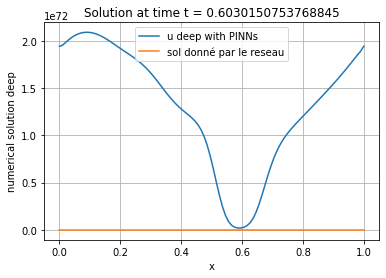

deep [7.71395110e+72 7.75545074e+72 7.88052164e+72 8.00305538e+72
 8.11076884e+72 8.20097344e+72 8.27265204e+72 8.32548568e+72
 8.35967000e+72 8.37578215e+72 8.37463242e+72 8.35716030e+72
 8.32440376e+72 8.27755154e+72 8.21806011e+72 8.14776177e+72
 8.06888741e+72 7.98396506e+72 7.89558369e+72 7.80606020e+72
 7.71711287e+72 7.62960765e+72 7.54343425e+72 7.45754792e+72
 7.37014056e+72 7.27890479e+72 7.18134613e+72 7.07510057e+72
 6.95823623e+72 6.82953190e+72 6.68870728e+72 6.53657860e+72
 6.37511179e+72 6.20732082e+72 6.03699554e+72 5.86829699e+72
 5.70525959e+72 5.55127950e+72 5.40867777e+72 5.27836297e+72
 5.15960616e+72 5.04991779e+72 4.94493064e+72 4.83814961e+72
 4.72041999e+72 4.57909681e+72 4.39740046e+72 4.15517324e+72
 3.83255384e+72 3.41720922e+72 2.91340334e+72 2.34829300e+72
 1.77015231e+72 1.23639244e+72 7.95612330e+71 4.72546714e+71
 2.63961459e+71 1.46724346e+71 9.19385879e+70 7.70225340e+70
 9.15771309e+70 1.37898284e+71 2.28540792e+71 3.81605214e+71
 6.13231441e+71 9.2

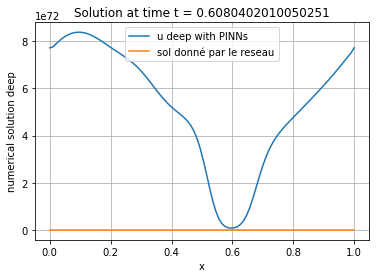

deep [3.06117190e+73 3.07831791e+73 3.13053211e+73 3.18232189e+73
 3.22858902e+73 3.26815561e+73 3.30050504e+73 3.32539422e+73
 3.34279395e+73 3.35284736e+73 3.35581465e+73 3.35202654e+73
 3.34186050e+73 3.32574963e+73 3.30422390e+73 3.27795885e+73
 3.24780113e+73 3.21474953e+73 3.17987887e+73 3.14421383e+73
 3.10859061e+73 3.07353445e+73 3.03918201e+73 3.00527038e+73
 2.97118433e+73 2.93605038e+73 2.89885938e+73 2.85859770e+73
 2.81437540e+73 2.76554644e+73 2.71181122e+73 2.65329346e+73
 2.59058162e+73 2.52471366e+73 2.45709505e+73 2.38935853e+73
 2.32317629e+73 2.26005348e+73 2.20114065e+73 2.14707928e+73
 2.09789162e+73 2.05291758e+73 2.01077052e+73 1.96926849e+73
 1.92528010e+73 1.87443259e+73 1.81076672e+73 1.72669099e+73
 1.61382199e+73 1.46522097e+73 1.27886897e+73 1.06104052e+73
 8.27418646e+72 6.00234837e+72 4.01845820e+72 2.47561024e+72
 1.41515791e+72 7.76517316e+71 4.46568405e+71 3.16229279e+71
 3.17306130e+71 4.33999159e+71 6.98161500e+71 1.17532567e+72
 1.94029248e+72 3.0

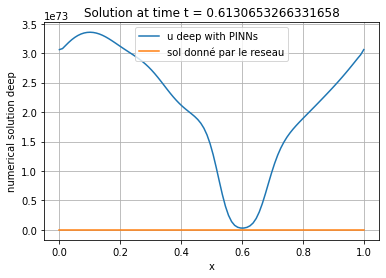

deep [1.21448070e+74 1.22143390e+74 1.24309214e+74 1.26482491e+74
 1.28452296e+74 1.30168010e+74 1.31605030e+74 1.32749190e+74
 1.33594904e+74 1.34144033e+74 1.34403990e+74 1.34385829e+74
 1.34102938e+74 1.33570903e+74 1.32808802e+74 1.31841192e+74
 1.30699638e+74 1.29422783e+74 1.28054159e+74 1.26637662e+74
 1.25211970e+74 1.23804999e+74 1.22429754e+74 1.21082705e+74
 1.19744671e+74 1.18383913e+74 1.16960776e+74 1.15432991e+74
 1.13761061e+74 1.11913410e+74 1.09870889e+74 1.07630383e+74
 1.05207179e+74 1.02635315e+74 9.99653731e+73 9.72598559e+73
 9.45863216e+73 9.20092835e+73 8.95823709e+73 8.73414706e+73
 8.52995008e+73 8.34431789e+73 8.17309943e+73 8.00911356e+73
 7.84172697e+73 7.65592519e+73 7.43089734e+73 7.13900598e+73
 6.74710409e+73 6.22267165e+73 5.54580521e+73 4.72401884e+73
 3.80238933e+73 2.86032550e+73 1.99188496e+73 1.27630468e+73
 7.53467728e+72 4.17379206e+72 2.29587136e+72 1.42435736e+72
 1.18823188e+72 1.41664152e+72 2.14690355e+72 3.58618949e+72
 6.03675163e+72 9.7

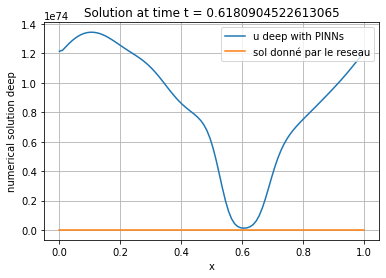

deep [4.81730518e+74 4.84497801e+74 4.93429112e+74 5.02490321e+74
 5.10810875e+74 5.18176712e+74 5.24475849e+74 5.29635143e+74
 5.33614687e+74 5.36405530e+74 5.38023748e+74 5.38503302e+74
 5.37889855e+74 5.36238417e+74 5.33616814e+74 5.30113093e+74
 5.25842933e+74 5.20952911e+74 5.15615379e+74 5.10013226e+74
 5.04318421e+74 4.98668270e+74 4.93145102e+74 4.87765089e+74
 4.82477191e+74 4.77172118e+74 4.71699040e+74 4.65886430e+74
 4.59564362e+74 4.52586368e+74 4.44849037e+74 4.36308387e+74
 4.26991940e+74 4.17003574e+74 4.06518917e+74 3.95771043e+74
 3.85026282e+74 3.74553344e+74 3.64591455e+74 3.55320741e+74
 3.46838210e+74 3.39141675e+74 3.32119575e+74 3.25543413e+74
 3.19056349e+74 3.12145830e+74 3.04093250e+74 2.93917132e+74
 2.80367002e+74 2.62064996e+74 2.37879264e+74 2.07494612e+74
 1.71962129e+74 1.33869824e+74 9.68695478e+73 6.46180772e+73
 3.96034711e+73 2.24753154e+73 1.22141490e+73 6.94800805e+72
 4.88206619e+72 4.89697886e+72 6.73251380e+72 1.09117705e+73
 1.85210830e+73 3.0

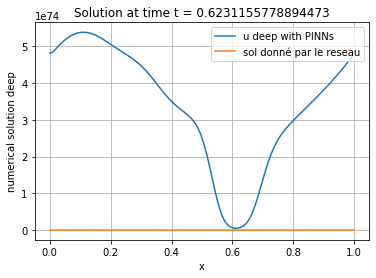

deep [1.91049835e+75 1.92129565e+75 1.95792982e+75 1.99549051e+75
 2.03039025e+75 2.06173593e+75 2.08903494e+75 2.11193585e+75
 2.13021163e+75 2.14375923e+75 2.15258366e+75 2.15677355e+75
 2.15647506e+75 2.15187658e+75 2.14321515e+75 2.13080185e+75
 2.11505358e+75 2.09651579e+75 2.07585643e+75 2.05381867e+75
 2.03114261e+75 2.00846823e+75 1.98624248e+75 1.96465667e+75
 1.94362273e+75 1.92279263e+75 1.90161453e+75 1.87941195e+75
 1.85547406e+75 1.82914749e+75 1.79992069e+75 1.76749687e+75
 1.73185170e+75 1.69326528e+75 1.65231971e+75 1.60985906e+75
 1.56690768e+75 1.52455619e+75 1.48383542e+75 1.44559202e+75
 1.41038130e+75 1.37839001e+75 1.34938471e+75 1.32267827e+75
 1.29709669e+75 1.27090268e+75 1.24163351e+75 1.20586456e+75
 1.15903968e+75 1.09569713e+75 1.01050324e+75 9.00232090e+74
 7.66193658e+74 6.15857598e+74 4.62303689e+74 3.20957974e+74
 2.04754179e+74 1.20127533e+74 6.59777997e+73 3.59051894e+73
 2.20497286e+73 1.83174264e+73 2.19054882e+73 3.34230503e+73
 5.62855997e+73 9.5

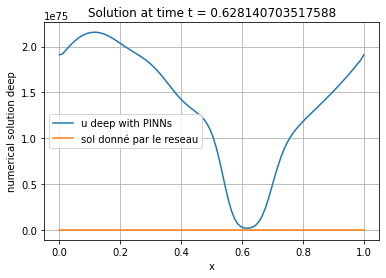

deep [7.57593176e+75 7.61714380e+75 7.76667424e+75 7.92155573e+75
 8.06701631e+75 8.19937063e+75 8.31650956e+75 8.41682582e+75
 8.49916194e+75 8.56283910e+75 8.60762701e+75 8.63366934e+75
 8.64138359e+75 8.63138364e+75 8.60447755e+75 8.56174517e+75
 8.50466335e+75 8.43522418e+75 8.35596377e+75 8.26983304e+75
 8.17992860e+75 8.08911354e+75 7.99961474e+75 7.91270865e+75
 7.82854745e+75 7.74616220e+75 7.66363231e+75 7.57837242e+75
 7.48748898e+75 7.38815940e+75 7.27799182e+75 7.15534521e+75
 7.01959482e+75 6.87130590e+75 6.71228336e+75 6.54547955e+75
 6.37473353e+75 6.20436361e+75 6.03868360e+75 5.88149397e+75
 5.73561675e+75 5.60253722e+75 5.48214810e+75 5.37258482e+75
 5.27010948e+75 5.16890059e+75 5.06056832e+75 4.93330529e+75
 4.77093149e+75 4.55280911e+75 4.25626109e+75 3.86277122e+75
 3.36740086e+75 2.78769534e+75 2.16641730e+75 1.56361189e+75
 1.03915561e+75 6.33517728e+74 3.56874934e+74 1.92040618e+74
 1.08029770e+74 7.53128723e+73 7.55335163e+73 1.04420747e+74
 1.70563550e+74 2.9

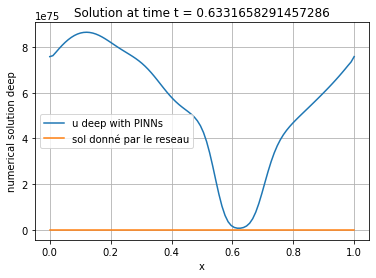

deep [3.00392943e+76 3.01925912e+76 3.08001841e+76 3.14358055e+76
 3.20386334e+76 3.25935958e+76 3.30918584e+76 3.35263360e+76
 3.38915110e+76 3.41836479e+76 3.44008033e+76 3.45426390e+76
 3.46100735e+76 3.46049411e+76 3.45298882e+76 3.43885778e+76
 3.41861428e+76 3.39297213e+76 3.36287521e+76 3.32947000e+76
 3.29401974e+76 3.25776310e+76 3.22174760e+76 3.18668311e+76
 3.15284202e+76 3.12002857e+76 3.08761995e+76 3.05466404e+76
 3.02001548e+76 2.98248933e+76 2.94101240e+76 2.89476205e+76
 2.84328540e+76 2.78658557e+76 2.72516342e+76 2.66000680e+76
 2.59251364e+76 2.52435216e+76 2.45728074e+76 2.39294541e+76
 2.33268344e+76 2.27736208e+76 2.22725588e+76 2.18196399e+76
 2.14036002e+76 2.10053038e+76 2.05963696e+76 2.01364121e+76
 1.95690183e+76 1.88189317e+76 1.77960510e+76 1.64127006e+76
 1.46164915e+76 1.24299443e+76 9.97700552e+75 7.47330846e+75
 5.17210984e+75 3.28471189e+75 1.91493204e+75 1.04261902e+75
 5.61222564e+74 3.41091187e+74 2.82190573e+74 3.38614270e+74
 5.20331996e+74 8.8

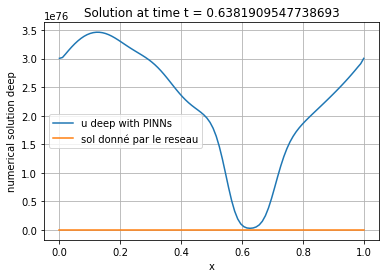

deep [1.19103489e+77 1.19655659e+77 1.22114218e+77 1.24711507e+77
 1.27196961e+77 1.29509365e+77 1.31612378e+77 1.33475661e+77
 1.35074115e+77 1.36389038e+77 1.37408619e+77 1.38127680e+77
 1.38546591e+77 1.38669933e+77 1.38505800e+77 1.38066202e+77
 1.37368572e+77 1.36437976e+77 1.35308844e+77 1.34024795e+77
 1.32636171e+77 1.31195044e+77 1.29748611e+77 1.28332752e+77
 1.26966936e+77 1.25651688e+77 1.24369032e+77 1.23085501e+77
 1.21757124e+77 1.20335500e+77 1.18774055e+77 1.17033990e+77
 1.15089542e+77 1.12932052e+77 1.10572438e+77 1.08041754e+77
 1.05389207e+77 1.02677600e+77 9.99768468e+76 9.73561346e+76
 9.48758515e+76 9.25805354e+76 9.04931763e+76 8.86111377e+76
 8.69037015e+76 8.53099491e+76 8.37349296e+76 8.20413628e+76
 8.00350212e+76 7.74486305e+76 7.39412148e+76 6.91388380e+76
 6.27382023e+76 5.46611256e+76 4.52009585e+76 3.50648553e+76
 2.52410811e+76 1.67109528e+76 1.01329054e+76 5.66525046e+75
 3.01817317e+75 1.67863663e+75 1.16099262e+75 1.16452678e+75
 1.61934925e+75 2.6

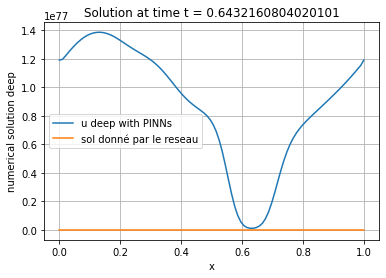

deep [4.72233134e+77 4.74137873e+77 4.84047522e+77 4.94618929e+77
 5.04818792e+77 5.14399745e+77 5.23214511e+77 5.31136179e+77
 5.38054582e+77 5.43881565e+77 5.48554510e+77 5.52037175e+77
 5.54316918e+77 5.55399950e+77 5.55307953e+77 5.54078184e+77
 5.51768050e+77 5.48463566e+77 5.44287754e+77 5.39403148e+77
 5.34005996e+77 5.28309649e+77 5.22519533e+77 5.16806091e+77
 5.11280779e+77 5.05980861e+77 5.00865947e+77 4.95825762e+77
 4.90697392e+77 4.85288530e+77 4.79402898e+77 4.72865335e+77
 4.65544681e+77 4.57372374e+77 4.48355305e+77 4.38581709e+77
 4.28217554e+77 4.17492634e+77 4.06678139e+77 3.96057234e+77
 3.85892732e+77 3.76397125e+77 3.67706902e+77 3.59863015e+77
 3.52798486e+77 3.46329563e+77 3.40144460e+77 3.33779773e+77
 3.26572416e+77 3.17591100e+77 3.05591461e+77 2.89084532e+77
 2.66627784e+77 2.37366693e+77 2.01689386e+77 1.61654084e+77
 1.20819178e+77 8.33463848e+76 5.26894253e+76 3.05196860e+76
 1.64708795e+76 8.76800174e+75 5.27290054e+75 4.34478796e+75
 5.23288566e+75 8.1

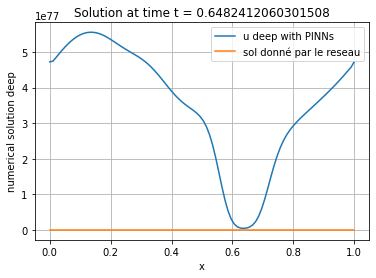

deep [1.87241044e+78 1.87857310e+78 1.91837016e+78 1.96124321e+78
 2.00292511e+78 2.04241958e+78 2.07913702e+78 2.11255677e+78
 2.14220868e+78 2.16769494e+78 2.18870862e+78 2.20504377e+78
 2.21659120e+78 2.22332355e+78 2.22528142e+78 2.22256931e+78
 2.21536772e+78 2.20396355e+78 2.18878650e+78 2.17042965e+78
 2.14964185e+78 2.12727685e+78 2.10420277e+78 2.08119346e+78
 2.05882159e+78 2.03737923e+78 2.01684262e+78 1.99688362e+78
 1.97692458e+78 1.95622401e+78 1.93397720e+78 1.90942040e+78
 1.88192891e+78 1.85110024e+78 1.81681645e+78 1.77928138e+78
 1.73902259e+78 1.69685340e+78 1.65379902e+78 1.61098967e+78
 1.56953465e+78 1.53039837e+78 1.49428782e+78 1.46156188e+78
 1.43216963e+78 1.40560851e+78 1.38088623e+78 1.35645529e+78
 1.33006642e+78 1.29851715e+78 1.25738779e+78 1.20103531e+78
 1.12328949e+78 1.01916773e+78 8.87439766e+77 7.33013601e+77
 5.67594803e+77 4.07464597e+77 2.68715125e+77 1.62047228e+77
 8.99117667e+76 4.74171552e+76 2.60692789e+76 1.78860830e+76
 1.79466145e+76 2.5

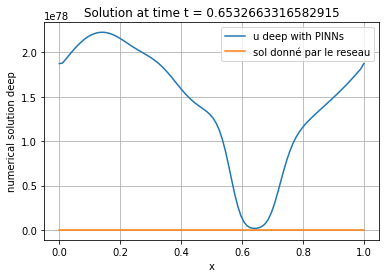

deep [7.42459785e+78 7.44246277e+78 7.60173737e+78 7.77504011e+78
 7.94472055e+78 8.10677361e+78 8.25886179e+78 8.39888328e+78
 8.52487735e+78 8.63510796e+78 8.72814832e+78 8.80294375e+78
 8.85882127e+78 8.89545148e+78 8.91279944e+78 8.91109703e+78
 8.89086937e+78 8.85303669e+78 8.79906118e+78 8.73105934e+78
 8.65182883e+78 8.56471069e+78 8.47327899e+78 8.38092311e+78
 8.29039370e+78 8.20342193e+78 8.12049428e+78 8.04081358e+78
 7.96245002e+78 7.88264076e+78 7.79817671e+78 7.70582615e+78
 7.60274952e+78 7.48686385e+78 7.35713359e+78 7.21376961e+78
 7.05829892e+78 6.89348289e+78 6.72308964e+78 6.55151986e+78
 6.38333077e+78 6.22273686e+78 6.07313019e+78 5.93667078e+78
 5.81398962e+78 5.70398137e+78 5.60365056e+78 5.50792251e+78
 5.40922012e+78 5.29662860e+78 5.15475715e+78 4.96299550e+78
 4.69672476e+78 4.33215659e+78 3.85537305e+78 3.27306125e+78
 2.61943577e+78 1.95327706e+78 1.34301936e+78 8.45072570e+77
 4.86321140e+77 2.60129449e+77 1.36925185e+77 8.14650287e+76
 6.68602876e+76 8.0

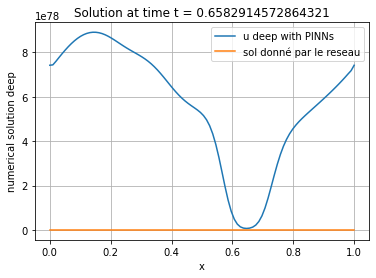

deep [2.94432663e+79 2.94837707e+79 3.01191257e+79 3.08175333e+79
 3.15058604e+79 3.21680136e+79 3.27947958e+79 3.33778347e+79
 3.39091084e+79 3.43812418e+79 3.47878589e+79 3.51238985e+79
 3.53857487e+79 3.55711892e+79 3.56792461e+79 3.57100675e+79
 3.56649566e+79 3.55466937e+79 3.53600924e+79 3.51125231e+79
 3.48142133e+79 3.44779583e+79 3.41181247e+79 3.37491153e+79
 3.33835223e+79 3.30304088e+79 3.26940952e+79 3.23736535e+79
 3.20631965e+79 3.17528516e+79 3.14301920e+79 3.10819202e+79
 3.06955901e+79 3.02611801e+79 2.97724092e+79 2.92277212e+79
 2.86307939e+79 2.79904838e+79 2.73201950e+79 2.66366289e+79
 2.59580398e+79 2.53022809e+79 2.46848117e+79 2.41169001e+79
 2.36042337e+79 2.31459031e+79 2.27336935e+79 2.23514650e+79
 2.19739585e+79 2.15642195e+79 2.10693869e+79 2.04162456e+79
 1.95113665e+79 1.82527359e+79 1.65585718e+79 1.44095847e+79
 1.18879957e+79 9.18778376e+78 6.57737729e+78 4.32052186e+78
 2.59108237e+78 1.42667575e+78 7.44726489e+77 4.04662469e+77
 2.75393623e+77 2.7

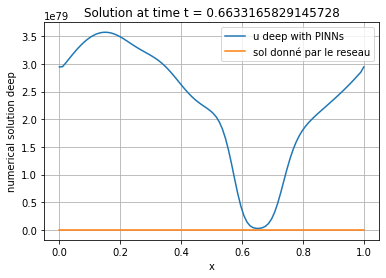

deep [1.16775924e+80 1.16799090e+80 1.19325573e+80 1.22132251e+80
 1.24915591e+80 1.27610884e+80 1.30182141e+80 1.32596373e+80
 1.34821280e+80 1.36826220e+80 1.38583570e+80 1.40070140e+80
 1.41268022e+80 1.42164737e+80 1.42752935e+80 1.43029950e+80
 1.42997745e+80 1.42663867e+80 1.42043448e+80 1.41161424e+80
 1.40054333e+80 1.38770132e+80 1.37365285e+80 1.35899388e+80
 1.34427967e+80 1.32995084e+80 1.31627411e+80 1.30330806e+80
 1.29090115e+80 1.27871959e+80 1.26629792e+80 1.25310389e+80
 1.23860865e+80 1.22235343e+80 1.20400792e+80 1.18341651e+80
 1.16062738e+80 1.13590057e+80 1.10969395e+80 1.08262390e+80
 1.05540370e+80 1.02876924e+80 1.00339844e+80 9.79834360e+79
 9.58422237e+79 9.39260770e+79 9.22167795e+79 9.06655980e+79
 8.91898014e+79 8.76651294e+79 8.59117180e+79 8.36747289e+79
 8.06126753e+79 7.63177722e+79 7.03980143e+79 6.26268176e+79
 5.31195850e+79 4.24458282e+79 3.15773692e+79 2.16390223e+79
 1.35521364e+79 7.74815286e+78 4.10745511e+78 2.13755748e+78
 1.25795973e+78 1.0

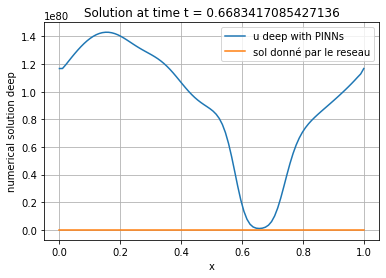

deep [4.63219937e+80 4.62698345e+80 4.72714176e+80 4.83963822e+80
 4.95185533e+80 5.06118715e+80 5.16623041e+80 5.26569638e+80
 5.35830163e+80 5.44279653e+80 5.51801437e+80 5.58292953e+80
 5.63670061e+80 5.67868962e+80 5.70846270e+80 5.72577852e+80
 5.73058257e+80 5.72303427e+80 5.70357599e+80 5.67302076e+80
 5.63264070e+80 5.58419408e+80 5.52985193e+80 5.47202133e+80
 5.41307549e+80 5.35504969e+80 5.29936924e+80 5.24666092e+80
 5.19668779e+80 5.14841067e+80 5.10015428e+80 5.04984930e+80
 4.99531146e+80 4.93451946e+80 4.86586825e+80 4.78838042e+80
 4.70185436e+80 4.60693567e+80 4.50510488e+80 4.39856472e+80
 4.29003196e+80 4.18246381e+80 4.07874083e+80 3.98134655e+80
 3.89208970e+80 3.81187749e+80 3.74054915e+80 3.67676590e+80
 3.61789773e+80 3.55980845e+80 3.49642010e+80 3.41898913e+80
 3.31538339e+80 3.17010731e+80 2.96630625e+80 2.69055919e+80
 2.33986352e+80 1.92801774e+80 1.48720022e+80 1.06164814e+80
 6.94595253e+79 4.14254232e+79 2.26346143e+79 1.16940192e+79
 6.27892154e+78 4.2

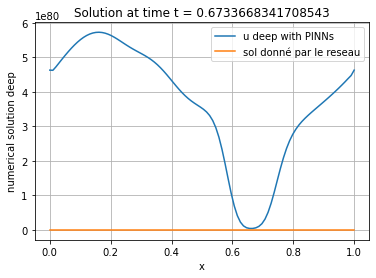

deep [1.83780460e+81 1.83303261e+81 1.87261977e+81 1.91759948e+81
 1.96271963e+81 2.00692847e+81 2.04967982e+81 2.09047347e+81
 2.12880498e+81 2.16417259e+81 2.19609381e+81 2.22412789e+81
 2.24789497e+81 2.26708815e+81 2.28147886e+81 2.29091575e+81
 2.29532270e+81 2.29470646e+81 2.28917973e+81 2.27899407e+81
 2.26457907e+81 2.24656428e+81 2.22576655e+81 2.20313617e+81
 2.17966034e+81 2.15624289e+81 2.13358589e+81 2.11209580e+81
 2.09183477e+81 2.07252320e+81 2.05358874e+81 2.03425250e+81
 2.01363705e+81 1.99087983e+81 1.96524121e+81 1.93619847e+81
 1.90351715e+81 1.86729415e+81 1.82796976e+81 1.78630059e+81
 1.74329312e+81 1.70010663e+81 1.65793187e+81 1.61786102e+81
 1.58076834e+81 1.54720763e+81 1.51733296e+81 1.49084575e+81
 1.46695141e+81 1.44429640e+81 1.42084092e+81 1.39361439e+81
 1.35839616e+81 1.30951829e+81 1.24023091e+81 1.14407496e+81
 1.01736715e+81 8.62105034e+80 6.87780803e+80 5.10454450e+80
 3.48618814e+80 2.17308911e+80 1.23433016e+80 6.48488883e+79
 3.33614792e+79 1.9

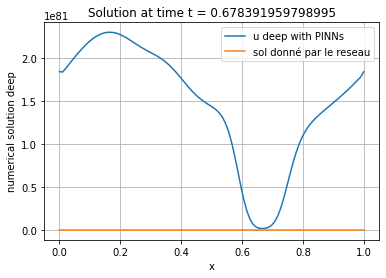

deep [7.29290245e+81 7.26219139e+81 7.41819342e+81 7.59761780e+81
 7.77857815e+81 7.95681851e+81 8.13021339e+81 8.29683013e+81
 8.45470281e+81 8.60184272e+81 8.73628997e+81 8.85619486e+81
 8.95989612e+81 9.04598124e+81 9.11332597e+81 9.16110661e+81
 9.18879877e+81 9.19620076e+81 9.18351004e+81 9.15144166e+81
 9.10139022e+81 9.03555108e+81 8.95692936e+81 8.86919527e+81
 8.77635552e+81 8.68229666e+81 8.59029170e+81 8.50256458e+81
 8.42000949e+81 8.34210894e+81 8.26704932e+81 8.19200960e+81
 8.11356521e+81 8.02814044e+81 7.93246014e+81 7.82395949e+81
 7.70111354e+81 7.56366493e+81 7.41273554e+81 7.25078982e+81
 7.08144008e+81 6.90911677e+81 6.73861859e+81 6.57459826e+81
 6.42106309e+81 6.28092304e+81 6.15562334e+81 6.04488761e+81
 5.94652757e+81 5.85624019e+81 5.76724694e+81 5.66952736e+81
 5.54861646e+81 5.38437336e+81 5.15111690e+81 4.82100276e+81
 4.37202485e+81 3.79956137e+81 3.12681431e+81 2.40713361e+81
 1.71344914e+81 1.11658174e+81 6.62252078e+80 3.59083211e+80
 1.83603352e+80 9.7

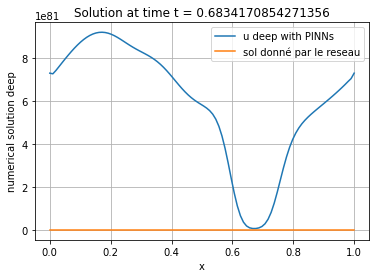

deep [2.89467990e+82 2.87741026e+82 2.93870347e+82 3.01011628e+82
 3.08252094e+82 3.15419041e+82 3.22429655e+82 3.29209454e+82
 3.35682317e+82 3.41770253e+82 3.47394838e+82 3.52479990e+82
 3.56954936e+82 3.60756867e+82 3.63833090e+82 3.66142189e+82
 3.67654404e+82 3.68352521e+82 3.68234437e+82 3.67317312e+82
 3.65643946e+82 3.63288510e+82 3.60358944e+82 3.56993926e+82
 3.53352382e+82 3.49596855e+82 3.45873761e+82 3.42294206e+82
 3.38919690e+82 3.35755135e+82 3.32749975e+82 3.29806951e+82
 3.26796584e+82 3.23574726e+82 3.20001062e+82 3.15956615e+82
 3.11358546e+82 3.06171317e+82 3.00413567e+82 2.94159412e+82
 2.87533569e+82 2.80700780e+82 2.73849708e+82 2.67173155e+82
 2.60847702e+82 2.55014293e+82 2.49761640e+82 2.45113985e+82
 2.41022143e+82 2.37355922e+82 2.33893749e+82 2.30299930e+82
 2.26083815e+82 2.20544986e+82 2.12743424e+82 2.01561974e+82
 1.85937076e+82 1.65271398e+82 1.39911963e+82 1.11439620e+82
 8.25096542e+81 5.61606826e+81 3.48438533e+81 1.96633052e+81
 1.02382043e+81 5.2

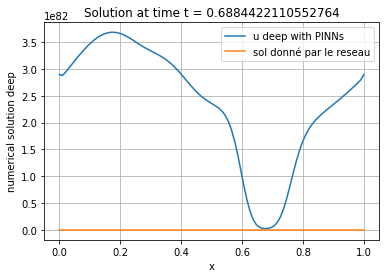

deep [1.14923587e+83 1.14020712e+83 1.16421664e+83 1.19257828e+83
 1.22148345e+83 1.25022934e+83 1.27849252e+83 1.30598618e+83
 1.33241688e+83 1.35748131e+83 1.38086957e+83 1.40227404e+83
 1.42139982e+83 1.43797541e+83 1.45176279e+83 1.46256445e+83
 1.47022697e+83 1.47464516e+83 1.47577116e+83 1.47362880e+83
 1.46833786e+83 1.46013890e+83 1.44940932e+83 1.43666145e+83
 1.42251186e+83 1.40762357e+83 1.39263005e+83 1.37805443e+83
 1.36424197e+83 1.35131814e+83 1.33917811e+83 1.32750914e+83
 1.31583958e+83 1.30360478e+83 1.29022104e+83 1.27515897e+83
 1.25800840e+83 1.23853059e+83 1.21669483e+83 1.19269422e+83
 1.16693776e+83 1.14001922e+83 1.11266184e+83 1.08564449e+83
 1.05972083e+83 1.03553796e+83 1.01356335e+83 9.94027956e+82
 9.76883463e+82 9.61769859e+82 9.47982967e+82 9.34408926e+82
 9.19395876e+82 9.00545559e+82 8.74517253e+82 8.37055157e+82
 7.83562023e+82 7.10434411e+82 6.16972420e+82 5.07072004e+82
 3.89583798e+82 2.76524897e+82 1.79487248e+82 1.05872394e+82
 5.69686802e+81 2.8

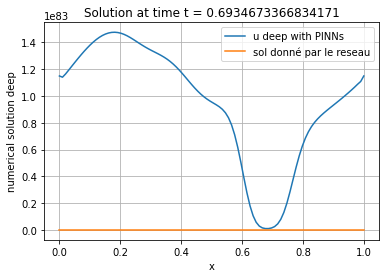

deep [4.56388873e+83 4.51881768e+83 4.61257619e+83 4.72497622e+83
 4.84012347e+83 4.95515030e+83 5.06878925e+83 5.17993516e+83
 5.28745965e+83 5.39019040e+83 5.48691535e+83 5.57640860e+83
 5.65746452e+83 5.72893717e+83 5.78978322e+83 5.83909713e+83
 5.87613400e+83 5.90033073e+83 5.91134077e+83 5.90908433e+83
 5.89383868e+83 5.86633986e+83 5.82786556e+83 5.78026348e+83
 5.72587366e+83 5.66733847e+83 5.60732165e+83 5.54818108e+83
 5.49166785e+83 5.43870702e+83 5.38929602e+83 5.34253792e+83
 5.29679369e+83 5.24991945e+83 5.19955448e+83 5.14342205e+83
 5.07960791e+83 5.00679686e+83 4.92445299e+83 4.83292292e+83
 4.73344946e+83 4.62809327e+83 4.51955278e+83 4.41089781e+83
 4.30525729e+83 4.20548686e+83 4.11385491e+83 4.03178511e+83
 3.95965466e+83 3.89664485e+83 3.84062321e+83 3.78795239e+83
 3.73310985e+83 3.66797210e+83 3.58092703e+83 3.45638582e+83
 3.27586922e+83 3.02188170e+83 2.68476966e+83 2.27053156e+83
 1.80551780e+83 1.33360779e+83 9.04694732e+82 5.58707411e+82
 3.13269050e+82 1.6

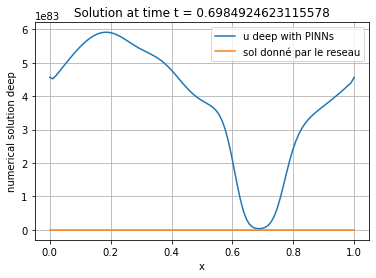

deep [1.81295216e+84 1.79116783e+84 1.82766383e+84 1.87211554e+84
 1.91789091e+84 1.96381700e+84 2.00939514e+84 2.05419853e+84
 2.09779358e+84 2.13972906e+84 2.17953473e+84 2.21672795e+84
 2.25082380e+84 2.28134848e+84 2.30785608e+84 2.32994434e+84
 2.34726675e+84 2.35954330e+84 2.36657487e+84 2.36826134e+84
 2.36463491e+84 2.35590011e+84 2.34247193e+84 2.32499896e+84
 2.30434947e+84 2.28155333e+84 2.25770254e+84 2.23382362e+84
 2.21074946e+84 2.18901413e+84 2.16878925e+84 2.14987352e+84
 2.13173336e+84 2.11358372e+84 2.09449675e+84 2.07352224e+84
 2.04980470e+84 2.02268768e+84 1.99179838e+84 1.95710410e+84
 1.91893515e+84 1.87797202e+84 1.83519113e+84 1.79177244e+84
 1.74898239e+84 1.70804151e+84 1.66999277e+84 1.63558796e+84
 1.60519454e+84 1.57872520e+84 1.55558846e+84 1.53462846e+84
 1.51401629e+84 1.49102171e+84 1.46167296e+84 1.42042912e+84
 1.36024168e+84 1.27352653e+84 1.15439532e+84 1.00179141e+84
 8.22265272e+83 6.30492199e+83 4.46260062e+83 2.88529405e+83
 1.69272859e+83 9.0

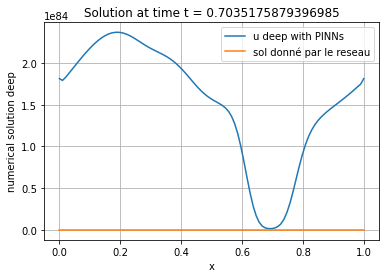

deep [7.20394977e+84 7.10116366e+84 7.24274944e+84 7.41817531e+84
 7.59978104e+84 7.78275935e+84 7.96513921e+84 8.14526686e+84
 8.32147464e+84 8.49202966e+84 8.65511813e+84 8.80885871e+84
 8.95132802e+84 9.08060183e+84 9.19481557e+84 9.29222914e+84
 9.37128337e+84 9.43065286e+84 9.46930811e+84 9.48658430e+84
 9.48230484e+84 9.45693495e+84 9.41174489e+84 9.34893932e+84
 9.27166313e+84 9.18384265e+84 9.08985057e+84 8.99402704e+84
 8.90015500e+84 8.81098538e+84 8.72789802e+84 8.65076366e+84
 8.57801666e+84 8.50690914e+84 8.43390493e+84 8.35514927e+84
 8.26695009e+84 8.16622769e+84 8.05089868e+84 7.92015804e+84
 7.77463753e+84 7.61642720e+84 7.44893224e+84 7.27656818e+84
 7.10433668e+84 6.93731220e+84 6.78010308e+84 6.63636242e+84
 6.50836829e+84 6.39669424e+84 6.29998259e+84 6.21472893e+84
 6.13496995e+84 6.05159426e+84 5.95117032e+84 5.81444676e+84
 5.61558712e+84 5.32404634e+84 4.91109014e+84 4.36110597e+84
 3.68448547e+84 2.92512313e+84 2.15548064e+84 1.45742827e+84
 8.95968103e+83 4.9

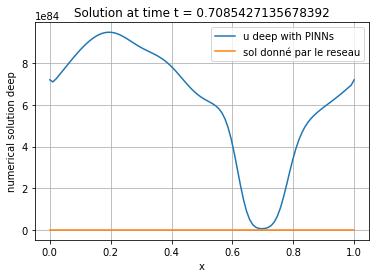

deep [2.86348660e+85 2.81589259e+85 2.87062518e+85 2.93970736e+85
 3.01161165e+85 3.08436449e+85 3.15718316e+85 3.22942408e+85
 3.30044426e+85 3.36957845e+85 3.43612975e+85 3.49937045e+85
 3.55854657e+85 3.61288865e+85 3.66163187e+85 3.70404049e+85
 3.73943210e+85 3.76720183e+85 3.78684981e+85 3.79800859e+85
 3.80048967e+85 3.79434179e+85 3.77991768e+85 3.75793640e+85
 3.72950673e+85 3.69609210e+85 3.65940466e+85 3.62123242e+85
 3.58323268e+85 3.54672738e+85 3.51253833e+85 3.48089474e+85
 3.45142424e+85 3.42322238e+85 3.39498823e+85 3.36520203e+85
 3.33231830e+85 3.29495543e+85 3.25206521e+85 3.20306653e+85
 3.14793385e+85 3.08723406e+85 3.02209910e+85 2.95413223e+85
 2.88526024e+85 2.81754004e+85 2.75294358e+85 2.69315230e+85
 2.63937244e+85 2.59218369e+85 2.55143228e+85 2.51614256e+85
 2.48442134e+85 2.45325606e+85 2.41814161e+85 2.37250016e+85
 2.30714719e+85 2.21041657e+85 2.06981405e+85 1.87571240e+85
 1.62654856e+85 1.33332559e+85 1.02035797e+85 7.20208401e+84
 4.63871966e+84 2.7

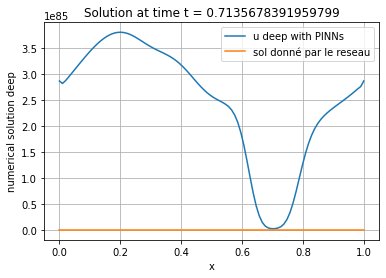

deep [1.13858755e+86 1.11688308e+86 1.13796029e+86 1.16510455e+86
 1.19351669e+86 1.22238554e+86 1.25139879e+86 1.28030470e+86
 1.30885446e+86 1.33679232e+86 1.36385104e+86 1.38975069e+86
 1.41419852e+86 1.43689094e+86 1.45751947e+86 1.47577924e+86
 1.49137861e+86 1.50404950e+86 1.51355951e+86 1.51972318e+86
 1.52241996e+86 1.52161628e+86 1.51739211e+86 1.50996867e+86
 1.49972455e+86 1.48719225e+86 1.47302748e+86 1.45794957e+86
 1.44266296e+86 1.42777270e+86 1.41370912e+86 1.40067710e+86
 1.38863703e+86 1.37731827e+86 1.36626261e+86 1.35488883e+86
 1.34256824e+86 1.32870280e+86 1.31279820e+86 1.29452492e+86
 1.27376304e+86 1.25062775e+86 1.22547022e+86 1.19885198e+86
 1.17149586e+86 1.14421550e+86 1.11783165e+86 1.09308794e+86
 1.07057150e+86 1.05064496e+86 1.03339627e+86 1.01859910e+86
 1.00567945e+86 9.93656246e+85 9.81029386e+85 9.65577915e+85
 9.44112281e+85 9.12353055e+85 8.65257781e+85 7.98105296e+85
 7.08379165e+85 5.97873837e+85 4.73894363e+85 3.48398870e+85
 2.34813866e+85 1.4

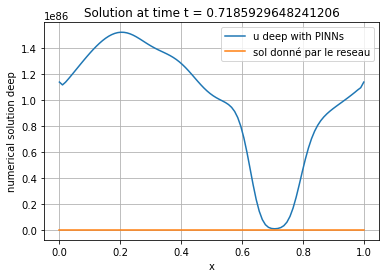

deep [4.52887922e+86 4.43114938e+86 4.51198109e+86 4.61839276e+86
 4.73042990e+86 4.84475602e+86 4.96011930e+86 5.07552967e+86
 5.19001966e+86 5.30260341e+86 5.41225591e+86 5.51790429e+86
 5.61842021e+86 5.71261930e+86 5.79927563e+86 5.87714852e+86
 5.94501720e+86 6.00172297e+86 6.04622027e+86 6.07762413e+86
 6.09528117e+86 6.09885372e+86 6.08842390e+86 6.06461053e+86
 6.02865474e+86 5.98244285e+86 5.92843006e+86 5.86944538e+86
 5.80840524e+86 5.74797637e+86 5.69024887e+86 5.63648458e+86
 5.58698071e+86 5.54106319e+86 5.49720949e+86 5.45327253e+86
 5.40676662e+86 5.35518197e+86 5.29629294e+86 5.22842857e+86
 5.15068665e+86 5.06307664e+86 4.96656906e+86 4.86304129e+86
 4.75512574e+86 4.64596201e+86 4.53888076e+86 4.43706675e+86
 4.34322565e+86 4.25928550e+86 4.18616533e+86 4.12359180e+86
 4.06996451e+86 4.02217013e+86 3.97525988e+86 3.92179932e+86
 3.85090221e+86 3.74735313e+86 3.59186709e+86 3.36385382e+86
 3.04760483e+86 2.64083573e+86 2.16200268e+86 1.65136009e+86
 1.16246125e+86 7.4

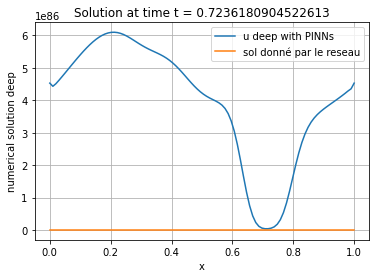

deep [1.80207942e+87 1.75854859e+87 1.78940747e+87 1.83102210e+87
 1.87510826e+87 1.92029319e+87 1.96607308e+87 2.01205627e+87
 2.05786452e+87 2.10311622e+87 2.14741754e+87 2.19035786e+87
 2.23150461e+87 2.27039995e+87 2.30656293e+87 2.33949663e+87
 2.36869961e+87 2.39368179e+87 2.41398529e+87 2.42920427e+87
 2.43901335e+87 2.44320023e+87 2.44170614e+87 2.43467370e+87
 2.42248715e+87 2.40579391e+87 2.38549154e+87 2.36266825e+87
 2.33850263e+87 2.31413416e+87 2.29052680e+87 2.26835259e+87
 2.24791466e+87 2.22911978e+87 2.21150490e+87 2.19430955e+87
 2.17658017e+87 2.15729335e+87 2.13548298e+87 2.11035717e+87
 2.08139647e+87 2.04842633e+87 2.01165450e+87 1.97166854e+87
 1.92939383e+87 1.88601044e+87 1.84283733e+87 1.80120114e+87
 1.76229960e+87 1.72707345e+87 1.69610207e+87 1.66951856e+87
 1.64694968e+87 1.62745081e+87 1.60941354e+87 1.59036797e+87
 1.56664454e+87 1.53296160e+87 1.48223955e+87 1.40615165e+87
 1.29695298e+87 1.15059001e+87 9.70149218e+86 7.67776451e+86
 5.63193333e+86 3.7

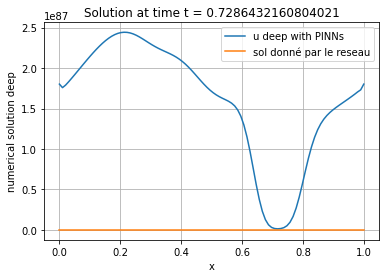

deep [7.17334112e+87 6.98126622e+87 7.09848444e+87 7.26080768e+87
 7.43390299e+87 7.61212372e+87 7.79343476e+87 7.97627794e+87
 8.15916569e+87 8.34061306e+87 8.51910192e+87 8.69305989e+87
 8.86083379e+87 9.02066646e+87 9.17069140e+87 9.30894644e+87
 9.43340640e+87 9.54203845e+87 9.63288324e+87 9.70413565e+87
 9.75425964e+87 9.78211603e+87 9.78712018e+87 9.76943412e+87
 9.73014325e+87 9.67138252e+87 9.59634737e+87 9.50913015e+87
 9.41438649e+87 9.31685575e+87 9.22081249e+87 9.12955541e+87
 9.04501940e+87 8.96756902e+87 8.89600829e+87 8.82778971e+87
 8.75937727e+87 8.68671515e+87 8.60573930e+87 8.51287171e+87
 8.40545726e+87 8.28210977e+87 8.14292860e+87 7.98956372e+87
 7.82512449e+87 7.65391789e+87 7.48103955e+87 7.31187731e+87
 7.15156490e+87 7.00444445e+87 6.87360730e+87 6.76050577e+87
 6.66467428e+87 6.58347138e+87 6.51180118e+87 6.44153424e+87
 6.36041333e+87 6.25043052e+87 6.08641031e+87 5.83646337e+87
 5.46670415e+87 4.95151004e+87 4.28758195e+87 3.50583428e+87
 2.67286340e+87 1.8

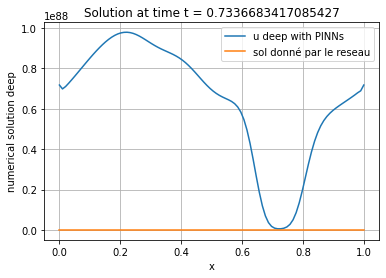

deep [2.85652843e+88 2.77248173e+88 2.81675722e+88 2.87989788e+88
 2.94770250e+88 3.01784988e+88 3.08951554e+88 3.16207622e+88
 3.23494320e+88 3.30753526e+88 3.37926443e+88 3.44952724e+88
 3.51769255e+88 3.58308928e+88 3.64499950e+88 3.70265797e+88
 3.75525917e+88 3.80197467e+88 3.84198300e+88 3.87450129e+88
 3.89883145e+88 3.91441065e+88 3.92087309e+88 3.91812640e+88
 3.90642606e+88 3.88643814e+88 3.85926542e+88 3.82641066e+88
 3.78967238e+88 3.75097416e+88 3.71215179e+88 3.67473812e+88
 3.63978151e+88 3.60772681e+88 3.57837981e+88 3.55095507e+88
 3.52419387e+88 3.49653620e+88 3.46632139e+88 3.43199219e+88
 3.39228404e+88 3.34638393e+88 3.29404198e+88 3.23562641e+88
 3.17211772e+88 3.10503405e+88 3.03629310e+88 2.96803018e+88
 2.90238531e+88 2.84128295e+88 2.78623448e+88 2.73816432e+88
 2.69728001e+88 2.66296012e+88 2.63366014e+88 2.60674349e+88
 2.57814801e+88 2.54181346e+88 2.48900479e+88 2.40800593e+88
 2.28508461e+88 2.10753937e+88 1.86884131e+88 1.57427953e+88
 1.24403087e+88 9.1

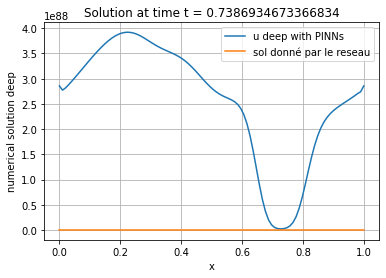

deep [1.13796765e+89 1.10146563e+89 1.11808276e+89 1.14256943e+89
 1.16906408e+89 1.19661354e+89 1.22488307e+89 1.25362212e+89
 1.28259628e+89 1.31157659e+89 1.34033403e+89 1.36863607e+89
 1.39624154e+89 1.42289486e+89 1.44832176e+89 1.47222694e+89
 1.49429436e+89 1.51419179e+89 1.53158115e+89 1.54613025e+89
 1.55753104e+89 1.56551962e+89 1.56990054e+89 1.57057702e+89
 1.56758158e+89 1.56110466e+89 1.55151230e+89 1.53934200e+89
 1.52527306e+89 1.51006846e+89 1.49449517e+89 1.47923692e+89
 1.46481366e+89 1.45152097e+89 1.43940030e+89 1.42824277e+89
 1.41762367e+89 1.40696266e+89 1.39560022e+89 1.38287988e+89
 1.36822838e+89 1.35122618e+89 1.33166147e+89 1.30956300e+89
 1.28520988e+89 1.25911404e+89 1.23197637e+89 1.20462248e+89
 1.17792206e+89 1.15270071e+89 1.12965702e+89 1.10928630e+89
 1.09182093e+89 1.07717953e+89 1.06493032e+89 1.05423946e+89
 1.04377334e+89 1.03151201e+89 1.01448051e+89 9.88511516e+88
 9.48338610e+88 8.88386950e+88 8.04477538e+88 6.96140550e+88
 5.68547732e+88 4.3

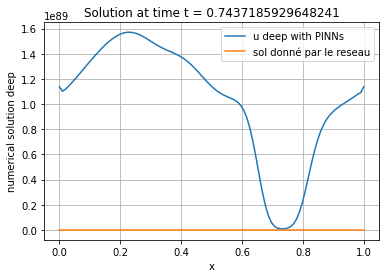

deep [4.53523707e+89 4.37778376e+89 4.43969352e+89 4.53434351e+89
 4.63759595e+89 4.74554284e+89 4.85682299e+89 4.97042499e+89
 5.08541006e+89 5.20087023e+89 5.31590779e+89 5.42962205e+89
 5.54108868e+89 5.64933492e+89 5.75331796e+89 5.85190804e+89
 5.94387999e+89 6.02792100e+89 6.10266286e+89 6.16672328e+89
 6.21877579e+89 6.25762829e+89 6.28231906e+89 6.29223629e+89
 6.28724181e+89 6.26779561e+89 6.23504957e+89 6.19086823e+89
 6.13775722e+89 6.07867594e+89 6.01675013e+89 5.95493048e+89
 5.89565074e+89 5.84054172e+89 5.79025357e+89 5.74440810e+89
 5.70167988e+89 5.65999446e+89 5.61680942e+89 5.56943726e+89
 5.51537671e+89 5.45261850e+89 5.37989417e+89 5.29684899e+89
 5.20412714e+89 5.10335150e+89 4.99699660e+89 4.88817205e+89
 4.78032656e+89 4.67690438e+89 4.58100478e+89 4.49505519e+89
 4.42054290e+89 4.35778257e+89 4.30575701e+89 4.26194226e+89
 4.22202388e+89 4.17932411e+89 4.12384848e+89 4.04114282e+89
 3.91184315e+89 3.71330972e+89 3.42471632e+89 3.03554601e+89
 2.55483473e+89 2.0

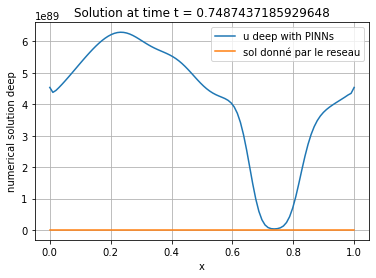

deep [1.80822620e+90 1.74073347e+90 1.76360226e+90 1.80005547e+90
 1.84017796e+90 1.88237042e+90 1.92607904e+90 1.97089412e+90
 2.01643772e+90 2.06234743e+90 2.10826894e+90 2.15385116e+90
 2.19873824e+90 2.24255935e+90 2.28491897e+90 2.32538775e+90
 2.36349562e+90 2.39873061e+90 2.43054760e+90 2.45838148e+90
 2.48167303e+90 2.49989921e+90 2.51261088e+90 2.51948010e+90
 2.52034972e+90 2.51528575e+90 2.50462203e+90 2.48898118e+90
 2.46926369e+90 2.44659186e+90 2.42221031e+90 2.39735708e+90
 2.37312378e+90 2.35032790e+90 2.32942062e+90 2.31044282e+90
 2.29303324e+90 2.27648764e+90 2.25985776e+90 2.24207437e+90
 2.22208103e+90 2.19896341e+90 2.17206038e+90 2.14104828e+90
 2.10599270e+90 2.06735986e+90 2.02598588e+90 1.98300824e+90
 1.93976104e+90 1.89764486e+90 1.85799041e+90 1.82192143e+90
 1.79023674e+90 1.76330493e+90 1.74099140e+90 1.72259102e+90
 1.70674246e+90 1.69125919e+90 1.67281746e+90 1.64649915e+90
 1.60541531e+90 1.54087137e+90 1.44369802e+90 1.30707916e+90
 1.13035900e+90 9.2

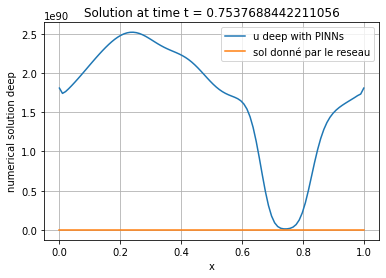

deep [7.21259725e+90 6.92497953e+90 7.00860146e+90 7.14843181e+90
 7.30385037e+90 7.46832717e+90 7.63960918e+90 7.81603294e+90
 7.99606975e+90 8.17826452e+90 8.36120887e+90 8.54352467e+90
 8.72383367e+90 8.90071745e+90 9.07267608e+90 9.23808507e+90
 9.39515616e+90 9.54191619e+90 9.67622397e+90 9.79580666e+90
 9.89835100e+90 9.98161653e+90 1.00435827e+91 1.00826351e+91
 1.00977633e+91 1.00887770e+91 1.00565055e+91 1.00029236e+91
 9.93117167e+90 9.84540657e+90 9.75047405e+90 9.65143923e+90
 9.55303480e+90 9.45911500e+90 9.37221543e+90 9.29328285e+90
 9.22160745e+90 9.15496981e+90 9.08996876e+90 9.02247478e+90
 8.94815598e+90 8.86301255e+90 8.76385905e+90 8.64871621e+90
 8.51708379e+90 8.37006181e+90 8.21030833e+90 8.04184275e+90
 7.86969218e+90 7.69941333e+90 7.53656122e+90 7.38612716e+90
 7.25203154e+90 7.13665490e+90 7.04050018e+90 6.96190549e+90
 6.89675876e+90 6.83800470e+90 6.77468477e+90 6.69030172e+90
 6.56097134e+90 6.35469936e+90 6.03417300e+90 5.56524631e+90
 4.93098415e+90 4.1

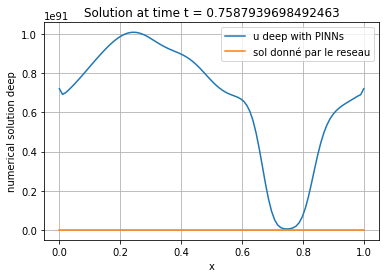

deep [2.87819097e+91 2.75630060e+91 2.78650526e+91 2.83990130e+91
 2.89989495e+91 2.96382709e+91 3.03078205e+91 3.10008339e+91
 3.17111055e+91 3.24327607e+91 3.31601637e+91 3.38878643e+91
 3.46104870e+91 3.53225773e+91 3.60184357e+91 3.66919292e+91
 3.73362987e+91 3.79440164e+91 3.85067805e+91 3.90155869e+91
 3.94610303e+91 3.98337122e+91 4.01248018e+91 4.03267671e+91
 4.04341583e+91 4.04444883e+91 4.03590912e+91 4.01837589e+91
 3.99290453e+91 3.96099557e+91 3.92449353e+91 3.88542267e+91
 3.84577656e+91 3.80729343e+91 3.77125775e+91 3.73835804e+91
 3.70862001e+91 3.68142683e+91 3.65561834e+91 3.62965099e+91
 3.60179888e+91 3.57036934e+91 3.53390722e+91 3.49137054e+91
 3.44226395e+91 3.38671588e+91 3.32549354e+91 3.25995639e+91
 3.19194395e+91 3.12360660e+91 3.05720452e+91 2.99488267e+91
 2.93845772e+91 2.88921323e+91 2.84774498e+91 2.81383167e+91
 2.78632680e+91 2.76300974e+91 2.74030277e+91 2.71273078e+91
 2.67217558e+91 2.60725230e+91 2.50361228e+91 2.34617629e+91
 2.12383029e+91 1.8

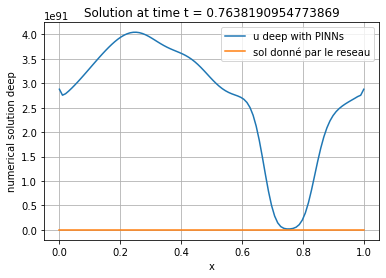

deep [1.14904908e+92 1.09766555e+92 1.10841160e+92 1.12869813e+92
 1.15176712e+92 1.17653899e+92 1.20264228e+92 1.22980175e+92
 1.25776486e+92 1.28629330e+92 1.31516013e+92 1.34414819e+92
 1.37304620e+92 1.40164300e+92 1.42972110e+92 1.45704893e+92
 1.48337212e+92 1.50840586e+92 1.53183201e+92 1.55329878e+92
 1.57242987e+92 1.58883827e+92 1.60214720e+92 1.61201837e+92
 1.61818285e+92 1.62047660e+92 1.61887648e+92 1.61352982e+92
 1.60477418e+92 1.59313545e+92 1.57929942e+92 1.56405700e+92
 1.54822674e+92 1.53256554e+92 1.51768328e+92 1.50397420e+92
 1.49157505e+92 1.48035730e+92 1.46995249e+92 1.45980551e+92
 1.44924887e+92 1.43758742e+92 1.42418290e+92 1.40853041e+92
 1.39032047e+92 1.36948064e+92 1.34619388e+92 1.32089290e+92
 1.29422785e+92 1.26700923e+92 1.24013417e+92 1.21449875e+92
 1.19091045e+92 1.17000059e+92 1.15215477e+92 1.13745388e+92
 1.12562837e+92 1.11600906e+92 1.10744501e+92 1.09813541e+92
 1.08536169e+92 1.06517816e+92 1.03230087e+92 9.80581426e+91
 9.04423505e+91 8.0

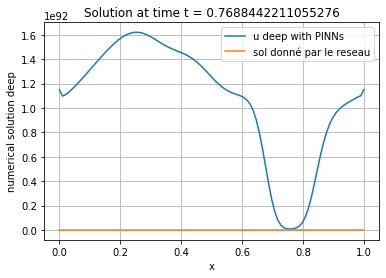

deep [4.58933383e+92 4.37383158e+92 4.41133400e+92 4.48796312e+92
 4.57628607e+92 4.67193518e+92 4.77340726e+92 4.87958303e+92
 4.98943291e+92 5.10198679e+92 5.21632560e+92 5.33157795e+92
 5.44690659e+92 5.56148764e+92 5.67448623e+92 5.78502571e+92
 5.89215067e+92 5.99479048e+92 6.09173817e+92 6.18163691e+92
 6.26300320e+92 6.33427048e+92 6.39386407e+92 6.44030861e+92
 6.47234862e+92 6.48909050e+92 6.49015104e+92 6.47578811e+92
 6.44700458e+92 6.40557808e+92 6.35399407e+92 6.29527378e+92
 6.23269946e+92 6.16947142e+92 6.10835440e+92 6.05136625e+92
 5.99955545e+92 5.95290644e+92 5.91038005e+92 5.87007566e+92
 5.82949451e+92 5.78586365e+92 5.73647684e+92 5.67901915e+92
 5.61184544e+92 5.53418623e+92 5.44626802e+92 5.34934203e+92
 5.24560736e+92 5.13802992e+92 5.03008300e+92 4.92541449e+92
 4.82749677e+92 4.73925944e+92 4.66278348e+92 4.59903390e+92
 4.54765465e+92 4.50678453e+92 4.47281209e+92 4.43987343e+92
 4.39896649e+92 4.33669335e+92 4.23424826e+92 4.06795681e+92
 3.81303198e+92 3.4

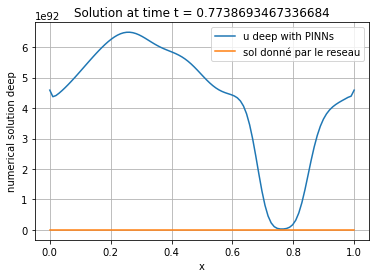

deep [1.83380254e+93 1.74387488e+93 1.75663464e+93 1.78538836e+93
 1.81903971e+93 1.85582854e+93 1.89514860e+93 1.93654539e+93
 1.97959895e+93 2.02391328e+93 2.06911443e+93 2.11485042e+93
 2.16078682e+93 2.20659941e+93 2.25196528e+93 2.29655096e+93
 2.33999742e+93 2.38190391e+93 2.42181636e+93 2.45921742e+93
 2.49353029e+93 2.52413078e+93 2.55037283e+93 2.57162844e+93
 2.58733393e+93 2.59704632e+93 2.60050367e+93 2.59768100e+93
 2.58883988e+93 2.57455320e+93 2.55569587e+93 2.53339525e+93
 2.50893787e+93 2.48364212e+93 2.45871692e+93 2.43512680e+93
 2.41348398e+93 2.39398629e+93 2.37640799e+93 2.36014195e+93
 2.34428791e+93 2.32777225e+93 2.30948204e+93 2.28839938e+93
 2.26372269e+93 2.23496318e+93 2.20201050e+93 2.16516417e+93
 2.12512397e+93 2.08293798e+93 2.03991570e+93 1.99750584e+93
 1.95715982e+93 1.92018114e+93 1.88759390e+93 1.86002345e+93
 1.83760287e+93 1.81989611e+93 1.80581839e+93 1.79348827e+93
 1.77995291e+93 1.76073299e+93 1.72931366e+93 1.67697038e+93
 1.59357717e+93 1.4

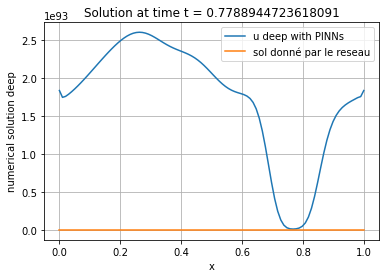

deep [7.33070022e+93 6.95731613e+93 6.99922996e+93 7.10629471e+93
 7.23379982e+93 7.37468387e+93 7.52651200e+93 7.68744314e+93
 7.85576507e+93 8.02985880e+93 8.20819725e+93 8.38935029e+93
 8.57197195e+93 8.75477516e+93 8.93649983e+93 9.11586889e+93
 9.29152905e+93 9.46198299e+93 9.62553361e+93 9.78022808e+93
 9.92385207e+93 1.00539548e+94 1.01679302e+94 1.02631602e+94
 1.03371891e+94 1.03879442e+94 1.04139790e+94 1.04147062e+94
 1.03906220e+94 1.03434479e+94 1.02761565e+94 1.01928493e+94
 1.00984563e+94 9.99828024e+93 9.89745033e+93 9.80036061e+93
 9.71017740e+93 9.62850271e+93 9.55523627e+93 9.48864673e+93
 9.42564443e+93 9.36220636e+93 9.29388800e+93 9.21636606e+93
 9.12595277e+93 9.02003042e+93 8.89737864e+93 8.75837546e+93
 8.60504259e+93 8.44092316e+93 8.27081014e+93 8.10031446e+93
 7.93534818e+93 7.78152106e+93 7.64358720e+93 7.52492336e+93
 7.42710412e+93 7.34956090e+93 7.28928870e+93 7.24039848e+93
 7.19330419e+93 7.13320588e+93 7.03800504e+93 6.87664520e+93
 6.61008812e+93 6.1

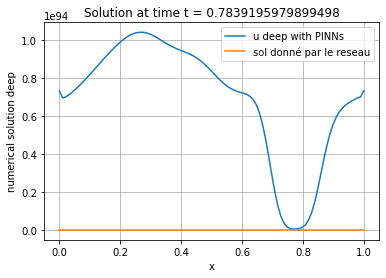

deep [2.93173257e+94 2.77748746e+94 2.79055542e+94 2.83006195e+94
 2.87806829e+94 2.93175613e+94 2.99015268e+94 3.05251469e+94
 3.11814512e+94 3.18638174e+94 3.25659929e+94 3.32821394e+94
 3.40068022e+94 3.47348272e+94 3.54612513e+94 3.61811415e+94
 3.68893693e+94 3.75803361e+94 3.82477261e+94 3.88842302e+94
 3.94814451e+94 4.00298796e+94 4.05191846e+94 4.09386465e+94
 4.12778271e+94 4.15274135e+94 4.16801850e+94 4.17319719e+94
 4.16826274e+94 4.15367380e+94 4.13039476e+94 4.09987549e+94
 4.06396149e+94 4.02473723e+94 3.98432226e+94 3.94464530e+94
 3.90722994e+94 3.87302939e+94 3.84233254e+94 3.81475206e+94
 3.78929742e+94 3.76451771e+94 3.73869065e+94 3.71003610e+94
 3.67692879e+94 3.63808800e+94 3.59273154e+94 3.54068438e+94
 3.48242923e+94 3.41909220e+94 3.35236713e+94 3.28437016e+94
 3.21745043e+94 3.15395428e+94 3.09599781e+94 3.04524326e+94
 3.00270928e+94 2.96861627e+94 2.94226520e+94 2.92189127e+94
 2.90442859e+94 2.88503546e+94 2.85633612e+94 2.80757608e+94
 2.72435924e+94 2.5

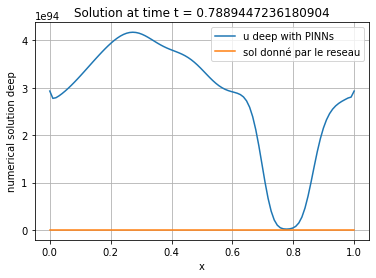

deep [1.17295851e+95 1.10957265e+95 1.11331006e+95 1.12773172e+95
 1.14567423e+95 1.16601960e+95 1.18838166e+95 1.21246171e+95
 1.23797668e+95 1.26465584e+95 1.29224281e+95 1.32049836e+95
 1.34920010e+95 1.37813997e+95 1.40712059e+95 1.43594955e+95
 1.46443100e+95 1.49235490e+95 1.51948664e+95 1.54555443e+95
 1.57024264e+95 1.59318831e+95 1.61398645e+95 1.63220602e+95
 1.64741257e+95 1.65920038e+95 1.66723040e+95 1.67126903e+95
 1.67122926e+95 1.66720363e+95 1.65948476e+95 1.64856774e+95
 1.63512623e+95 1.61996124e+95 1.60392765e+95 1.58784641e+95
 1.57241491e+95 1.55813095e+95 1.54524102e+95 1.53371933e+95
 1.52328159e+95 1.51342925e+95 1.50351648e+95 1.49283177e+95
 1.48068371e+95 1.46648156e+95 1.44980481e+95 1.43045692e+95
 1.40849788e+95 1.38425223e+95 1.35829250e+95 1.33139338e+95
 1.30446524e+95 1.27846435e+95 1.25430169e+95 1.23274912e+95
 1.21435627e+95 1.19938057e+95 1.18773371e+95 1.17892792e+95
 1.17200674e+95 1.16540306e+95 1.15668546e+95 1.14220971e+95
 1.11685066e+95 1.0

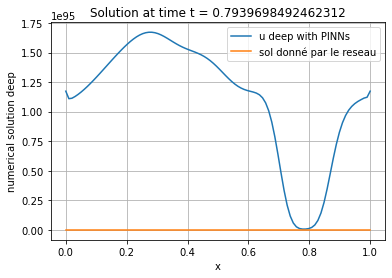

deep [4.69472821e+95 4.43567776e+95 4.44466655e+95 4.49663104e+95
 4.56311869e+95 4.63972659e+95 4.72493414e+95 4.81754759e+95
 4.91642141e+95 5.02045064e+95 5.12858359e+95 5.23983751e+95
 5.35330128e+95 5.46812889e+95 5.58352797e+95 5.69874019e+95
 5.81301051e+95 5.92554612e+95 6.03547477e+95 6.14179043e+95
 6.24331759e+95 6.33868433e+95 6.42632731e+95 6.50453939e+95
 6.57154584e+95 6.62562306e+95 6.66524472e+95 6.68923655e+95
 6.69694715e+95 6.68839384e+95 6.66436984e+95 6.62649178e+95
 6.57714980e+95 6.51935067e+95 6.45646380e+95 6.39189094e+95
 6.32870435e+95 6.26931414e+95 6.21521165e+95 6.16682389e+95
 6.12350412e+95 6.08365149e+95 6.04493542e+95 6.00459700e+95
 5.95978609e+95 5.90789472e+95 5.84686107e+95 5.77542131e+95
 5.69328588e+95 5.60122452e+95 5.50105603e+95 5.39551852e+95
 5.28804731e+95 5.18244414e+95 5.08252065e+95 4.99171329e+95
 4.91272649e+95 4.84722132e+95 4.79557200e+95 4.75664733e+95
 4.72759139e+95 4.70340784e+95 4.67616473e+95 4.63371893e+95
 4.55833095e+95 4.4

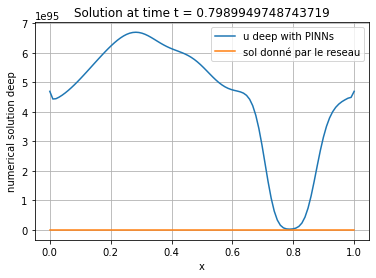

deep [1.87972250e+96 1.77447401e+96 1.77570504e+96 1.79413084e+96
 1.81851926e+96 1.84715173e+96 1.87943557e+96 1.91489714e+96
 1.95307496e+96 1.99351921e+96 2.03579879e+96 2.07950943e+96
 2.12427648e+96 2.16975377e+96 2.21562048e+96 2.26157453e+96
 2.30732169e+96 2.35256017e+96 2.39696450e+96 2.44016297e+96
 2.48172079e+96 2.52112473e+96 2.55777892e+96 2.59101709e+96
 2.62012655e+96 2.64439055e+96 2.66314359e+96 2.67583212e+96
 2.68208431e+96 2.68177255e+96 2.67506459e+96 2.66245558e+96
 2.64476520e+96 2.62309413e+96 2.59874043e+96 2.57307955e+96
 2.54742306e+96 2.52287887e+96 2.50023245e+96 2.47986586e+96
 2.46172819e+96 2.44535876e+96 2.42995631e+96 2.41448587e+96
 2.39780733e+96 2.37880988e+96 2.35654123e+96 2.33032097e+96
 2.29982783e+96 2.26515395e+96 2.22682285e+96 2.18575998e+96
 2.14322379e+96 2.10068826e+96 2.05970749e+96 2.02176123e+96
 1.98810503e+96 1.95963404e+96 1.93677278e+96 1.91937978e+96
 1.90666932e+96 1.89708782e+96 1.88807605e+96 1.87564008e+96
 1.85377533e+96 1.8

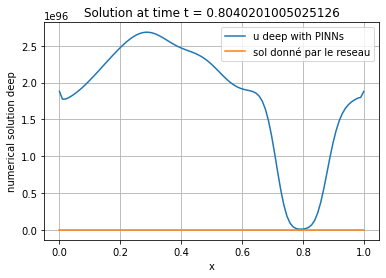

deep [7.52858472e+96 7.10372701e+96 7.09937563e+96 7.16339872e+96
 7.25177139e+96 7.35785993e+96 7.47938514e+96 7.61448477e+96
 7.76131056e+96 7.91803780e+96 8.08290246e+96 8.25424119e+96
 8.43050952e+96 8.61028411e+96 8.79225581e+96 8.97520915e+96
 9.15798413e+96 9.33942001e+96 9.51829425e+96 9.69323235e+96
 9.86263364e+96 1.00245949e+97 1.01768715e+97 1.03168985e+97
 1.04418586e+97 1.05488272e+97 1.06349767e+97 1.06978096e+97
 1.07354395e+97 1.07468524e+97 1.07321377e+97 1.06926605e+97
 1.06311117e+97 1.05514083e+97 1.04584354e+97 1.03576264e+97
 1.02544299e+97 1.01537425e+97 1.00593871e+97 9.97370859e+96
 9.89735731e+96 9.82927861e+96 9.76689826e+96 9.70648049e+96
 9.64360201e+96 9.57367968e+96 9.49250551e+96 9.39674085e+96
 9.28432512e+96 9.15476806e+96 9.00930747e+96 8.85088220e+96
 8.68394353e+96 8.51405627e+96 8.34740151e+96 8.19017247e+96
 8.04795851e+96 7.92516159e+96 7.82450389e+96 7.74660071e+96
 7.68964494e+96 7.64901390e+96 7.61657617e+96 7.57933874e+96
 7.51732825e+96 7.4

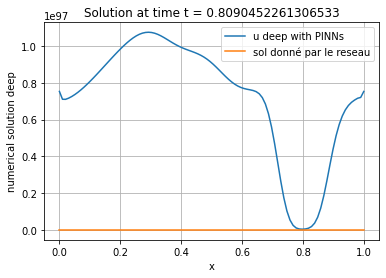

deep [3.01608601e+97 2.84581931e+97 2.84049313e+97 2.86215820e+97
 2.89370483e+97 2.93260913e+97 2.97801033e+97 3.02918491e+97
 3.08539797e+97 3.14591278e+97 3.21000947e+97 3.27700424e+97
 3.34625962e+97 3.41718821e+97 3.48925236e+97 3.56195840e+97
 3.63484370e+97 3.70745642e+97 3.77933314e+97 3.84996363e+97
 3.91875985e+97 3.98502103e+97 4.04791035e+97 4.10645304e+97
 4.15955166e+97 4.20603330e+97 4.24472239e+97 4.27452875e+97
 4.29455847e+97 4.30422129e+97 4.30333084e+97 4.29218847e+97
 4.27162476e+97 4.24298766e+97 4.20807008e+97 4.16896978e+97
 4.12789464e+97 4.08694071e+97 4.04787168e+97 4.01193143e+97
 3.97972067e+97 3.95115183e+97 3.92548361e+97 3.90143162e+97
 3.87733589e+97 3.85136176e+97 3.82171575e+97 3.78685510e+97
 3.74567165e+97 3.69763617e+97 3.64289398e+97 3.58229025e+97
 3.51733087e+97 3.45005537e+97 3.38286145e+97 3.31827503e+97
 3.25870296e+97 3.20618813e+97 3.16219366e+97 3.12741139e+97
 3.10162398e+97 3.08356523e+97 3.07071588e+97 3.05889712e+97
 3.04155530e+97 3.0

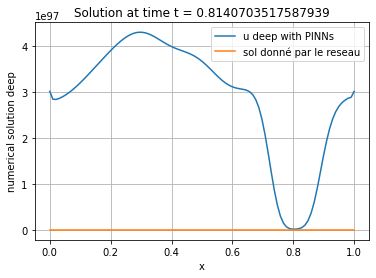

deep [1.20851325e+98 1.14084115e+98 1.13735213e+98 1.14442429e+98
 1.15547656e+98 1.16956709e+98 1.18637903e+98 1.20563567e+98
 1.22704753e+98 1.25031889e+98 1.27515705e+98 1.30128146e+98
 1.32842899e+98 1.35635664e+98 1.38484249e+98 1.41368439e+98
 1.44269577e+98 1.47169853e+98 1.50051495e+98 1.52895432e+98
 1.55680045e+98 1.58379659e+98 1.60963358e+98 1.63394532e+98
 1.65631017e+98 1.67626515e+98 1.69333088e+98 1.70704385e+98
 1.71699956e+98 1.72289565e+98 1.72457440e+98 1.72206097e+98
 1.71558740e+98 1.70559810e+98 1.69273290e+98 1.67778293e+98
 1.66162210e+98 1.64512309e+98 1.62906761e+98 1.61406363e+98
 1.60048333e+98 1.58842912e+98 1.57773115e+98 1.56797688e+98
 1.55856699e+98 1.54878928e+98 1.53790336e+98 1.52522729e+98
 1.51021765e+98 1.49253700e+98 1.47210423e+98 1.44911866e+98
 1.42405919e+98 1.39764756e+98 1.37078954e+98 1.34449015e+98
 1.31975683e+98 1.29749882e+98 1.27843459e+98 1.26300690e+98
 1.25132046e+98 1.24308633e+98 1.23755796e+98 1.23341221e+98
 1.22852336e+98 1.2

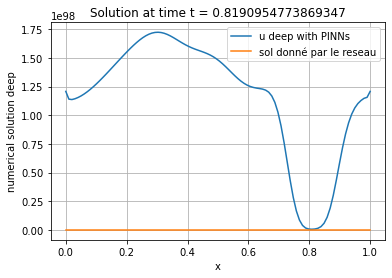

deep [4.84276189e+98 4.57641936e+98 4.55746185e+98 4.57937653e+98
 4.61717458e+98 4.66743532e+98 4.72903620e+98 4.80094222e+98
 4.88202652e+98 4.97111083e+98 5.06701085e+98 5.16857865e+98
 5.27472934e+98 5.38445655e+98 5.49684092e+98 5.61104915e+98
 5.72632121e+98 5.84194600e+98 5.95723314e+98 6.07146264e+98
 6.18383670e+98 6.29341678e+98 6.39906912e+98 6.49943326e+98
 6.59291019e+98 6.67769913e+98 6.75187906e+98 6.81352291e+98
 6.86086156e+98 6.89245468e+98 6.90736596e+98 6.90533137e+98
 6.88687986e+98 6.85339126e+98 6.80707435e+98 6.75083887e+98
 6.68806507e+98 6.62229622e+98 6.55688578e+98 6.49464733e+98
 6.43756401e+98 6.38659441e+98 6.34159661e+98 6.30138365e+98
 6.26389494e+98 6.22645620e+98 6.18610220e+98 6.13992561e+98
 6.08541626e+98 6.02076416e+98 5.94510483e+98 5.85866869e+98
 5.76283625e+98 5.66005064e+98 5.55363405e+98 5.44748675e+98
 5.34571836e+98 5.25224395e+98 5.17039490e+98 5.10254867e+98
 5.04984673e+98 5.01195443e+98 4.98683775e+98 4.97041261e+98
 4.95586570e+98 4.9

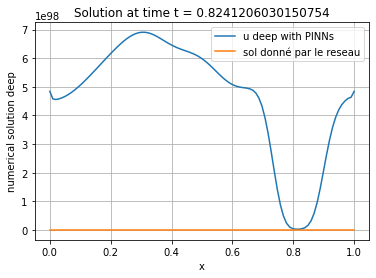

deep [1.94049817e+99 1.83690751e+99 1.82756233e+99 1.83381378e+99
 1.84632972e+99 1.86391720e+99 1.88620257e+99 1.91281094e+99
 1.94331066e+99 1.97723661e+99 2.01411242e+99 2.05347025e+99
 2.09486370e+99 2.13787606e+99 2.18212559e+99 2.22726697e+99
 2.27298793e+99 2.31900111e+99 2.36503452e+99 2.41081300e+99
 2.45603997e+99 2.50037221e+99 2.54339609e+99 2.58461077e+99
 2.62341702e+99 2.65912413e+99 2.69097454e+99 2.71818256e+99
 2.73999529e+99 2.75575879e+99 2.76498906e+99 2.76744373e+99
 2.76317848e+99 2.75258263e+99 2.73638724e+99 2.71563299e+99
 2.69159686e+99 2.66568382e+99 2.63929268e+99 2.61367331e+99
 2.58979782e+99 2.56826235e+99 2.54923136e+99 2.53243361e+99
 2.51720737e+99 2.50258656e+99 2.48741949e+99 2.47050562e+99
 2.45073562e+99 2.42722320e+99 2.39941878e+99 2.36718886e+99
 2.33086087e+99 2.29121233e+99 2.24942007e+99 2.20695828e+99
 2.16546253e+99 2.12657159e+99 2.09176743e+99 2.06221685e+99
 2.03864538e+99 2.02123001e+99 2.00951124e+99 2.00228379e+99
 1.99739863e+99 1.9

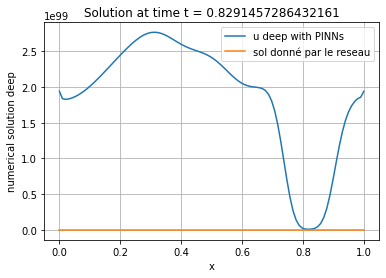

deep [7.77393439e+099 7.37696605e+099 7.33381906e+099 7.34908686e+099
 7.38868467e+099 7.44871931e+099 7.52808478e+099 7.62549000e+099
 7.73931796e+099 7.86775444e+099 8.00889744e+099 8.16084961e+099
 8.32177982e+099 8.48996465e+099 8.66381764e+099 8.84190261e+099
 9.02292734e+099 9.20571801e+099 9.38918800e+099 9.57227064e+099
 9.75385190e+099 9.93267180e+099 1.01072254e+100 1.02756831e+100
 1.04358234e+100 1.05850314e+100 1.07203640e+100 1.08386739e+100
 1.09368293e+100 1.10119646e+100 1.10617619e+100 1.10847497e+100
 1.10805536e+100 1.10500814e+100 1.09956155e+100 1.09207571e+100
 1.08302106e+100 1.07294192e+100 1.06240717e+100 1.05195396e+100
 1.04203309e+100 1.03296287e+100 1.02489746e+100 1.01781482e+100
 1.01152467e+100 1.00569461e+100 9.99891933e+099 9.93635647e+099
 9.86452853e+099 9.77934548e+099 9.67786319e+099 9.55867264e+099
 9.42216499e+099 9.27058437e+099 9.10791984e+099 8.93958217e+099
 8.77192111e+099 8.61162230e+099 8.46506487e+099 8.33765730e+099
 8.23328390e+099 8.1

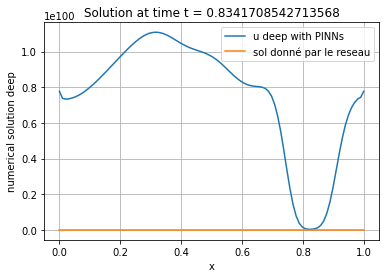

deep [3.11304899e+100 2.96382926e+100 2.94494259e+100 2.94737494e+100
 2.95906040e+100 2.97887972e+100 3.00658954e+100 3.04178300e+100
 3.08387367e+100 3.13216512e+100 3.18590498e+100 3.24432842e+100
 3.30668734e+100 3.37227060e+100 3.44041910e+100 3.51053424e+100
 3.58207843e+100 3.65456775e+100 3.72756232e+100 3.80064231e+100
 3.87338369e+100 3.94532049e+100 4.01590507e+100 4.08447275e+100
 4.15020788e+100 4.21213236e+100 4.26911884e+100 4.31992677e+100
 4.36327921e+100 4.39795511e+100 4.42289878e+100 4.43734156e+100
 4.44090965e+100 4.43371205e+100 4.41639860e+100 4.39016465e+100
 4.35669555e+100 4.31805073e+100 4.27648918e+100 4.23425497e+100
 4.19335379e+100 4.15534807e+100 4.12119733e+100 4.09116935e+100
 4.06483021e+100 4.04111136e+100 4.01844835e+100 3.99497214e+100
 3.96872988e+100 3.93791516e+100 3.90108752e+100 3.85735319e+100
 3.80650299e+100 3.74907066e+100 3.68632843e+100 3.62019469e+100
 3.55307068e+100 3.48761772e+100 3.42650560e+100 3.37213981e+100
 3.32642350e+100 3.2

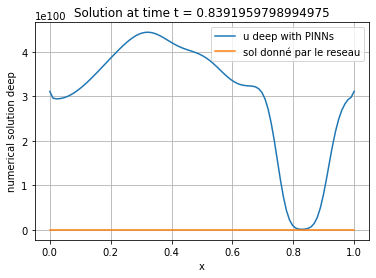

deep [1.24576056e+101 1.19111589e+101 1.18326495e+101 1.18290391e+101
 1.18595783e+101 1.19219672e+101 1.20162480e+101 1.21413636e+101
 1.22952926e+101 1.24754199e+101 1.26788046e+101 1.29023867e+101
 1.31431252e+101 1.33980955e+101 1.36645631e+101 1.39400312e+101
 1.42222554e+101 1.45092255e+101 1.47991400e+101 1.50903212e+101
 1.53811300e+101 1.56698246e+101 1.59544046e+101 1.62324632e+101
 1.65010291e+101 1.67564842e+101 1.69945666e+101 1.72104600e+101
 1.73990503e+101 1.75552548e+101 1.76744382e+101 1.77528980e+101
 1.77883158e+101 1.77801534e+101 1.77299570e+101 1.76414729e+101
 1.75205430e+101 1.73747657e+101 1.72129043e+101 1.70440973e+101
 1.68769761e+101 1.67187934e+101 1.65746756e+101 1.64471168e+101
 1.63357718e+101 1.62375624e+101 1.61470992e+101 1.60573550e+101
 1.59605044e+101 1.58488497e+101 1.57157473e+101 1.55564146e+101
 1.53685968e+101 1.51529419e+101 1.49131358e+101 1.46556899e+101
 1.43894232e+101 1.41246707e+101 1.38723245e+101 1.36427377e+101
 1.34447231e+101 1.3

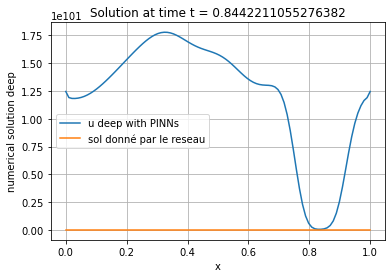

deep [4.98016028e+101 4.78742219e+101 4.75667172e+101 4.75068118e+101
 4.75672676e+101 4.77496889e+101 4.80594181e+101 4.84951735e+101
 4.90505859e+101 4.97161426e+101 5.04805285e+101 5.13316150e+101
 5.22571175e+101 5.32450576e+101 5.42841200e+101 5.53638958e+101
 5.64749941e+101 5.76090212e+101 5.87585241e+101 5.99167024e+101
 6.10771149e+101 6.22331582e+101 6.33774726e+101 6.45013435e+101
 6.55940124e+101 6.66422256e+101 6.76300684e+101 6.85391049e+101
 6.93491874e+101 7.00395851e+101 7.05905214e+101 7.09850740e+101
 7.12110164e+101 7.12625361e+101 7.11416917e+101 7.08592160e+101
 7.04345367e+101 6.98949150e+101 6.92735473e+101 6.86067647e+101
 6.79306682e+101 6.72775566e+101 6.66726048e+101 6.61313125e+101
 6.56580260e+101 6.52456946e+101 6.48769588e+101 6.45263855e+101
 6.41635532e+101 6.37566816e+101 6.32764399e+101 6.26994447e+101
 6.20113293e+101 6.12087646e+101 6.03005992e+101 5.93076404e+101
 5.82611856e+101 5.72003337e+101 5.61684485e+101 5.52088583e+101
 5.43607324e+101 5.3

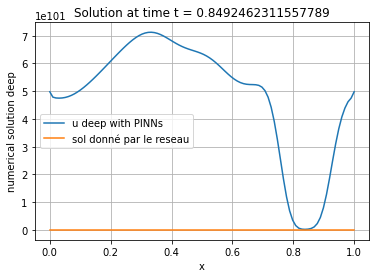

deep [1.98807486e+102 1.92395118e+102 1.91285635e+102 1.90908368e+102
 1.90923413e+102 1.91390739e+102 1.92358053e+102 1.93835402e+102
 1.95806277e+102 1.98237756e+102 2.01087236e+102 2.04307216e+102
 2.07848441e+102 2.11662111e+102 2.15701562e+102 2.19923475e+102
 2.24288537e+102 2.28761568e+102 2.33311495e+102 2.37910400e+102
 2.42532551e+102 2.47152498e+102 2.51742861e+102 2.56271983e+102
 2.60701044e+102 2.64981897e+102 2.69055781e+102 2.72853057e+102
 2.76295556e+102 2.79300250e+102 2.81784753e+102 2.83674597e+102
 2.84910580e+102 2.85456001e+102 2.85303256e+102 2.84478223e+102
 2.83041933e+102 2.81089029e+102 2.78742133e+102 2.76142332e+102
 2.73436793e+102 2.70764626e+102 2.68242748e+102 2.65953926e+102
 2.63938454e+102 2.62190494e+102 2.60659850e+102 2.59258765e+102
 2.57872776e+102 2.56374535e+102 2.54639094e+102 2.52558657e+102
 2.50056206e+102 2.47095473e+102 2.43687751e+102 2.39893547e+102
 2.35819228e+102 2.31608478e+102 2.27429742e+102 2.23459791e+102
 2.19867142e+102 2.1

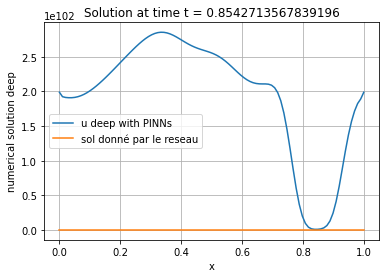

deep [7.92100178e+102 7.72857797e+102 7.69382328e+102 7.67564025e+102
 7.66836450e+102 7.67704485e+102 7.70493012e+102 7.75320192e+102
 7.82166500e+102 7.90927495e+102 8.01447697e+102 8.13543950e+102
 8.27020642e+102 8.41680192e+102 8.57331017e+102 8.73793322e+102
 8.90902661e+102 9.08511296e+102 9.26488943e+102 9.44719783e+102
 9.63099385e+102 9.81527925e+102 9.99902046e+102 1.01810591e+103
 1.03599952e+103 1.05340908e+103 1.07011981e+103 1.08587192e+103
 1.10036644e+103 1.11327633e+103 1.12426542e+103 1.13301554e+103
 1.13925526e+103 1.14278949e+103 1.14352830e+103 1.14150828e+103
 1.13690489e+103 1.13003344e+103 1.12133436e+103 1.11134261e+103
 1.10064385e+103 1.08982033e+103 1.07939299e+103 1.06976824e+103
 1.06119620e+103 1.05374570e+103 1.04730062e+103 1.04157750e+103
 1.03616158e+103 1.03055769e+103 1.02425008e+103 1.01676302e+103
 1.00771962e+103 9.96888264e+102 9.84218200e+102 9.69855920e+102
 9.54142059e+102 9.37586927e+102 9.20828059e+102 9.04569288e+102
 8.89515686e+102 8.7

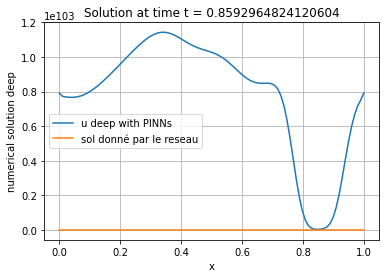

deep [3.14783528e+103 3.10207065e+103 3.09443537e+103 3.08721712e+103
 3.08183594e+103 3.08161761e+103 3.08854374e+103 3.10348734e+103
 3.12661057e+103 3.15763846e+103 3.19603038e+103 3.24109507e+103
 3.29206485e+103 3.34814591e+103 3.40855589e+103 3.47255131e+103
 3.53944562e+103 3.60861815e+103 3.67952066e+103 3.75166868e+103
 3.82463255e+103 3.89801365e+103 3.97141502e+103 4.04440797e+103
 4.11648617e+103 4.18702469e+103 4.25524526e+103 4.32018971e+103
 4.38073000e+103 4.43559767e+103 4.48344607e+103 4.52294876e+103
 4.55290877e+103 4.57237748e+103 4.58077619e+103 4.57799430e+103
 4.56445787e+103 4.54115959e+103 4.50963024e+103 4.47184765e+103
 4.43008826e+103 4.38672740e+103 4.34400976e+103 4.30382299e+103
 4.26750229e+103 4.23569173e+103 4.20828680e+103 4.18446344e+103
 4.16278774e+103 4.14139561e+103 4.11822048e+103 4.09123648e+103
 4.05870537e+103 4.01938441e+103 3.97269881e+103 3.91884400e+103
 3.85881435e+103 3.79434624e+103 3.72778405e+103 3.66186221e+103
 3.59945703e+103 3.5

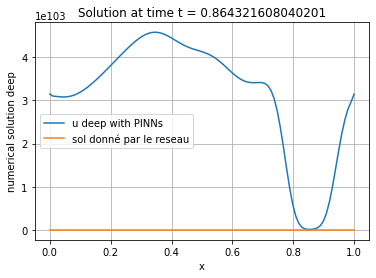

deep [1.24680060e+104 1.24348812e+104 1.24413975e+104 1.24195417e+104
 1.23918942e+104 1.23781503e+104 1.23896996e+104 1.24320894e+104
 1.25072068e+104 1.26146942e+104 1.27528226e+104 1.29190618e+104
 1.31104455e+104 1.33238147e+104 1.35559949e+104 1.38039259e+104
 1.40647498e+104 1.43358620e+104 1.46149509e+104 1.48999780e+104
 1.51891557e+104 1.54808651e+104 1.57735525e+104 1.60656074e+104
 1.63551855e+104 1.66400421e+104 1.69173761e+104 1.71836898e+104
 1.74347802e+104 1.76657987e+104 1.78714409e+104 1.80462919e+104
 1.81852314e+104 1.82838985e+104 1.83391928e+104 1.83497051e+104
 1.83160562e+104 1.82411100e+104 1.81299721e+104 1.79897525e+104
 1.78290908e+104 1.76574465e+104 1.74842196e+104 1.73178223e+104
 1.71648105e+104 1.70291933e+104 1.69120362e+104 1.68114064e+104
 1.67226565e+104 1.66390256e+104 1.65524777e+104 1.64546523e+104
 1.63378768e+104 1.61960678e+104 1.60255244e+104 1.58254742e+104
 1.55983465e+104 1.53497125e+104 1.50879061e+104 1.48232794e+104
 1.45672848e+104 1.4

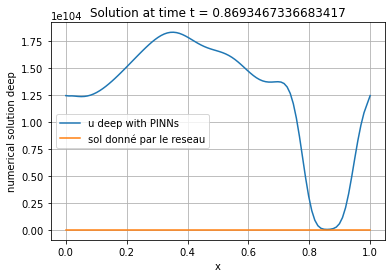

deep [4.91744595e+104 4.97521592e+104 4.99849015e+104 4.99607048e+104
 4.98459543e+104 4.97503356e+104 4.97369019e+104 4.98383856e+104
 5.00687124e+104 5.04302952e+104 5.09184944e+104 5.15244775e+104
 5.22370226e+104 5.30437060e+104 5.39317473e+104 5.48886205e+104
 5.59024760e+104 5.69624055e+104 5.80586627e+104 5.91826384e+104
 6.03268284e+104 6.14845615e+104 6.26496393e+104 6.38159003e+104
 6.49765501e+104 6.61235048e+104 6.72467278e+104 6.83335633e+104
 6.93685351e+104 7.03333603e+104 7.12074692e+104 7.19691686e+104
 7.25970938e+104 7.30719838e+104 7.33786978e+104 7.35080422e+104
 7.34583353e+104 7.32365799e+104 7.28588738e+104 7.23499483e+104
 7.17417744e+104 7.10711477e+104 7.03764362e+104 6.96938984e+104
 6.90539873e+104 6.84781314e+104 6.79765329e+104 6.75472557e+104
 6.71767006e+104 6.68414544e+104 6.65112576e+104 6.61526156e+104
 6.57328528e+104 6.52239094e+104 6.46058626e+104 6.38695988e+104
 6.30185074e+104 6.20689065e+104 6.10491938e+104 5.99974478e+104
 5.89581707e+104 5.7

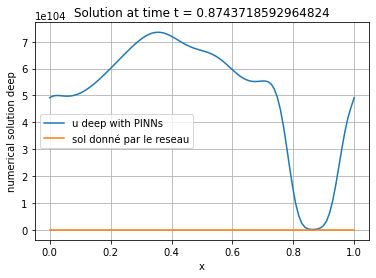

deep [1.92919282e+105 1.98540805e+105 2.00577039e+105 2.00911648e+105
 2.00543822e+105 2.00058977e+105 1.99796883e+105 1.99942423e+105
 2.00584139e+105 2.01751522e+105 2.03437881e+105 2.05614777e+105
 2.08241016e+105 2.11268490e+105 2.14646233e+105 2.18323309e+105
 2.22250823e+105 2.26383241e+105 2.30679514e+105 2.35103223e+105
 2.39622672e+105 2.44210035e+105 2.48840135e+105 2.53488920e+105
 2.58130972e+105 2.62736981e+105 2.67271038e+105 2.71687675e+105
 2.75930505e+105 2.79931469e+105 2.83611962e+105 2.86886548e+105
 2.89667975e+105 2.91873759e+105 2.93434123e+105 2.94299528e+105
 2.94447568e+105 2.93888749e+105 2.92669605e+105 2.90872688e+105
 2.88613040e+105 2.86030413e+105 2.83277689e+105 2.80506762e+105
 2.77853365e+105 2.75422810e+105 2.73278982e+105 2.71438033e+105
 2.69867525e+105 2.68491351e+105 2.67199702e+105 2.65862335e+105
 2.64344405e+105 2.62522066e+105 2.60297623e+105 2.57611923e+105
 2.54453337e+105 2.50862049e+105 2.46929379e+105 2.42790757e+105
 2.38614710e+105 2.3

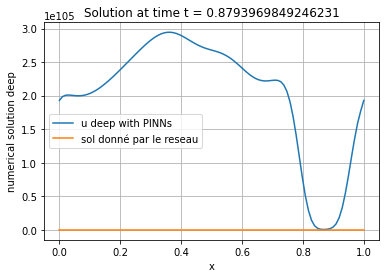

deep [7.51917574e+105 7.89553762e+105 8.03410550e+105 8.07361651e+105
 8.06816254e+105 8.04794018e+105 8.03085780e+105 8.02705585e+105
 8.04176597e+105 8.07719137e+105 8.13367961e+105 8.21045635e+105
 8.30607767e+105 8.41871903e+105 8.54637204e+105 8.68698182e+105
 8.83854229e+105 8.99916053e+105 9.16711201e+105 9.34085597e+105
 9.51904874e+105 9.70051879e+105 9.88422723e+105 1.00692158e+106
 1.02545154e+106 1.04390515e+106 1.06215365e+106 1.08003447e+106
 1.09734406e+106 1.11383208e+106 1.12920226e+106 1.14312343e+106
 1.15524596e+106 1.16522547e+106 1.17275329e+106 1.17758675e+106
 1.17957855e+106 1.17870334e+106 1.17507535e+106 1.16895509e+106
 1.16074315e+106 1.15095710e+106 1.14019197e+106 1.12906801e+106
 1.11817042e+106 1.10798869e+106 1.09886528e+106 1.09096045e+106
 1.08423781e+106 1.07847338e+106 1.07328648e+106 1.06818661e+106
 1.06263362e+106 1.05610011e+106 1.04813505e+106 1.03841897e+106
 1.02680774e+106 1.01335956e+106 9.98343007e+105 9.82219863e+105
 9.65610361e+105 9.4

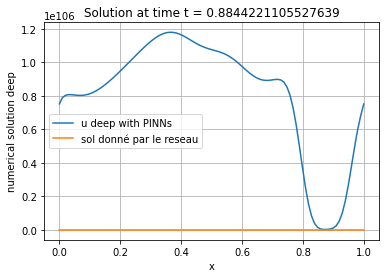

deep [2.90749041e+106 3.12586185e+106 3.20991091e+106 3.24046575e+106
 3.24485165e+106 3.23816842e+106 3.22966304e+106 3.22477434e+106
 3.22646234e+106 3.23613645e+106 3.25425386e+106 3.28069447e+106
 3.31499025e+106 3.35646943e+106 3.40435261e+106 3.45781871e+106
 3.51605023e+106 3.57826420e+106 3.64373861e+106 3.71182255e+106
 3.78194548e+106 3.85361100e+106 3.92638486e+106 3.99987778e+106
 4.07371252e+106 4.14748883e+106 4.22074210e+106 4.29289219e+106
 4.36320980e+106 4.43078405e+106 4.49451275e+106 4.55313110e+106
 4.60526219e+106 4.64949903e+106 4.68451856e+106 4.70920037e+106
 4.72274814e+106 4.72480691e+106 4.71555058e+106 4.69573300e+106
 4.66669313e+106 4.63029496e+106 4.58879991e+106 4.54468065e+106
 4.50038949e+106 4.45810932e+106 4.41952599e+106 4.38565242e+106
 4.35672794e+106 4.33221042e+106 4.31086016e+106 4.29089652e+106
 4.27021928e+106 4.24665246e+106 4.21820432e+106 4.18330557e+106
 4.14101214e+106 4.09114863e+106 4.03438273e+106 3.97220104e+106
 3.90681116e+106 3.8

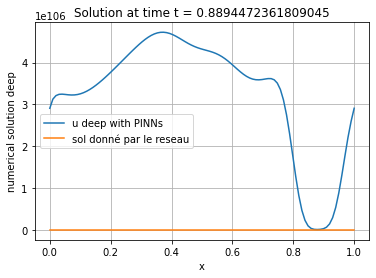

deep [1.11364764e+107 1.23057990e+107 1.27811896e+107 1.29826403e+107
 1.30407460e+107 1.30286990e+107 1.29932478e+107 1.29630023e+107
 1.29542280e+107 1.29752863e+107 1.30296500e+107 1.31178237e+107
 1.32385144e+107 1.33893571e+107 1.35673891e+107 1.37693683e+107
 1.39919900e+107 1.42320346e+107 1.44864925e+107 1.47526212e+107
 1.50279984e+107 1.53105129e+107 1.55983315e+107 1.58898461e+107
 1.61835558e+107 1.64779405e+107 1.67713053e+107 1.70615761e+107
 1.73461539e+107 1.76217559e+107 1.78843311e+107 1.81291166e+107
 1.83507760e+107 1.85436705e+107 1.87022731e+107 1.88216221e+107
 1.88978100e+107 1.89284834e+107 1.89132487e+107 1.88539594e+107
 1.87548484e+107 1.86224132e+107 1.84650348e+107 1.82923427e+107
 1.81143544e+107 1.79404857e+107 1.77785815e+107 1.76340944e+107
 1.75095229e+107 1.74042024e+107 1.73144708e+107 1.72341507e+107
 1.71553335e+107 1.70693040e+107 1.69675786e+107 1.68429058e+107
 1.66901673e+107 1.65070803e+107 1.62946532e+107 1.60572670e+107
 1.58024579e+107 1.5

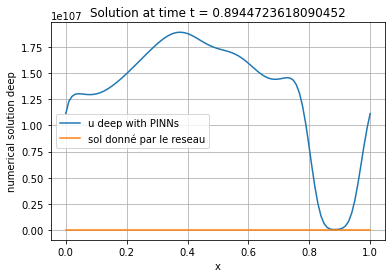

deep [4.21818504e+107 4.81096149e+107 5.06676625e+107 5.18822112e+107
 5.23463861e+107 5.24032730e+107 5.22837840e+107 5.21355781e+107
 5.20460621e+107 5.20626895e+107 5.22078520e+107 5.24886690e+107
 5.29029985e+107 5.34431211e+107 5.40980962e+107 5.48553167e+107
 5.57015513e+107 5.66236528e+107 5.76091413e+107 5.86465047e+107
 5.97254760e+107 6.08370611e+107 6.19734706e+107 6.31279674e+107
 6.42944572e+107 6.54670397e+107 6.66394315e+107 6.78041728e+107
 6.89520248e+107 7.00712503e+107 7.11471238e+107 7.21619450e+107
 7.30953426e+107 7.39251093e+107 7.46286584e+107 7.51847078e+107
 7.55751988e+107 7.57873664e+107 7.58155315e+107 7.56625351e+107
 7.53406595e+107 7.48716511e+107 7.42857183e+107 7.36194834e+107
 7.29128993e+107 7.22054407e+107 7.15321227e+107 7.09198518e+107
 7.03846132e+107 6.99299501e+107 6.95469146e+107 6.92153611e+107
 6.89065814e+107 6.85866956e+107 6.82206981e+107 6.77765492e+107
 6.72290611e+107 6.65631464e+107 6.57762247e+107 6.48792352e+107
 6.38964850e+107 6.2

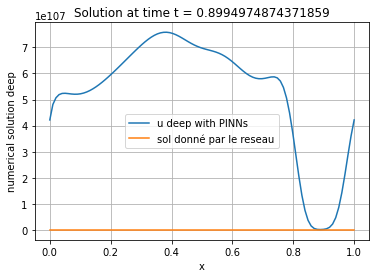

deep [1.57712183e+108 1.86510309e+108 1.99739171e+108 2.06631118e+108
 2.09742676e+108 2.10622026e+108 2.10379838e+108 2.09762849e+108
 2.09231668e+108 2.09047728e+108 2.09344517e+108 2.10176925e+108
 2.11552146e+108 2.13448528e+108 2.15827405e+108 2.18640742e+108
 2.21836194e+108 2.25360506e+108 2.29162245e+108 2.33193307e+108
 2.37410301e+108 2.41774926e+108 2.46253950e+108 2.50818856e+108
 2.55444450e+108 2.60107300e+108 2.64783642e+108 2.69446355e+108
 2.74062556e+108 2.78590524e+108 2.82977255e+108 2.87157785e+108
 2.91055443e+108 2.94584176e+108 2.97653464e+108 3.00174363e+108
 3.02066851e+108 3.03268184e+108 3.03740535e+108 3.03477646e+108
 3.02509898e+108 3.00906162e+108 2.98771844e+108 2.96242782e+108
 2.93474647e+108 2.90628761e+108 2.87856265e+108 2.85282562e+108
 2.82994172e+108 2.81030096e+108 2.79378772e+108 2.77980514e+108
 2.76735731e+108 2.75516864e+108 2.74183711e+108 2.72599769e+108
 2.70648519e+108 2.68247880e+108 2.65361905e+108 2.62007437e+108
 2.58256352e+108 2.5

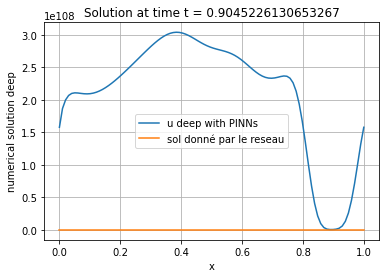

deep [5.80946024e+108 7.15864087e+108 7.81976162e+108 8.19316094e+108
 8.38272876e+108 8.45524107e+108 8.46248288e+108 8.44136146e+108
 8.41568674e+108 8.39953806e+108 8.40051864e+108 8.42219210e+108
 8.46566398e+108 8.53055212e+108 8.61558611e+108 8.71898742e+108
 8.83871643e+108 8.97263685e+108 9.11864391e+108 9.27473849e+108
 9.43909404e+108 9.61008242e+108 9.78628379e+108 9.96648255e+108
 1.01496217e+109 1.03347504e+109 1.05209489e+109 1.07072156e+109
 1.08923736e+109 1.10749442e+109 1.12530353e+109 1.14242897e+109
 1.15858604e+109 1.17344632e+109 1.18665337e+109 1.19784367e+109
 1.20667382e+109 1.21285356e+109 1.21617733e+109 1.21655368e+109
 1.21403027e+109 1.20880753e+109 1.20123872e+109 1.19181395e+109
 1.18112562e+109 1.16981741e+109 1.15852336e+109 1.14780381e+109
 1.13808703e+109 1.12962553e+109 1.12247296e+109 1.11648241e+109
 1.11132907e+109 1.10654993e+109 1.10160004e+109 1.09591606e+109
 1.08898287e+109 1.08039581e+109 1.06991458e+109 1.05749945e+109
 1.04333133e+109 1.0

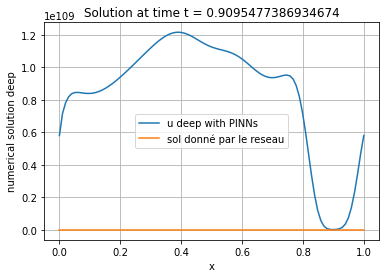

deep [2.10412617e+109 2.71562042e+109 3.03586970e+109 3.23054570e+109
 3.33890147e+109 3.38815713e+109 3.40157528e+109 3.39691830e+109
 3.38624235e+109 3.37698044e+109 3.37333337e+109 3.37743493e+109
 3.39015152e+109 3.41158244e+109 3.44136648e+109 3.47887276e+109
 3.52332240e+109 3.57386861e+109 3.62965717e+109 3.68986246e+109
 3.75371929e+109 3.82053774e+109 3.88971143e+109 3.96072008e+109
 4.03311539e+109 4.10650399e+109 4.18052143e+109 4.25479007e+109
 4.32888426e+109 4.40227958e+109 4.47430477e+109 4.54411328e+109
 4.61066126e+109 4.67271314e+109 4.72888830e+109 4.77772969e+109
 4.81780193e+109 4.84781793e+109 4.86676627e+109 4.87403661e+109
 4.86953480e+109 4.85375981e+109 4.82783246e+109 4.79346523e+109
 4.75285700e+109 4.70851704e+109 4.66303787e+109 4.61884030e+109
 4.57792419e+109 4.54166351e+109 4.51067261e+109 4.48475417e+109
 4.46294548e+109 4.44364027e+109 4.42478713e+109 4.40412981e+109
 4.37947284e+109 4.34894235e+109 4.31122508e+109 4.26574733e+109
 4.21279679e+109 4.1

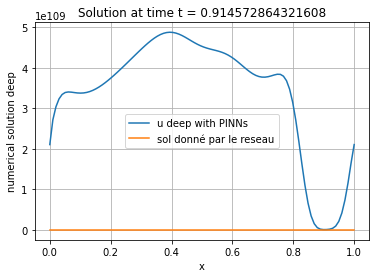

deep [7.47795927e+109 1.01630361e+110 1.16690152e+110 1.26500844e+110
 1.32402909e+110 1.35424856e+110 1.36564976e+110 1.36651717e+110
 1.36281471e+110 1.35839031e+110 1.35551161e+110 1.35539797e+110
 1.35861608e+110 1.36533674e+110 1.37549270e+110 1.38887547e+110
 1.40519589e+110 1.42412333e+110 1.44531450e+110 1.46843086e+110
 1.49315369e+110 1.51919183e+110 1.54628684e+110 1.57421570e+110
 1.60278687e+110 1.63183508e+110 1.66121253e+110 1.69077347e+110
 1.72036149e+110 1.74978965e+110 1.77882062e+110 1.80715304e+110
 1.83440865e+110 1.86012892e+110 1.88378723e+110 1.90480989e+110
 1.92261014e+110 1.93663547e+110 1.94641769e+110 1.95162481e+110
 1.95211183e+110 1.94795896e+110 1.93949344e+110 1.92729022e+110
 1.91214341e+110 1.89500841e+110 1.87692021e+110 1.85889504e+110
 1.84182771e+110 1.82640028e+110 1.81301395e+110 1.80175058e+110
 1.79237300e+110 1.78435717e+110 1.77695866e+110 1.76930050e+110
 1.76047648e+110 1.74965766e+110 1.73619507e+110 1.71970303e+110
 1.70012320e+110 1.6

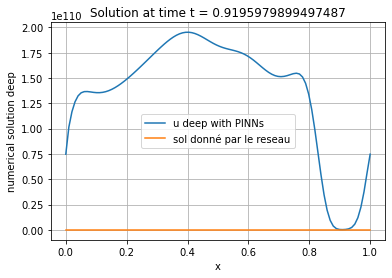

deep [2.60234463e+110 3.74502019e+110 4.43296976e+110 4.91208671e+110
 5.22104407e+110 5.39449699e+110 5.47284845e+110 5.49331142e+110
 5.48460194e+110 5.46622477e+110 5.45017466e+110 5.44320639e+110
 5.44872911e+110 5.46810706e+110 5.50147459e+110 5.54823177e+110
 5.60734909e+110 5.67756117e+110 5.75750473e+110 5.84580334e+110
 5.94113779e+110 6.04228568e+110 6.14814912e+110 6.25777272e+110
 6.37033464e+110 6.48513246e+110 6.60155444e+110 6.71902403e+110
 6.83695434e+110 6.95467212e+110 7.07133814e+110 7.18588684e+110
 7.29696211e+110 7.40288397e+110 7.50167280e+110 7.59110685e+110
 7.66883410e+110 7.73254456e+110 7.78016136e+110 7.81005021e+110
 7.82123560e+110 7.81357805e+110 7.78789756e+110 7.74602361e+110
 7.69073413e+110 7.62557759e+110 7.55459089e+110 7.48193176e+110
 7.41146984e+110 7.34639600e+110 7.28890101e+110 7.23995600e+110
 7.19924031e+110 7.16519985e+110 7.13525263e+110 7.10609761e+110
 7.07410487e+110 7.03574016e+110 6.98799419e+110 6.92875447e+110
 6.85711593e+110 6.7

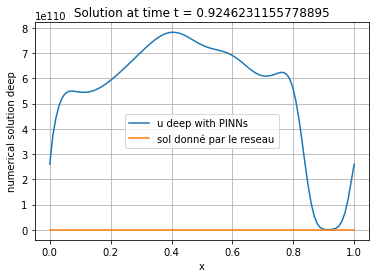

deep [8.84926027e+110 1.35605941e+111 1.66136045e+111 1.88841654e+111
 2.04460095e+111 2.13932671e+111 2.18767908e+111 2.20561844e+111
 2.20653880e+111 2.20009506e+111 2.19250596e+111 2.18742583e+111
 2.18680953e+111 2.19155700e+111 2.20193198e+111 2.21781778e+111
 2.23887220e+111 2.26462416e+111 2.29454040e+111 2.32806677e+111
 2.36466128e+111 2.40381370e+111 2.44505964e+111 2.48799076e+111
 2.53225388e+111 2.57754815e+111 2.62361618e+111 2.67022436e+111
 2.71714703e+111 2.76413785e+111 2.81089868e+111 2.85705429e+111
 2.90212297e+111 2.94549656e+111 2.98644112e+111 3.02410945e+111
 3.05757548e+111 3.08589476e+111 3.10817554e+111 3.12366098e+111
 3.13181883e+111 3.13241969e+111 3.12559871e+111 3.11189263e+111
 3.09223571e+111 3.06791037e+111 3.04045458e+111 3.01152907e+111
 2.98275952e+111 2.95557547e+111 2.93106659e+111 2.90987155e+111
 2.89212083e+111 2.87743081e+111 2.86495942e+111 2.85350880e+111
 2.84166800e+111 2.82797783e+111 2.81110595e+111 2.79000727e+111
 2.76406686e+111 2.7

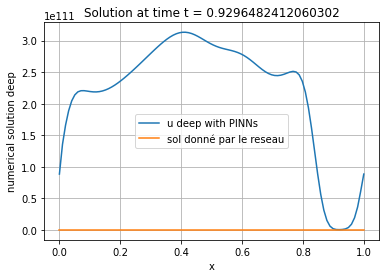

deep [2.93429973e+111 4.81471615e+111 6.13049608e+111 7.17530725e+111
 7.93990478e+111 8.43659774e+111 8.71504754e+111 8.83976737e+111
 8.87089943e+111 8.85494286e+111 8.82345328e+111 8.79579506e+111
 8.78282744e+111 8.78999221e+111 8.81943791e+111 8.87134270e+111
 8.94471036e+111 9.03785726e+111 9.14873851e+111 9.27514963e+111
 9.41488286e+111 9.56582237e+111 9.72601435e+111 9.89371941e+111
 1.00674210e+112 1.02458249e+112 1.04278348e+112 1.06124839e+112
 1.07988815e+112 1.09861071e+112 1.11730909e+112 1.13585123e+112
 1.15406727e+112 1.17173944e+112 1.18859919e+112 1.20432820e+112
 1.21856779e+112 1.23093939e+112 1.24107007e+112 1.24862402e+112
 1.25333875e+112 1.25505854e+112 1.25376307e+112 1.24958824e+112
 1.24283208e+112 1.23394362e+112 1.22349448e+112 1.21213274e+112
 1.20052394e+112 1.18928684e+112 1.17893188e+112 1.16980884e+112
 1.16207345e+112 1.15567329e+112 1.15035875e+112 1.14571437e+112
 1.14120902e+112 1.13625811e+112 1.13029327e+112 1.12282956e+112
 1.11352878e+112 1.1

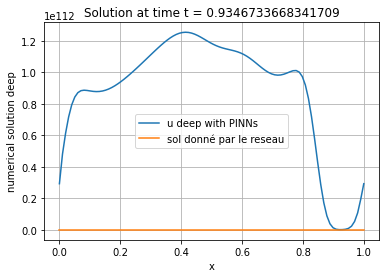

deep [9.46820330e+111 1.67245375e+112 2.22280320e+112 2.68966948e+112
 3.05270915e+112 3.30406320e+112 3.45642767e+112 3.53383403e+112
 3.56205642e+112 3.56277976e+112 3.55163397e+112 3.53867253e+112
 3.52978364e+112 3.52809942e+112 3.53504926e+112 3.55104088e+112
 3.57587248e+112 3.60898106e+112 3.64960358e+112 3.69687615e+112
 3.74990837e+112 3.80782944e+112 3.86982224e+112 3.93514926e+112
 4.00316080e+112 4.07329929e+112 4.14509393e+112 4.21813770e+112
 4.29206999e+112 4.36653798e+112 4.44115175e+112 4.51544472e+112
 4.58882066e+112 4.66050728e+112 4.72953404e+112 4.79472136e+112
 4.85470161e+112 4.90798425e+112 4.95304423e+112 4.98843920e+112
 5.01295244e+112 5.02573112e+112 5.02641335e+112 5.01523188e+112
 4.99306488e+112 4.96142451e+112 4.92237827e+112 4.87839645e+112
 4.83213883e+112 4.78620683e+112 4.74288918e+112 4.70392847e+112
 4.67035000e+112 4.64236027e+112 4.61934353e+112 4.59994474e+112
 4.58223647e+112 4.56394602e+112 4.54272583e+112 4.51642803e+112
 4.48337580e+112 4.4

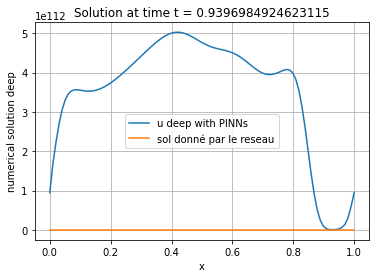

deep [2.96711126e+112 5.67011971e+112 7.90217059e+112 9.92738535e+112
 1.16004866e+113 1.28317754e+113 1.36316245e+113 1.40787990e+113
 1.42773498e+113 1.43245925e+113 1.42958174e+113 1.42420884e+113
 1.41946642e+113 1.41709953e+113 1.41797698e+113 1.42243742e+113
 1.43050323e+113 1.44200850e+113 1.45667973e+113 1.47418493e+113
 1.49416932e+113 1.51627757e+113 1.54017024e+113 1.56553634e+113
 1.59209855e+113 1.61961684e+113 1.64788812e+113 1.67673882e+113
 1.70601962e+113 1.73559157e+113 1.76530948e+113 1.79500691e+113
 1.82447484e+113 1.85344150e+113 1.88156009e+113 1.90839930e+113
 1.93344527e+113 1.95612077e+113 1.97581438e+113 1.99192271e+113
 2.00390552e+113 2.01134142e+113 2.01398221e+113 2.01180108e+113
 2.00502244e+113 1.99412960e+113 1.97984728e+113 1.96309409e+113
 1.94490848e+113 1.92635606e+113 1.90842815e+113 1.89194182e+113
 1.87745886e+113 1.86522833e+113 1.85516635e+113 1.84687109e+113
 1.83967398e+113 1.83271933e+113 1.82506634e+113 1.81579848e+113
 1.80413670e+113 1.7

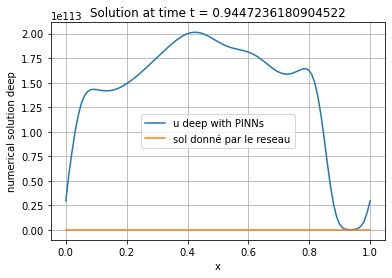

deep [9.01328704e+112 1.87140830e+113 2.74819383e+113 3.60055133e+113
 4.34910284e+113 4.93394519e+113 5.33897862e+113 5.58411832e+113
 5.70805262e+113 5.75244650e+113 5.75240433e+113 5.73323246e+113
 5.71118234e+113 5.69573883e+113 5.69192127e+113 5.70200132e+113
 5.72660741e+113 5.76538973e+113 5.81742949e+113 5.88148484e+113
 5.95616299e+113 6.04002868e+113 6.13168254e+113 6.22982128e+113
 6.33326682e+113 6.44098836e+113 6.55210858e+113 6.66588100e+113
 6.78167584e+113 6.89893110e+113 7.01709200e+113 7.13555548e+113
 7.25358632e+113 7.37023300e+113 7.48426882e+113 7.59413647e+113
 7.69793194e+113 7.79345451e+113 7.87829626e+113 7.94998907e+113
 8.00621122e+113 8.04500690e+113 8.06501152e+113 8.06566530e+113
 8.04736536e+113 8.01154058e+113 7.96063497e+113 7.89797333e+113
 7.82751554e+113 7.75352258e+113 7.68016417e+113 7.61110648e+113
 7.54914894e+113 7.49593463e+113 7.45179666e+113 7.41574283e+113
 7.38559186e+113 7.35823754e+113 7.33002139e+113 7.29715685e+113
 7.25619056e+113 7.2

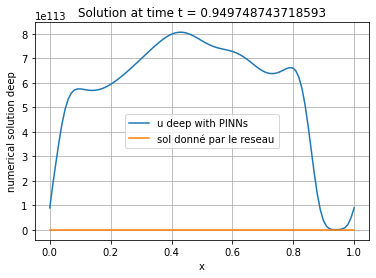

deep [2.64947347e+113 5.99594811e+113 9.32731080e+113 1.28049769e+114
 1.60556055e+114 1.87514059e+114 2.07361584e+114 2.20244182e+114
 2.27426272e+114 2.30587571e+114 2.31302499e+114 2.30790238e+114
 2.29877028e+114 2.29067354e+114 2.28641691e+114 2.28738811e+114
 2.29412035e+114 2.30663847e+114 2.32466935e+114 2.34776633e+114
 2.37539321e+114 2.40697718e+114 2.44194635e+114 2.47975832e+114
 2.51991542e+114 2.56197670e+114 2.60556347e+114 2.65035319e+114
 2.69607662e+114 2.74250099e+114 2.78940827e+114 2.83657511e+114
 2.88374055e+114 2.93057203e+114 2.97663924e+114 3.02138637e+114
 3.06411732e+114 3.10400534e+114 3.14011772e+114 3.17146453e+114
 3.19707415e+114 3.21607735e+114 3.22779847e+114 3.23184677e+114
 3.22818798e+114 3.21718979e+114 3.19963511e+114 3.17669026e+114
 3.14982844e+114 3.12071404e+114 3.09105585e+114 3.06244257e+114
 3.03618699e+114 3.01319010e+114 2.99385254e+114 2.97803835e+114
 2.96510022e+114 2.95396016e+114 2.94324028e+114 2.93142273e+114
 2.91703302e+114 2.8

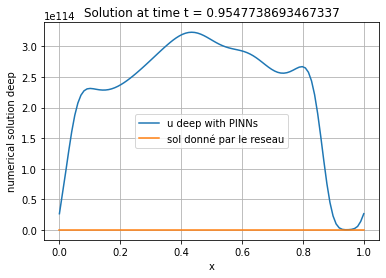

deep [7.52498659e+113 1.85901654e+114 3.08136215e+114 4.45545367e+114
 5.82489829e+114 7.03112004e+114 7.97395283e+114 8.62669522e+114
 9.02112744e+114 9.21958586e+114 9.28941111e+114 9.28743225e+114
 9.25461784e+114 9.21723386e+114 9.19056110e+114 9.18264628e+114
 9.19709763e+114 9.23487780e+114 9.29539490e+114 9.37714025e+114
 9.47810392e+114 9.59603363e+114 9.72861580e+114 9.87361057e+114
 1.00289289e+115 1.01926937e+115 1.03632747e+115 1.05392762e+115
 1.07195369e+115 1.09030737e+115 1.10890058e+115 1.12764834e+115
 1.14645656e+115 1.16520868e+115 1.18375465e+115 1.20189814e+115
 1.21938786e+115 1.23591755e+115 1.25113149e+115 1.26463967e+115
 1.27604448e+115 1.28497214e+115 1.29110860e+115 1.29423760e+115
 1.29427257e+115 1.29128014e+115 1.28549265e+115 1.27730384e+115
 1.26724718e+115 1.25595764e+115 1.24411878e+115 1.23239910e+115
 1.22138770e+115 1.21153374e+115 1.20310133e+115 1.19614349e+115
 1.19050006e+115 1.18581903e+115 1.18160000e+115 1.17725253e+115
 1.17216720e+115 1.1

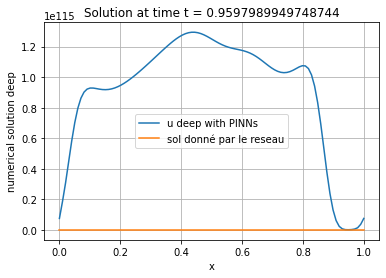

deep [2.06265136e+114 5.55717216e+114 9.88007497e+114 1.51311881e+115
 2.07240069e+115 2.59624658e+115 3.03083649e+115 3.35078298e+115
 3.55828127e+115 3.67364642e+115 3.72398837e+115 3.73477803e+115
 3.72575475e+115 3.71028540e+115 3.69651292e+115 3.68894668e+115
 3.68980260e+115 3.69991812e+115 3.71931990e+115 3.74755467e+115
 3.78389753e+115 3.82747989e+115 3.87737698e+115 3.93267200e+115
 3.99249420e+115 4.05604916e+115 4.12263793e+115 4.19165694e+115
 4.26260288e+115 4.33505475e+115 4.40864761e+115 4.48304838e+115
 4.55791024e+115 4.63282112e+115 4.70725898e+115 4.78053645e+115
 4.85175682e+115 4.91980083e+115 4.98333162e+115 5.04083768e+115
 5.09072366e+115 5.13142438e+115 5.16154288e+115 5.18000466e+115
 5.18619475e+115 5.18006929e+115 5.16223094e+115 5.13394304e+115
 5.09707796e+115 5.05399929e+115 5.00737804e+115 4.95995470e+115
 4.91428240e+115 4.87246788e+115 4.83595900e+115 4.80539704e+115
 4.78056032e+115 4.76040229e+115 4.74318531e+115 4.72668456e+115
 4.70845621e+115 4.6

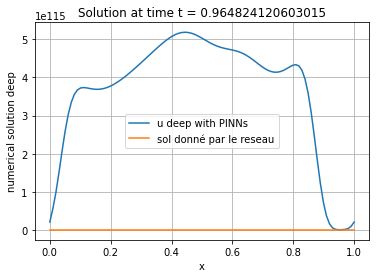

deep [5.45383478e+114 1.59468500e+115 3.06478926e+115 5.00266947e+115
 7.21477017e+115 9.42191681e+115 1.13663522e+116 1.28863405e+116
 1.39382980e+116 1.45729943e+116 1.48908428e+116 1.50006738e+116
 1.49944694e+116 1.49385427e+116 1.48753493e+116 1.48295143e+116
 1.48139356e+116 1.48343370e+116 1.48922079e+116 1.49865337e+116
 1.51148559e+116 1.52739115e+116 1.54600588e+116 1.56695833e+116
 1.58988843e+116 1.61446213e+116 1.64038127e+116 1.66738560e+116
 1.69525663e+116 1.72381235e+116 1.75289851e+116 1.78238062e+116
 1.81212723e+116 1.84199038e+116 1.87178808e+116 1.90128118e+116
 1.93015304e+116 1.95799976e+116 1.98432593e+116 2.00855470e+116
 2.03005730e+116 2.04819289e+116 2.06236030e+116 2.07205913e+116
 2.07694680e+116 2.07688866e+116 2.07199686e+116 2.06264734e+116
 2.04947266e+116 2.03332920e+116 2.01523642e+116 1.99629086e+116
 1.97756699e+116 1.96001033e+116 1.94434248e+116 1.93098669e+116
 1.92002658e+116 1.91120211e+116 1.90394523e+116 1.89744744e+116
 1.89075770e+116 1.8

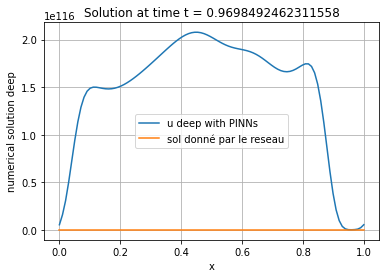

deep [1.39189521e+115 4.36935120e+115 9.16269746e+115 1.60560732e+116
 2.45194538e+116 3.35354797e+116 4.19795292e+116 4.89855568e+116
 5.41431441e+116 5.74854597e+116 5.93388023e+116 6.01406713e+116
 6.03030466e+116 6.01454645e+116 5.98841842e+116 5.96506699e+116
 5.95174167e+116 5.95197815e+116 5.96709843e+116 5.99711769e+116
 6.04129159e+116 6.09843989e+116 6.16715579e+116 6.24595250e+116
 6.33335415e+116 6.42796628e+116 6.52852457e+116 6.63391142e+116
 6.74317937e+116 6.85553754e+116 6.97032422e+116 7.08698173e+116
 7.20499602e+116 7.32382375e+116 7.44282529e+116 7.56117098e+116
 7.67775264e+116 7.79112982e+116 7.89949097e+116 8.00066654e+116
 8.09221863e+116 8.17157474e+116 8.23621602e+116 8.28391354e+116
 8.31295970e+116 8.32238421e+116 8.31213831e+116 8.28320268e+116
 8.23760903e+116 8.17836546e+116 8.10926837e+116 8.03460386e+116
 7.95877720e+116 7.88588671e+116 7.81931655e+116 7.76138758e+116
 7.71312308e+116 7.67415495e+116 7.64279113e+116 7.61622079e+116
 7.59085876e+116 7.5

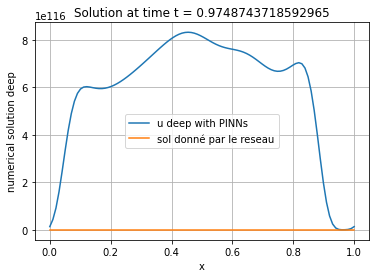

deep [3.43752525e+115 1.13532806e+116 2.62815752e+116 4.98628916e+116
 8.11386937e+116 1.16813387e+117 1.52392205e+117 1.83736253e+117
 2.08240415e+117 2.25194191e+117 2.35408308e+117 2.40500069e+117
 2.42227881e+117 2.42080242e+117 2.41130528e+117 2.40065088e+117
 2.39280752e+117 2.38984164e+117 2.39266409e+117 2.40150242e+117
 2.41618623e+117 2.43631348e+117 2.46135459e+117 2.49072326e+117
 2.52382077e+117 2.56006963e+117 2.59893729e+117 2.63994632e+117
 2.68268705e+117 2.72681532e+117 2.77204446e+117 2.81813820e+117
 2.86488911e+117 2.91209187e+117 2.95951822e+117 3.00687982e+117
 3.05379130e+117 3.09974442e+117 3.14408501e+117 3.18600834e+117
 3.22458361e+117 3.25879636e+117 3.28761474e+117 3.31007871e+117
 3.32539153e+117 3.33300991e+117 3.33272676e+117 3.32472794e+117
 3.30961911e+117 3.28841761e+117 3.26249971e+117 3.23350180e+117
 3.20318685e+117 3.17327978e+117 3.14529929e+117 3.12040221e+117
 3.09926525e+117 3.08201761e+117 3.06823679e+117 3.05700219e+117
 3.04701011e+117 3.0

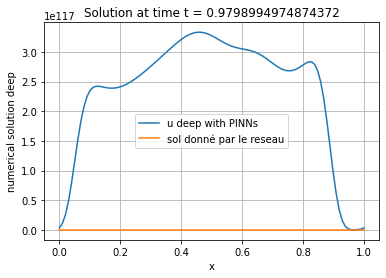

deep [8.25936767e+115 2.77267798e+116 7.19136970e+116 1.49266784e+117
 2.60700111e+117 3.97274199e+117 5.42634281e+117 6.78744700e+117
 7.91686951e+117 8.74829012e+117 9.28669404e+117 9.58448533e+117
 9.71224840e+117 9.73660465e+117 9.70927759e+117 9.66525920e+117
 9.62577373e+117 9.60247286e+117 9.60101044e+117 9.62346246e+117
 9.66982036e+117 9.73885649e+117 9.82865009e+117 9.93693293e+117
 1.00613055e+118 1.01993976e+118 1.03489828e+118 1.05080336e+118
 1.06747865e+118 1.08477454e+118 1.10256620e+118 1.12075193e+118
 1.13924564e+118 1.15796720e+118 1.17683322e+118 1.19574273e+118
 1.21456213e+118 1.23311367e+118 1.25116390e+118 1.26841821e+118
 1.28452635e+118 1.29909476e+118 1.31170902e+118 1.32196664e+118
 1.32951231e+118 1.33407453e+118 1.33550135e+118 1.33378751e+118
 1.32909157e+118 1.32174081e+118 1.31221900e+118 1.30113574e+118
 1.28918026e+118 1.27705988e+118 1.26543278e+118 1.25484154e+118
 1.24565753e+118 1.23804285e+118 1.23193632e+118 1.22706271e+118
 1.22296837e+118 1.2

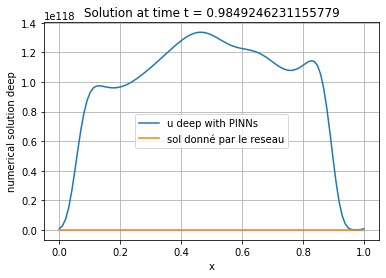

deep [1.94573989e+116 6.28675562e+116 1.86328617e+117 4.28729921e+117
 8.10665219e+117 1.31581892e+118 1.89117901e+118 2.46469486e+118
 2.96994866e+118 3.36498800e+118 3.63823312e+118 3.80262903e+118
 3.88421687e+118 3.91140102e+118 3.90826708e+118 3.89219020e+118
 3.87426610e+118 3.86088860e+118 3.85537379e+118 3.85916694e+118
 3.87261935e+118 3.89544315e+118 3.92698124e+118 3.96637835e+118
 4.01268700e+118 4.06494451e+118 4.12222742e+118 4.18368074e+118
 4.24854938e+118 4.31618496e+118 4.38604310e+118 4.45768151e+118
 4.53073465e+118 4.60487933e+118 4.67980179e+118 4.75514289e+118
 4.83043873e+118 4.90507183e+118 4.97821771e+118 5.04881109e+118
 5.11555200e+118 5.17693693e+118 5.23133074e+118 5.27708394e+118
 5.31266501e+118 5.33680543e+118 5.34864898e+118 5.34787445e+118
 5.33478596e+118 5.31036169e+118 5.27623942e+118 5.23463000e+118
 5.18816561e+118 5.13967728e+118 5.09193503e+118 5.04737373e+118
 5.00784511e+118 4.97442639e+118 4.94731595e+118 4.92582075e+118
 4.90845272e+118 4.8

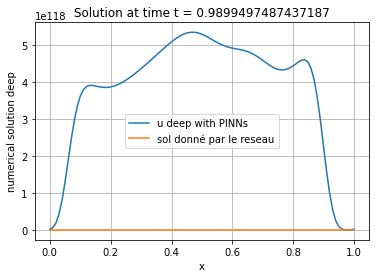

deep [4.51286686e+116 1.29999264e+117 4.52523207e+117 1.17458959e+118
 2.43032022e+118 4.23235898e+118 6.43629574e+118 8.77982142e+118
 1.09737727e+119 1.27944813e+119 1.41347932e+119 1.50021719e+119
 1.54807491e+119 1.56843739e+119 1.57207668e+119 1.56736539e+119
 1.55996531e+119 1.55330267e+119 1.54925243e+119 1.54871709e+119
 1.55202433e+119 1.55916661e+119 1.56994166e+119 1.58403863e+119
 1.60109042e+119 1.62071075e+119 1.64252013e+119 1.66616065e+119
 1.69131102e+119 1.71769154e+119 1.74506507e+119 1.77323824e+119
 1.80205324e+119 1.83137583e+119 1.86108379e+119 1.89104638e+119
 1.92110124e+119 1.95103458e+119 1.98055775e+119 2.00928994e+119
 2.03675492e+119 2.06238652e+119 2.08555006e+119 2.10558288e+119
 2.12184257e+119 2.13376299e+119 2.14091499e+119 2.14305953e+119
 2.14019094e+119 2.13256674e+119 2.12071460e+119 2.10541209e+119
 2.08764012e+119 2.06850568e+119 2.04914458e+119 2.03061206e+119
 2.01377673e+119 1.99923085e+119 1.98723083e+119 1.97767227e+119
 1.97010904e+119 1.9

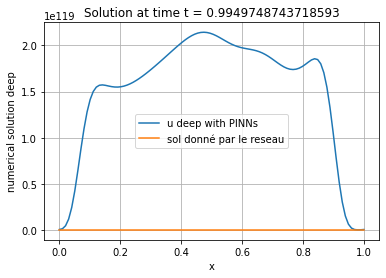

deep [1.00965594e+117 2.38003084e+117 1.01495510e+118 3.04561746e+118
 6.99134269e+118 1.31777128e+119 2.13365510e+119 3.06158270e+119
 3.98606187e+119 4.80051122e+119 5.43737700e+119 5.87779686e+119
 6.14242945e+119 6.27319373e+119 6.31596560e+119 6.30971712e+119
 6.28257285e+119 6.25246916e+119 6.22971762e+119 6.21963360e+119
 6.22451764e+119 6.24490781e+119 6.28031930e+119 6.32968520e+119
 6.39161897e+119 6.46459345e+119 6.54706536e+119 6.63754872e+119
 6.73468604e+119 6.83727743e+119 6.94429316e+119 7.05488663e+119
 7.16836925e+119 7.28416986e+119 7.40179558e+119 7.52075552e+119
 7.64047269e+119 7.76020565e+119 7.87895043e+119 7.99535941e+119
 8.10770926e+119 8.21389692e+119 8.31149624e+119 8.39789225e+119
 8.47045152e+119 8.52673258e+119 8.56472717e+119 8.58308216e+119
 8.58129493e+119 8.55986795e+119 8.52038263e+119 8.46547336e+119
 8.39869938e+119 8.32428920e+119 8.24678883e+119 8.17063912e+119
 8.09973836e+119 8.03704257e+119 7.98426439e+119 7.94169665e+119
 7.90820850e+119 7.8

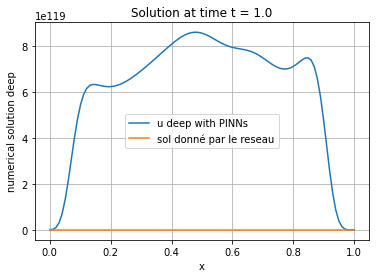

In [129]:
indices = list(range(solver.nt)) 
selected_indices = indices[::20]  

for i in range(solver.nt):
    solver.plot_solution_deep(i)